# Data Science Salaries 2024 

## Introduction


This notebook analyzes the 2024 Data Science Salary Survey dataset, which contains information about salaries, job titles, locations, and other relevant factors for data professionals worldwide. The goal is to provide insights into the current state of the data science job market, including salary trends, job demand, and regional differences. The results aim to help data professionals make informed decisions about their careers in a rapidly changing job market.


## Data Cleaning

The dataset used is the [**Data Science Salaries 2024**](https://www.kaggle.com/datasets/sazidthe1/data-science-salaries), a dataset containing informations such as salary, work model, employment type and more about data scientists in all of the world. The author **Sazidul Islam** has done a great job in cleaning the data, but some minor changes are needed.

First of all, let"s import all the libraries I are gonna use.

In [28]:
#importing libraries

from os import getcwd #to get the working directory through getcwd

from pandas import * #to manipulate dataframes

import geopandas as gpd #for choropleth maps

from plotnine import *
from numpy import *
from plotnine.stats import * #for data visualization and data transformation

from statistics import * #to get all of the statistical functions needed

from thefuzz import process #for fuzzy string matching

from owid.catalog import charts # Import Our World in Data API library

I downloaded the data and moved it into the working directory. It is in the .csv format, so I"m gonna use the function read_csv to read the file and store it in a pandas dataframe.

In [29]:
path_to_data = getcwd() + r"\data_science_salaries.csv" #setting path to data

data = read_csv(path_to_data, sep = ",") #creating pandas dataframe

print("Number of rows: ", len(data)) #printing number of rows

Number of rows:  6599


The dataset contains informations regarding experience level, job title, work model (remote or on-site or hybrid), employment type (full-time, part-time, contract, freelance), company size (small, medium, large), company location and country, salary in USD and salary currency.

In [30]:
data.head() #printing quick view of data

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


There are 6599 rows, a big amount of data. First thing that comes into my eyes, is the diversity in the job_title column. Let's take a look at the job titles absolute frequencies.

In [31]:
data["job_title"].value_counts() # Printing absolute frequencies of job titles

job_title
Data Engineer                      1307
Data Scientist                     1243
Data Analyst                        910
Machine Learning Engineer           629
Analytics Engineer                  246
                                   ... 
Data Science Tech Lead                1
Staff Machine Learning Engineer       1
Cloud Data Architect                  1
Marketing Data Engineer               1
Sales Data Analyst                    1
Name: count, Length: 132, dtype: int64

Since data is collected through a voluntary survey, there hasn't been a standardization of job titles.
For the sake of simplicity, I’ll focus on the four most commonly recognized titles that could be seen as industry standards:

1. **Data Analyst**, who analyzes data in order to provide business insights.
2. **Data Scientist**, who builds models to predict future outcomes based on historical data.
3. **Machine Learning Engineer**, who implements already existing machine learning algorithms to business problems.
4. **Data Engineer**, who builds and maintains the infrastructure for data processing.

In [32]:
jobs_to_keep = ["Data Engineer", "Data Scientist", "Data Analyst", "Machine Learning Engineer"] #defining jobs to keep
data = data[data["job_title"].isin(jobs_to_keep)] #boolean indexing. data["job_title"].isin(jobs_to_keep) returns an array of False or True if the job title is in jobs_to_keep.
unique(data["job_title"])

array(['Data Analyst', 'Data Engineer', 'Data Scientist',
       'Machine Learning Engineer'], dtype=object)

As we can see, I have 4089 rows left, which are enough for our purpose. I don"t like the "-level" in every experience_level value, so I"m gonna delete it.

In [33]:
data["experience_level"] = data["experience_level"].str.replace("-level","") #removing "-level" from column experience_level

In the data set there are 127 occurrences with experience_level "executive". I will focus on the three levels below it: "senior", "mid-level", and "junior".

In [34]:
print(len(data[data['experience_level'] == "Executive"]))
data = data[data['experience_level'] != "Executive"] #dropping executive occurrences

128


In [35]:
print(len(data[data['experience_level'] == "Executive"]))

0


The dataset has a number of categorical variables. Let's convert those columns to the pandas Categorical type.

In [36]:
data["job_title"] = Categorical(data["job_title"])

data = data[data["experience_level"].isin(["Entry", "Mid", "Senior"])]
data["experience_level"] = Categorical(data["experience_level"],ordered = True, categories=["Entry", "Mid", "Senior"])

data["employment_type"] = Categorical(data["employment_type"])

data["work_models"] = Categorical(data["work_models"], ordered = True,categories = ["On-site","Hybrid","Remote"])

data["company_size"] = Categorical(data["company_size"], ordered = True, categories = ["Small", "Medium", "Large"])

#casting categories to categorical data type, ordered if needed

data.dtypes

job_title             category
experience_level      category
employment_type       category
work_models           category
work_year                int64
employee_residence      object
salary                   int64
salary_currency         object
salary_in_usd            int64
company_location        object
company_size          category
dtype: object

For the sake of having a sufficient number of occurrences in order to get meaningful informations about the job market in each country, I will drop every country that doesn't have at least 5 occurrences in the dataset.

In [37]:
print("N of countries before:",len(unique(data["company_location"])))
print("N of rows before:",len((data)))
counts = data['company_location'].value_counts() #getting absolute frequencies of countries

valid_countries = counts[counts >= 5].index #getting the countries with at least 5 occurrences

data = data[data['company_location'].isin(valid_countries)] #slicing data with value company location in valid_countries

print("N of countries after:",len(unique(data["company_location"])))
print("N of rows after:",len((data)))

N of countries before: 57
N of rows before: 3961
N of countries after: 21
N of rows after: 3893


Now, I need to import geometric data about countries in order to draw maps later on. I will download the dataset from [Natural Earth](https://www.naturalearthdata.com/) and load it into a GeoDataFrame and then a join will be performed with the main DataFrame on the country column.

In [38]:
url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

gdf = gpd.read_file(url)
gdf = gdf.loc[:,["ADMIN","geometry"]] #slice just the two columns I'm interested in
gdf.head()

,ADMIN,geometry
0,Fiji,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,United Republic of Tanzania,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Western Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,United States of America,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."


Since the countries name in the dataset might not match exactly with the names in the Natural Earth dataset, I will use the `thefuzz` library to perform **fuzzy matching** on the country names. It uses Levenshtein Distance (minimum number of single-character edits) to calculate the differences between two input sequences. I will just match the countries name and then I will merge the gdf dataset whenever needed.

In [39]:
data["country"] = data["company_location"].apply(lambda x: process.extractOne(x, gdf["ADMIN"])[0]) #matching the countries names

Here I will manually check if the matching has been done correctly.

In [40]:
for x in unique(data["company_location"]):
    a = process.extractOne(x,gdf["ADMIN"])[0] 
    print(x,"|",a) #checking if the matched names are correct

Argentina | Argentina
Australia | Australia
Brazil | Brazil
Canada | Canada
Colombia | Colombia
Estonia | Estonia
France | France
Germany | Germany
Greece | Greece
India | India
Ireland | Ireland
Italy | Italy
Latvia | Latvia
Mexico | Mexico
Netherlands | Netherlands
Poland | Poland
Portugal | Portugal
Slovenia | Slovenia
Spain | Spain
United Kingdom | United Kingdom
United States | United States of America


In [41]:
data.drop(["company_location","salary_currency"], axis = 1, inplace = True) #dropping ADMIN and company_location columns as no longer needed

In order to get meaningful informations about salaries and the quality of life of data workers in different countries, I will convert salaries to ***international USD*** (**int-USD**) that is a hypothetical currency that has the same purchasing power that the U.S. dollar had in the United States at a given point in time. The int-USD index works both as an exchange rate and as a PPP index (purchase power parity): it converts local currencies to USD and adjust for differences in price levels between countries. The price levels are of the year 2023, that is the most recent year for which we have complete data.

The PPP index dataset can be found [here](https://ourworldindata.org/grapher/ppp-conversion-factor-for-private-consumption). I will source these data by using the API library that "our world in data" provides.
 

In [42]:
ppp_dataset = charts.get_data(r"https://ourworldindata.org/grapher/ppp-conversion-factor-for-private-consumption") # Get PPP index (Purchase Power Parity index) dataset
ppp_dataset = ppp_dataset[ppp_dataset ["years"] == 2023] # Keep only 2023 data
ppp_dataset = ppp_dataset[~ppp_dataset["entities"].isin(["Saint Lucia", "Singapore","Iceland","Austria"])].reset_index() # Remove specific countries to improve later matching
data = data[data["country"] != "Argentina"].reset_index() # Remove Argentina as it is not in the PPP dataset due to the rampaging inflation in those years and the difficulty

Then, I will match the countries with the fuzzy matching algorithm we saw before:

In [43]:
for x in unique(ppp_dataset["entities"]): #looping through countries in the PPP dataset
    try: #try is needed as some countries might not be matched and Nan[index] throws an error
        a = process.extractOne(x, unique(data["country"]), score_cutoff=85)[0] #fuzzy matching with a score cutoff of 90
        print(x, "|", a)
    except Exception as e:
        print(x, "|", None)

Albania | None
Algeria | None
Angola | None
Antigua and Barbuda | None
Armenia | None
Australia | Australia
Azerbaijan | None
Bahamas | None
Bahrain | None
Bangladesh | None
Belarus | None
Belgium | None
Belize | None
Benin | None
Bhutan | None
Bolivia | None
Bosnia and Herzegovina | None
Botswana | None
Brazil | Brazil
Brunei | None
Bulgaria | None
Burkina Faso | None
Burundi | None
Cambodia | None
Cameroon | None
Canada | Canada
Cape Verde | None
Central African Republic | None
Chad | None
Chile | None
China | None
Colombia | Colombia
Congo | None
Costa Rica | None
Cote d'Ivoire | None
Croatia | None
Cyprus | None
Czechia | None
Denmark | None
Djibouti | None
Dominica | None
Dominican Republic | None
East Timor | None
Ecuador | None
Egypt | None
El Salvador | None
Estonia | Estonia
Ethiopia | None
Fiji | None
Finland | None
France | France
Gabon | None
Gambia | None
Georgia | None
Germany | Germany
Ghana | None
Greece | Greece
Grenada | None
Guinea | None
Guyana | None
Haiti | None
H

In [44]:
ppp_dataset["entities"] = ppp_dataset["entities"].apply(lambda x: process.extractOne(x, data["country"], score_cutoff=85)[0] 
                                                        if process.extractOne(x, data["country"], score_cutoff=85) is not None 
                                                        else None) #fuzzy matching with a score cutoff of 85

In [45]:
data = merge(data, ppp_dataset.loc[:,["entities","ppp_conversion_factor_for_private_consumption"]], left_on = "country", right_on = "entities", how = "left") #merging PPP dataset to main dataset
data.drop(columns = ["entities"],axis = 1, inplace = True) #dropping entities column as no longer needed

In [46]:
data["salary_in_usd"] = data["salary"] / data["ppp_conversion_factor_for_private_consumption"] #converting salaries to international USD

Since we've done anything needed, let's take a look at the final dataset.


In [47]:
data

,index,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_in_usd,company_size,country,ppp_conversion_factor_for_private_consumption
0,0,Data Engineer,Mid,Full-time,Remote,2024,United States,148100,148100.000000,Medium,United States of America,1.000000
1,1,Data Engineer,Mid,Full-time,Remote,2024,United States,98700,98700.000000,Medium,United States of America,1.000000
2,2,Data Scientist,Senior,Full-time,Remote,2024,United States,140032,140032.000000,Medium,United States of America,1.000000
3,3,Data Scientist,Senior,Full-time,Remote,2024,United States,100022,100022.000000,Medium,United States of America,1.000000
4,12,Data Scientist,Mid,Full-time,Remote,2024,United States,148100,148100.000000,Medium,United States of America,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
3883,6587,Data Scientist,Entry,Full-time,On-site,2020,Germany,43200,58778.868997,Small,Germany,0.734958
3884,6588,Data Engineer,Entry,Full-time,Remote,2020,Pakistan,48000,65309.854441,Large,Germany,0.734958
3885,6589,Data Engineer,Mid,Full-time,Remote,2020,Germany,51999,70750.981689,Small,Germany,0.734958
3886,6591,Data Scientist,Mid,Full-time,On-site,2020,Germany,70000,95243.537726,Large,Germany,0.734958


In [48]:
gdf.rename(columns = {"ADMIN":"country"}, inplace = True) #renaming ADMIN to country to be able to merge
gdf

,country,geometry
0,Fiji,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,United Republic of Tanzania,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Western Sahara,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,United States of America,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."
...,...,...
172,Republic of Serbia,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,Montenegro,"POLYGON ((20.0707 42.58863, 19.80161 42.50009,..."
174,Kosovo,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,Trinidad and Tobago,"POLYGON ((-61.68 10.76, -61.105 10.89, -60.895..."


Now let"s check for missing values.

In [49]:
for x in data:
    if data[x].hasnans == "True":
        print(x,":",data[x].hasnans)
#hasnans is an attribute of pandas.Series (pandas columns) that returns False if the columns doesn"t have any Nan or True if it has at least one.

No NaN values in our data. We can go on with our visualizations

## Data Visualization

Let"s set the default theme and colors for our visualizations.

In [50]:
cols = {"Data Analyst":"#C44E52", "Data Engineer":"#E5C07B", "Data Scientist":"#4C72B0", "Machine Learning Engineer":"#55A868"}
theme_set(theme_538()) #setting theme and figure size

def lab_currency(x):
    return("{:,.0f}$".format(x).replace(",",".")) # Define labeller function for currency

Let's take a look at the job title distribution and the percentage of each job title.

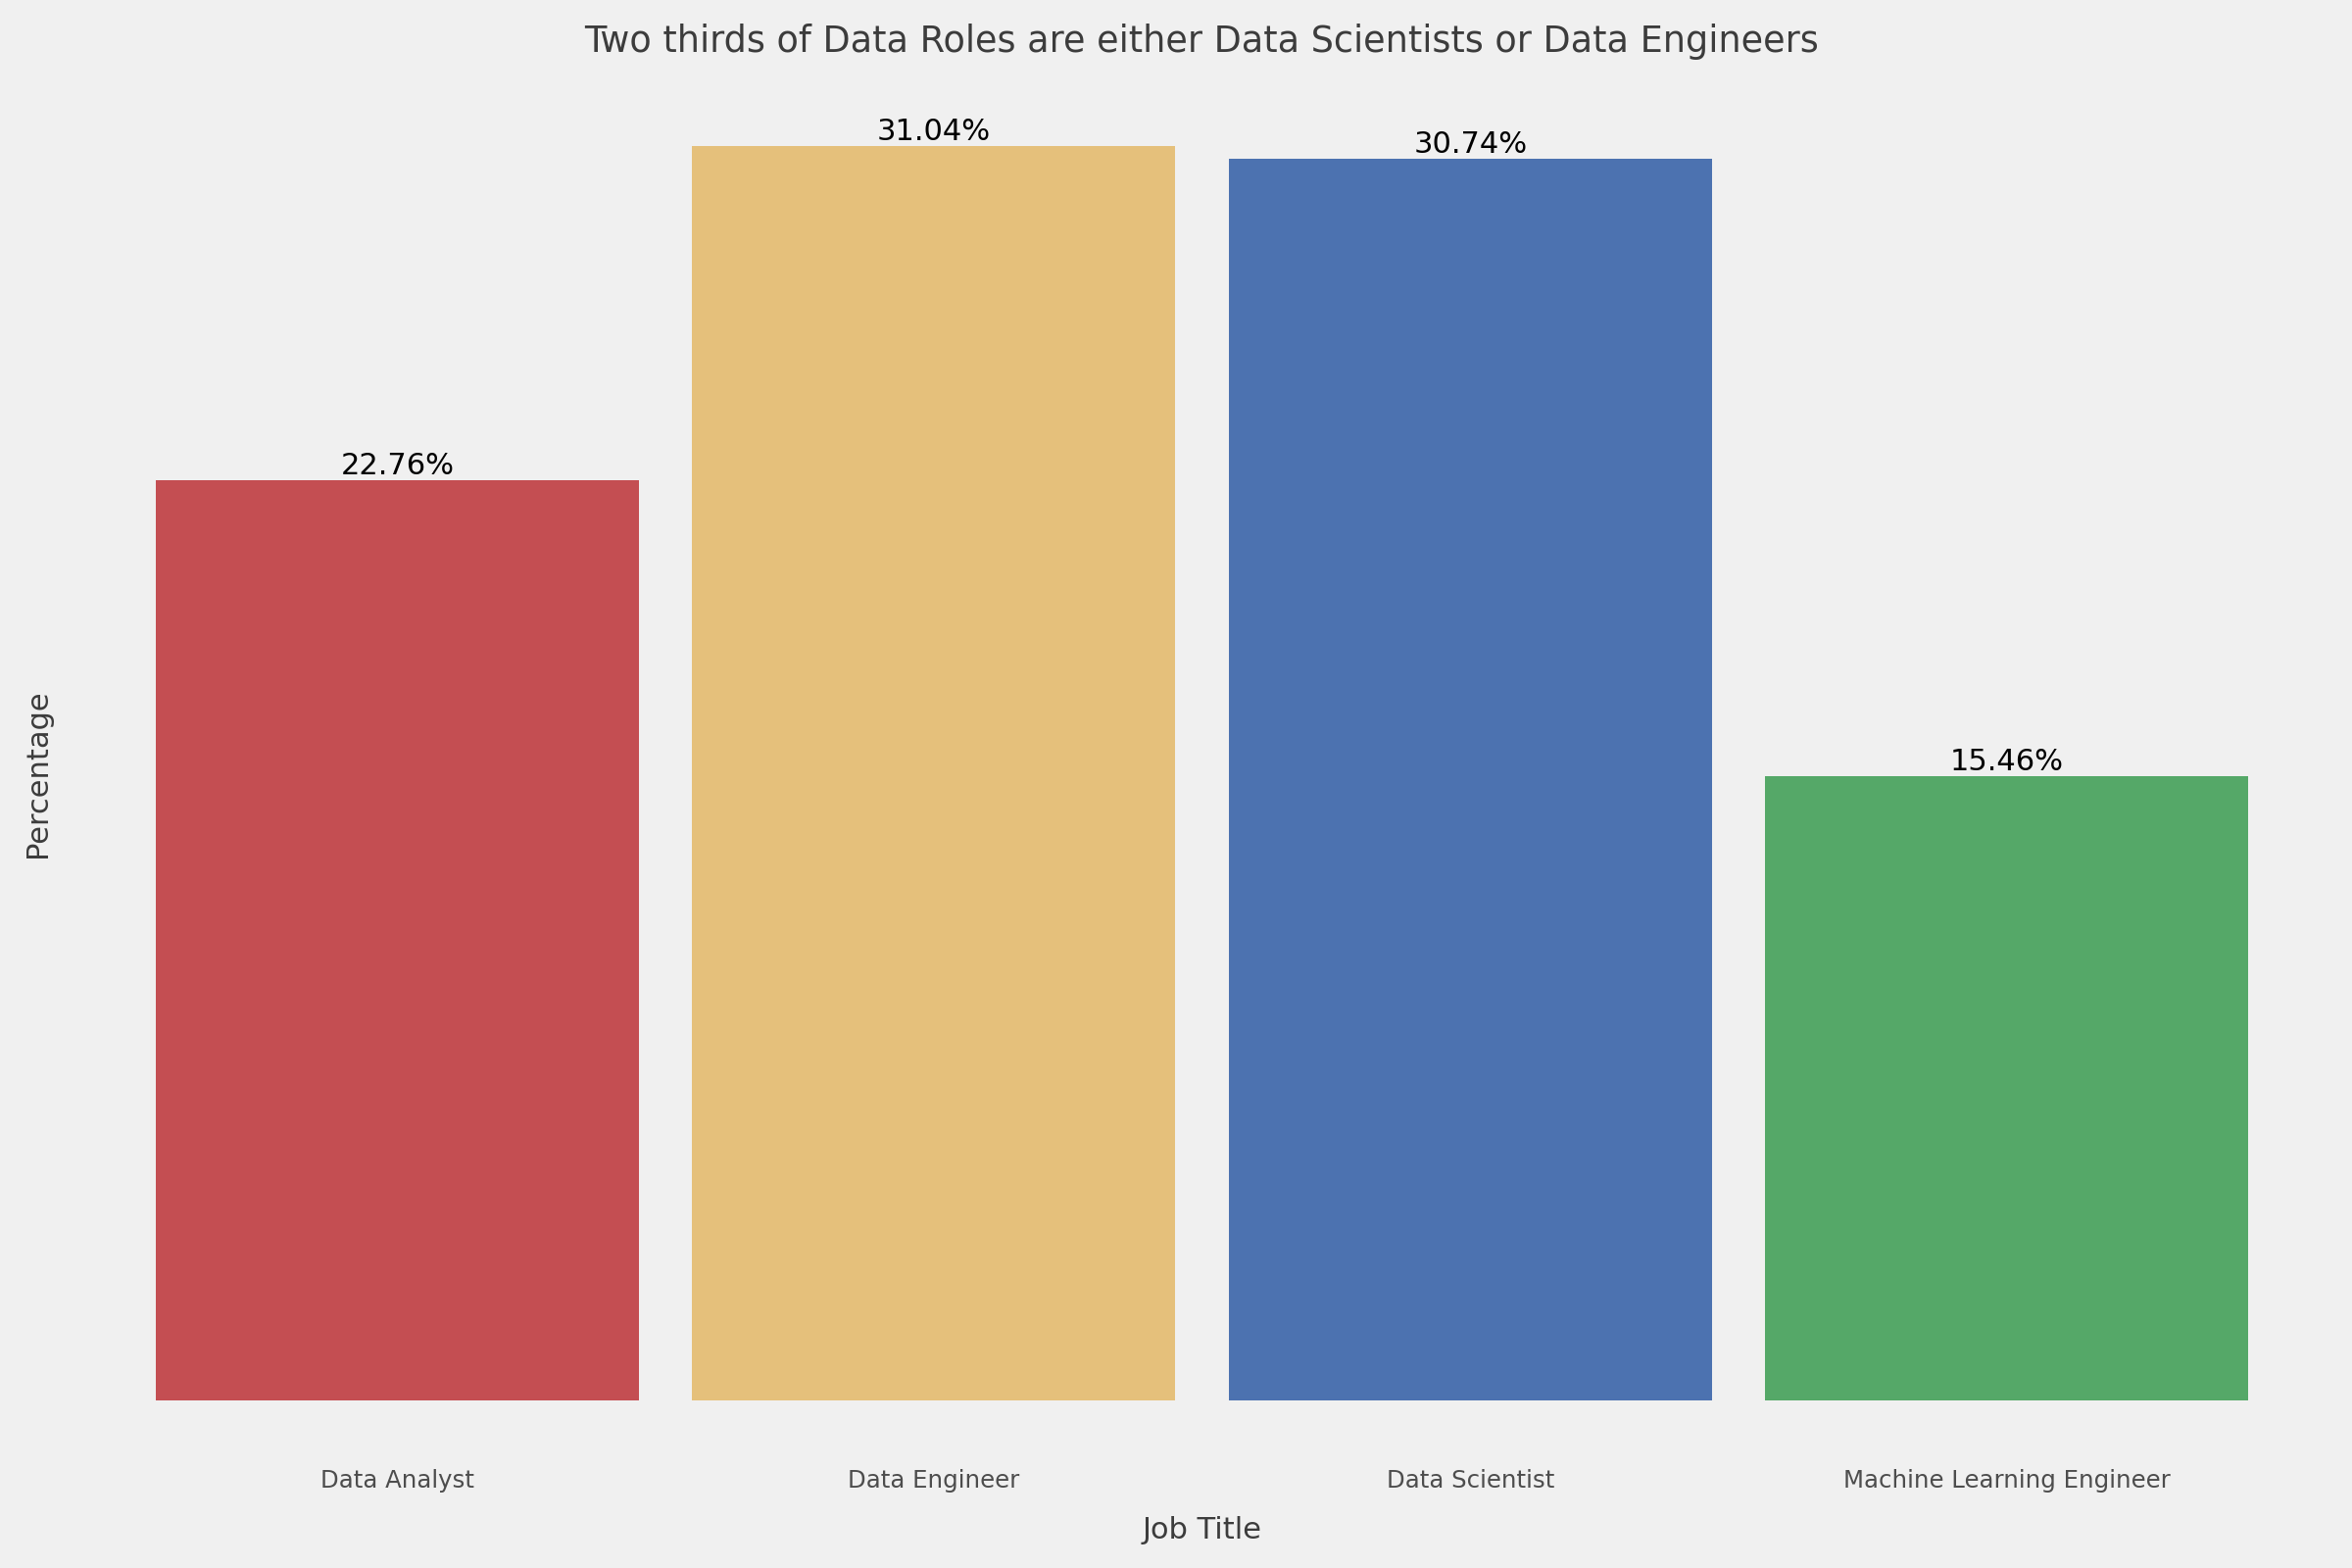

In [51]:
(
    ggplot(data, aes(x = "job_title", fill = "job_title")) # Map job_title to x-axis
    + geom_bar(aes(y = after_stat("count / sum(count) *100"))) # Create bar chart and computing percentage
    + geom_text(aes(y = after_stat("prop*100"), # maps y aesthetic to computed percentage values
                    label = after_stat("prop*100"), # maps label aesthetic to computed percentage values
                    group = 1), # ensures correct grouping of text labels
                    stat = "count", # use count stat to match bar heights
                    format_string = "{:.2f}%", # format labels as percentages with 2 decimal places
                va = "bottom") # Add text labels (percentages) over bars
    + scale_fill_manual(cols, guide = None) # Custom fill colors and remove legend
    + labs(y = "Percentage", x = "Job Title", title = "Two thirds of Data Roles are either Data Scientists or Data Engineers") # Add x and y axis labels
    + theme(axis_text_y=element_blank(),axis_ticks_y=element_blank(), figure_size = (12,8), panel_grid=element_blank()) # Remove y-axis text and ticks and increase figure size
)

More than two thirds of the data workers are Data Scientists and Data Engineers, followed by Data Analysts. Machine Learning Engineers are the least common job title.

Now let's take a look at the job title distribution by country. First of all I define a new dataframe that will contain the percentage of each job title in each country.

In [53]:
job_title_prop = data.groupby(["country", "job_title"]).size().reset_index(name = "count") # Get a grouped by employee residence and job title dataframe
job_title_prop.drop(["count"], axis=1, inplace=True) # Drop "count" column
job_title_prop["percentage"] = data.groupby(["country", "job_title"]).size().groupby("country").apply(lambda x: round(x / x.sum() * 100, 2)).reset_index(drop = True) # Calculate percentage of each job title in each country
job_title_prop = job_title_prop[job_title_prop["percentage"] > 0]
job_title_prop

2025-09-06 13:12:15 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_28164\936607163.py lineno=1
2025-09-06 13:12:15 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_28164\936607163.py lineno=3


,country,job_title,percentage
0,Australia,Data Analyst,33.33
1,Australia,Data Engineer,16.67
2,Australia,Data Scientist,33.33
3,Australia,Machine Learning Engineer,16.67
5,Brazil,Data Engineer,57.14
...,...,...,...
75,United Kingdom,Machine Learning Engineer,13.16
76,United States of America,Data Analyst,23.09
77,United States of America,Data Engineer,30.81
78,United States of America,Data Scientist,30.59


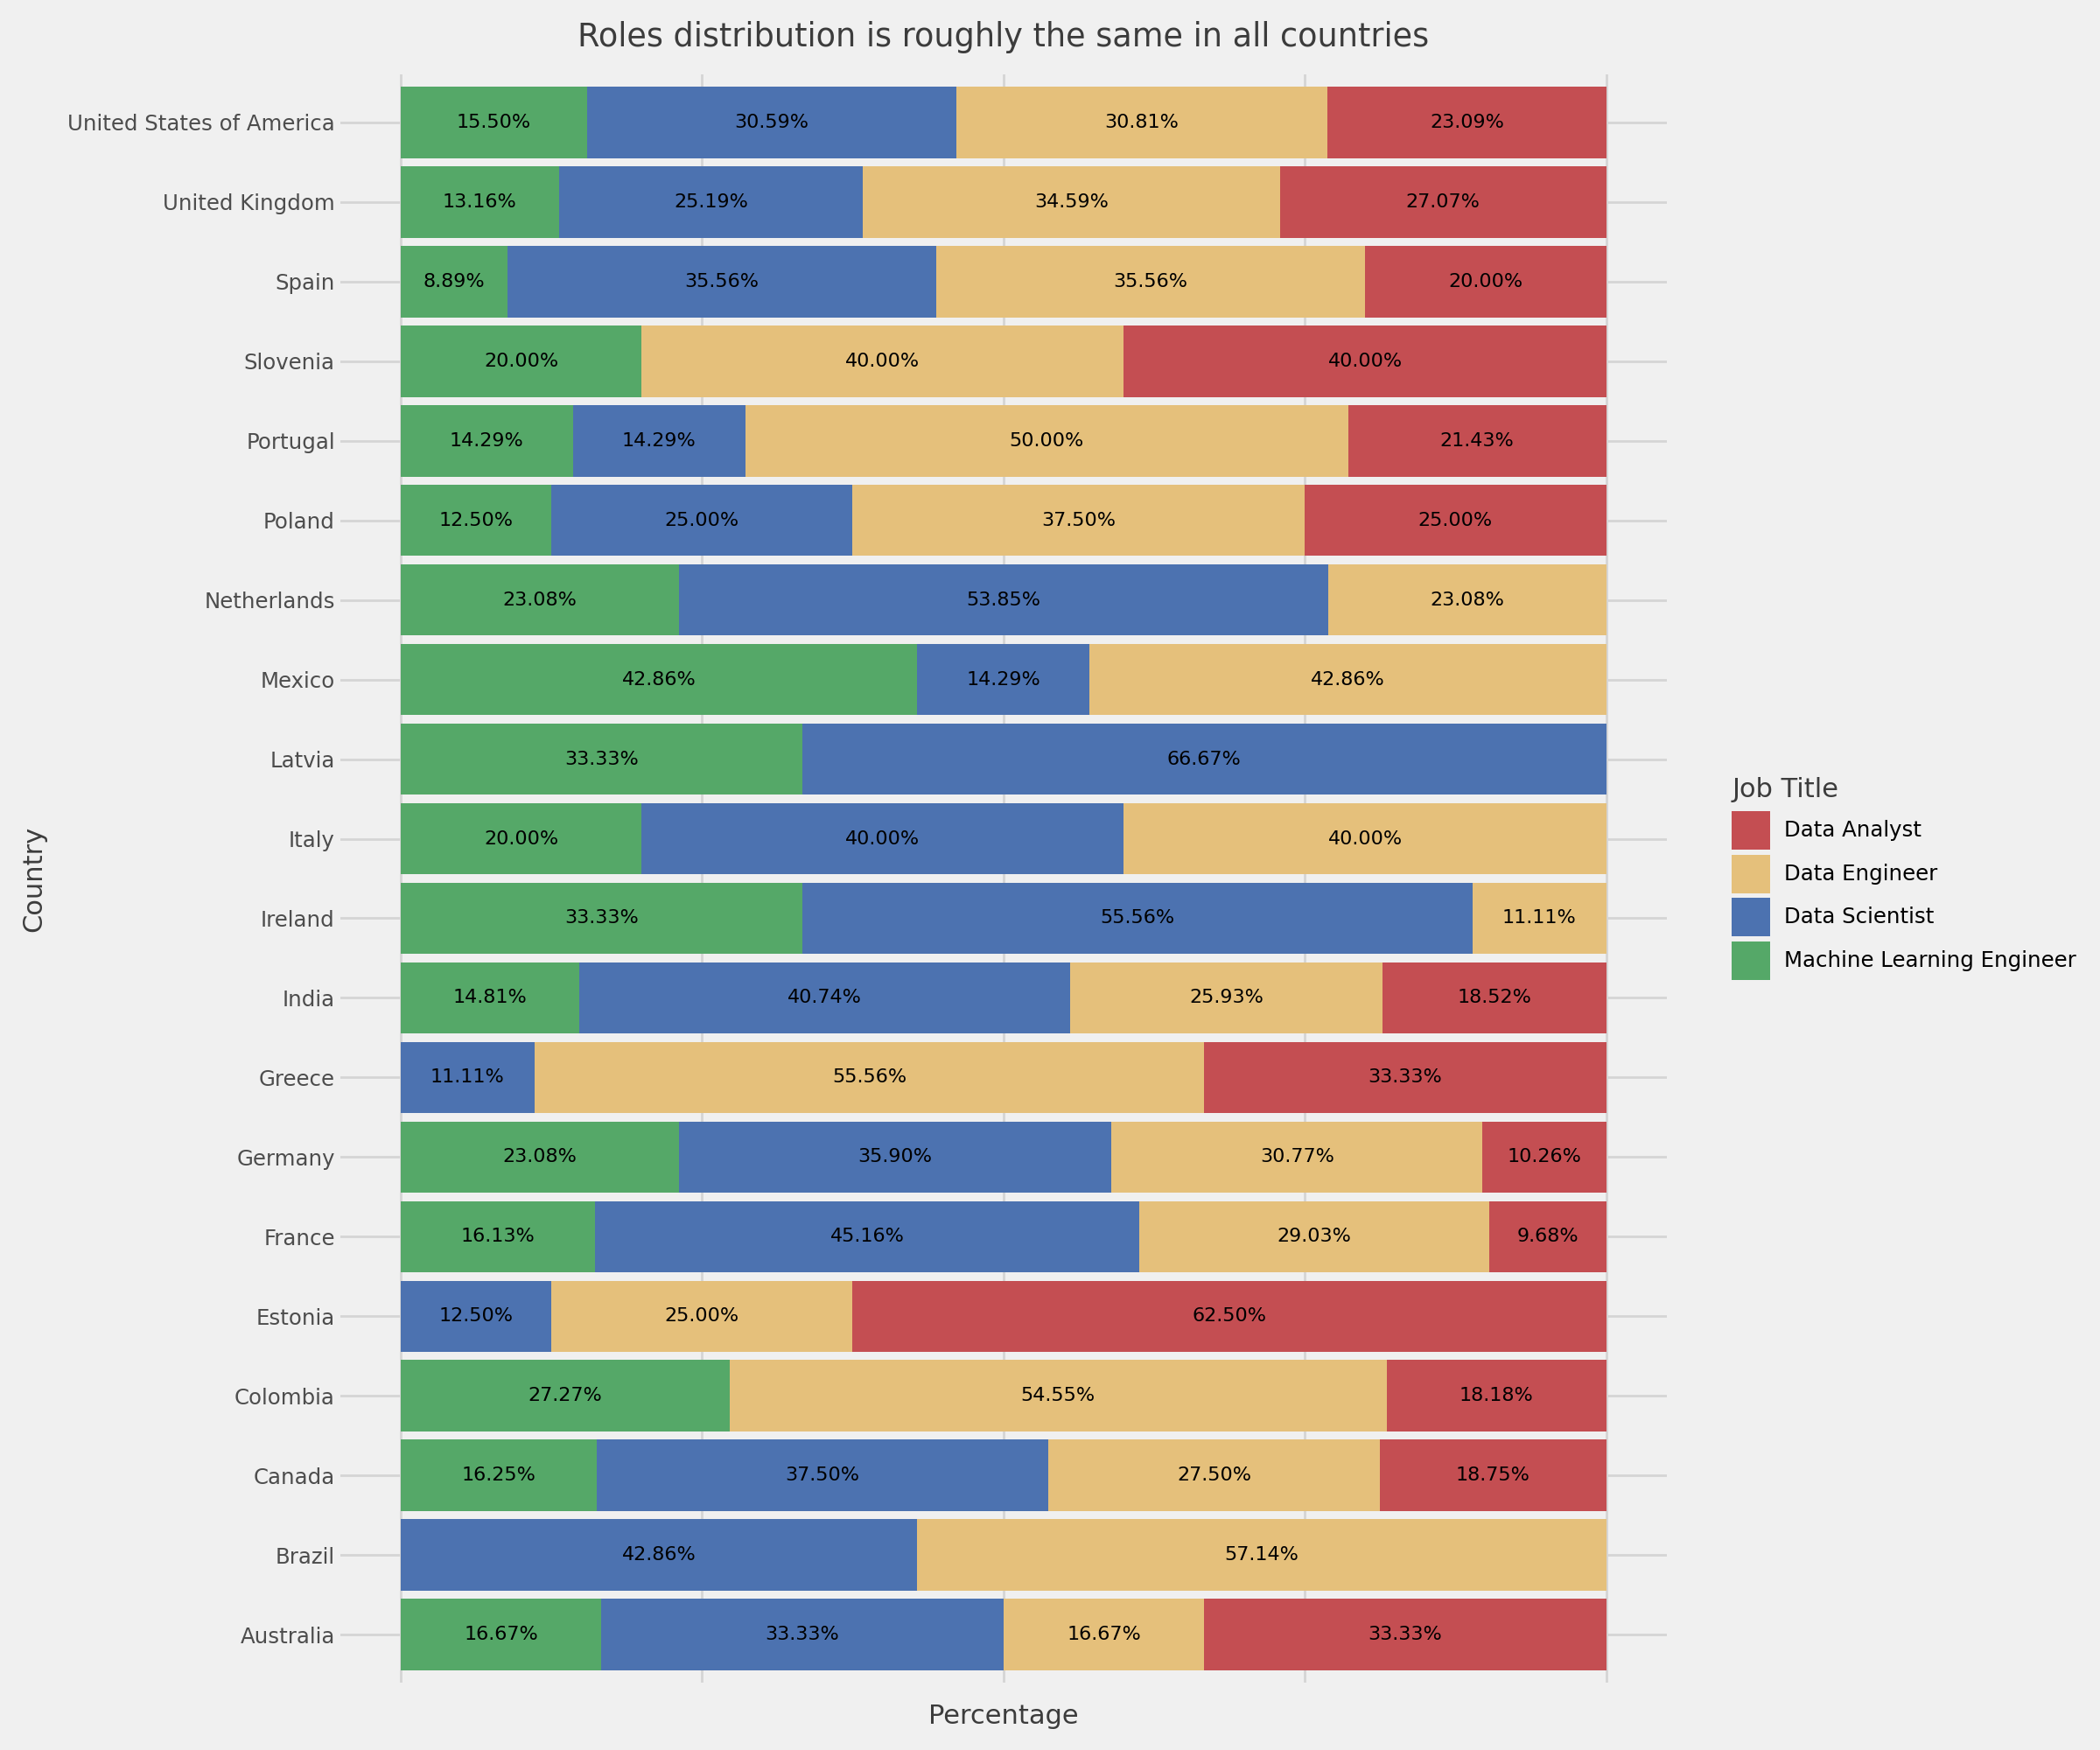

In [54]:
(
    ggplot(job_title_prop,aes(x="country", y="percentage", fill = "job_title"))
    + geom_col()
    + geom_text(aes(label = "percentage"), format_string = "{:.2f}%",position=position_stack(vjust=0.5),size = 8) # Add text labels (percentages) over bars
    + scale_fill_manual(cols) # Custom fill colors and remove legend
    + theme(figure_size=(12,10),axis_text_x=element_blank())
    + labs(y = "Percentage", x = "Country", fill = "Job Title", title = "Roles distribution is roughly the same in all countries") # Add x and y axis labels
    + coord_flip()
)

The distribution of job titles is quite similar in every country, with Data Scientists and Data Engineers being the most common job titles.

Now let's take a look at the distribution of experience levels.

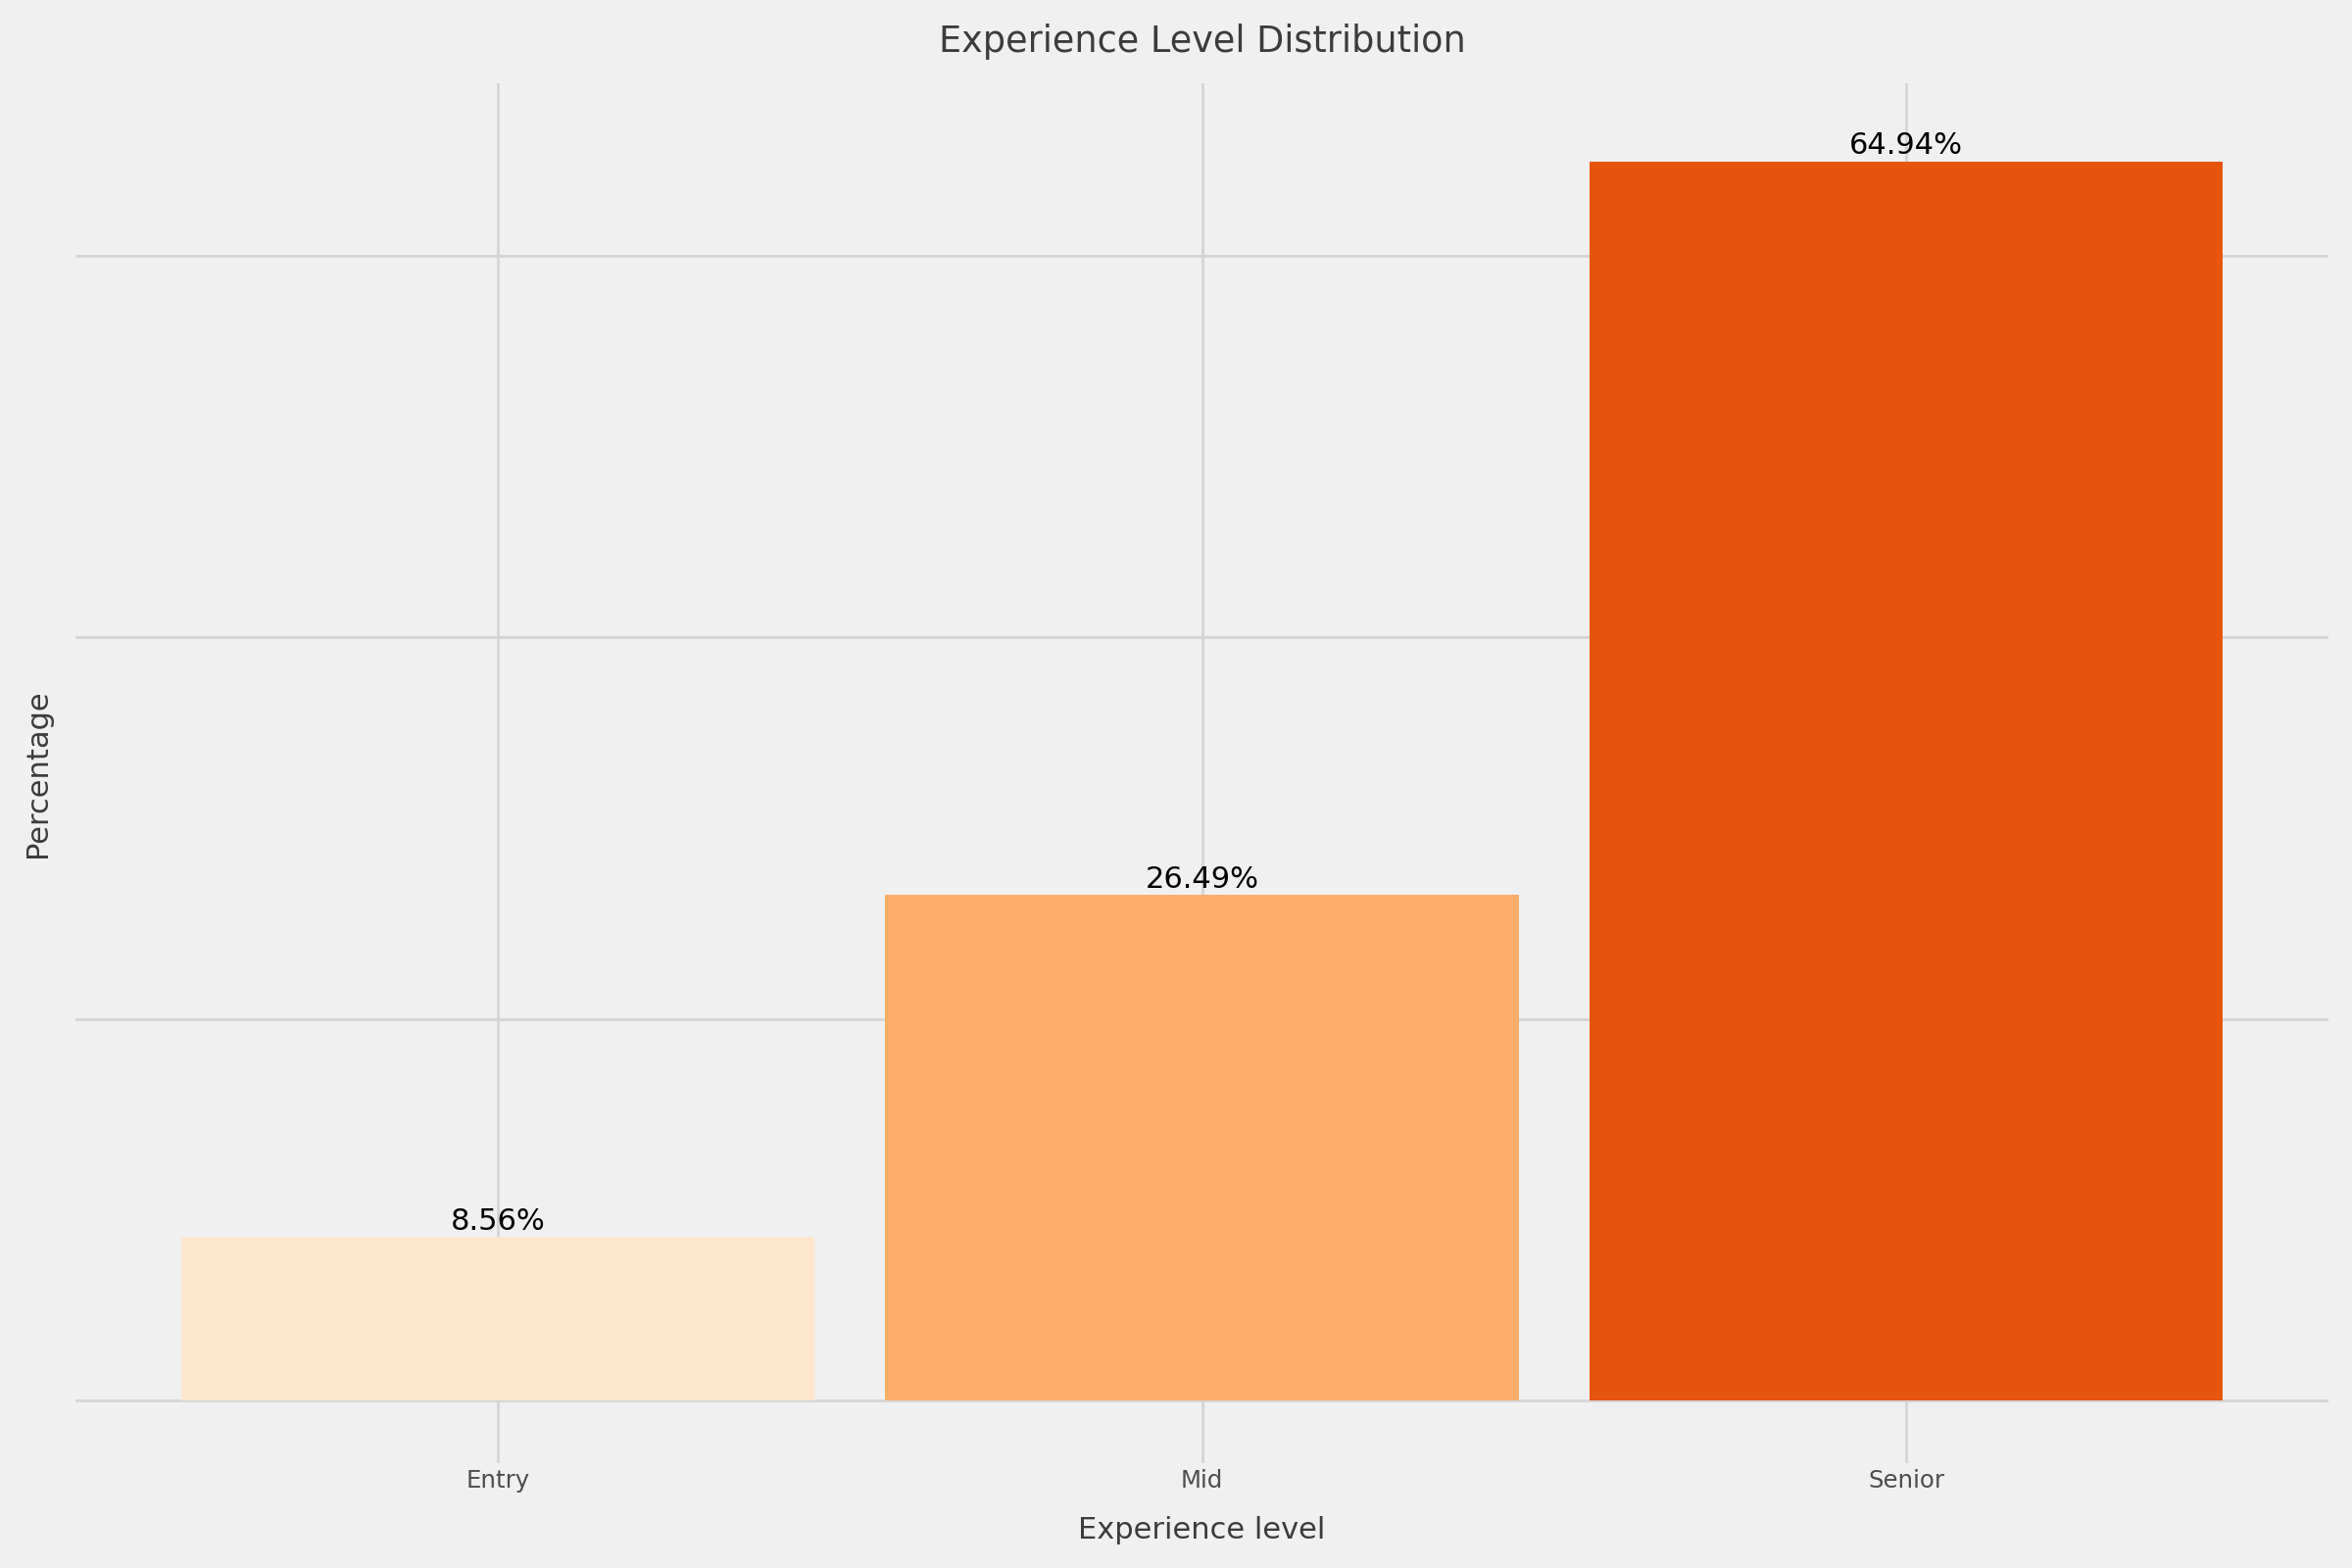

In [55]:
(
    ggplot(data, aes(x="experience_level",fill = "experience_level")) # Map experience_level to x-axis
    + geom_bar(aes(y = after_stat("count / sum(count) * 100"))) # Create bar chart and computing percentage
    + geom_text(aes(y = after_stat("count / sum(count) * 100"), label = after_stat("count / sum(count) * 100")), stat = "count", format_string = "{:.2f}%", nudge_y = 0.8) # Add text labels (percentages) over bars
    + scale_fill_brewer(palette="Oranges",guide = None) # Custom fill colors and remove legend
    + labs(y="Percentage", x = "Experience level", title = "Experience Level Distribution") # Add x and y axis labels
    + theme(axis_ticks_x=element_blank(),axis_ticks_y=element_blank(),axis_text_y=element_blank(), figure_size=(12,8)) # Remove y and x axis text and ticks and increase figure size
)

The most common experience level is "senior", followed by "mid-level" and "junior". Probably because a worker is a "senior" for the majority of his/her career: ones is a "entry-level" for about 2-3 years, then "mid-level" for 3-5 years and then "senior" for the rest of his/her career.

Another interesting aspect to analyze is the distribution of company sizes. 
My expectation is that most of the data workers work in large companies, this for two reasons: large companies have more resources to invest in data science and the dataset is greatly influenced by the US, where a big chunk of workers (around 40%) work in large companies (which are 1% of the total).

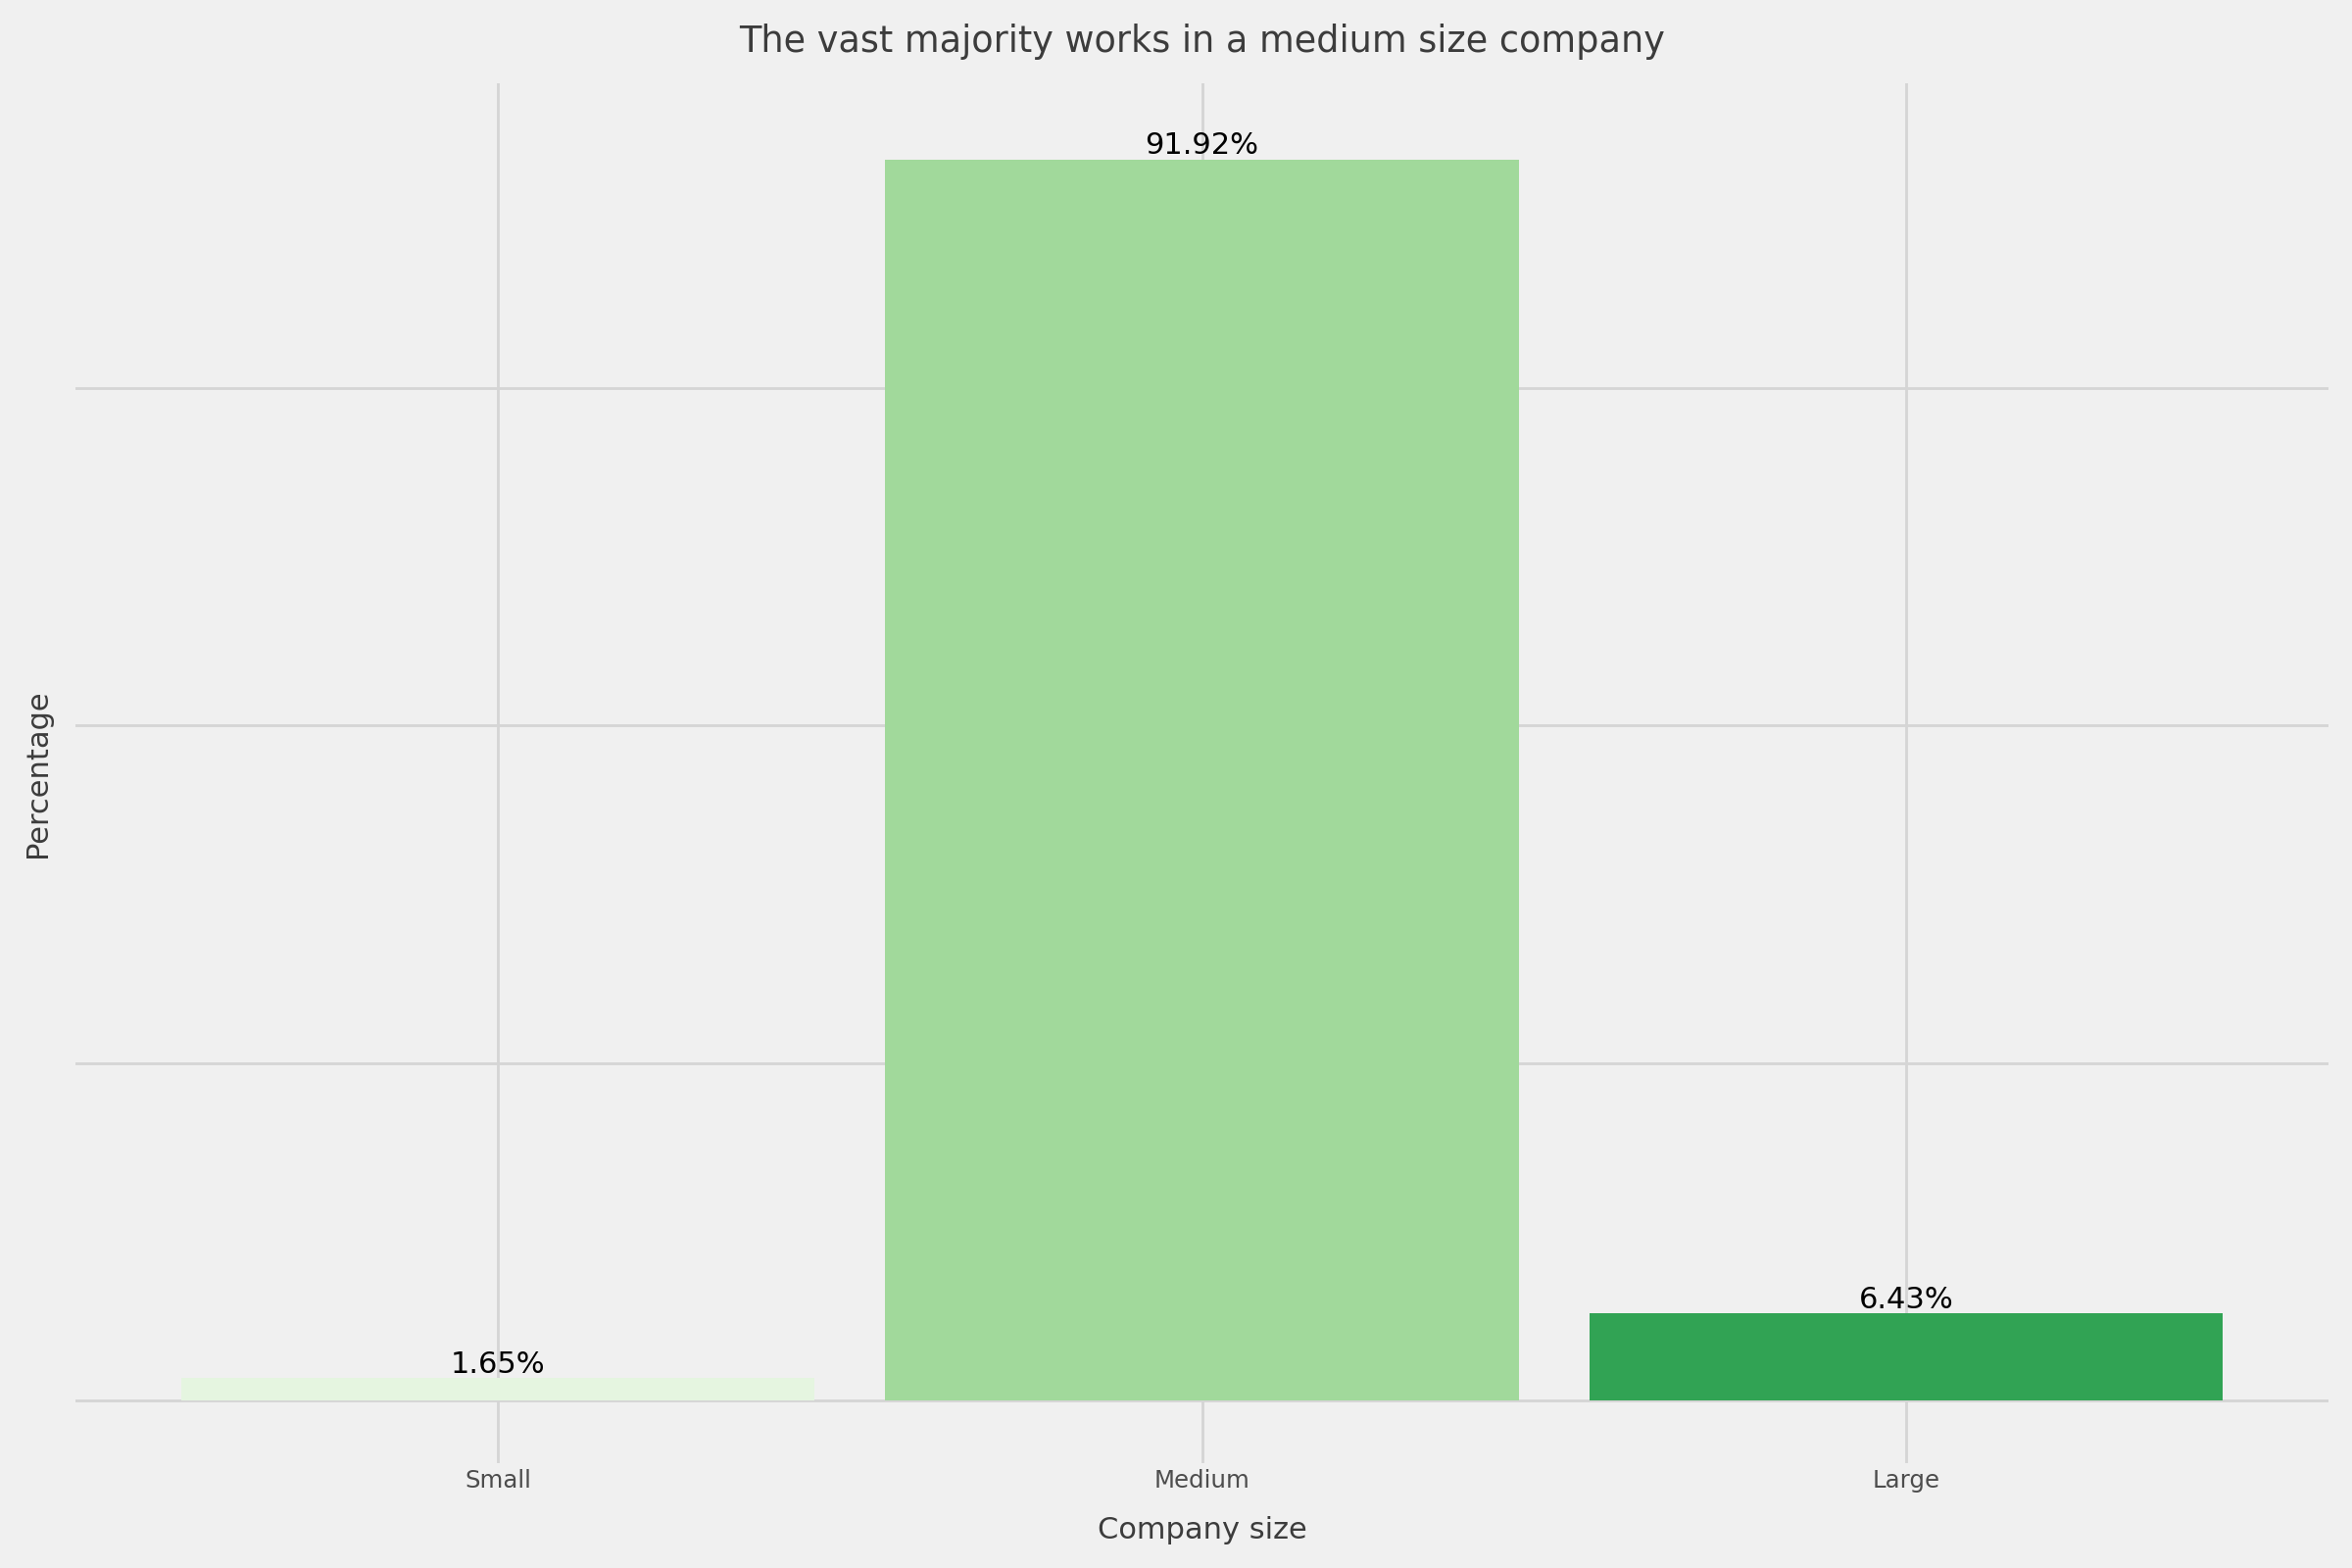

In [57]:
(
    ggplot(data, aes(x = "company_size", fill = "company_size")) # Map company_size to x-axis and passing argument fill
    + geom_bar(aes(y = after_stat("count / sum(count) *100")), stat = "count") # Create bar chart and computing percentage
    + geom_text(aes(y = after_stat("prop * 100"), label = after_stat("prop * 100"),group = 1), stat = "count", format_string = "{:.2f}%", nudge_y = 1) # Add text labels (percentages) over bars
    + scale_fill_brewer(palette = "Greens",guide = None) # Custom fill colors (greens from colorbrewer2) and remove legend
    + theme(axis_ticks_y=element_blank(),axis_text_y=element_blank(), figure_size=(12,8)) # Remove y-axis text and ticks and increase figure size
    + labs(y="Percentage", x = "Company size", title = "The vast majority works in a medium size company") # Add x and y axis labels
)

My expectation is not confirmed: the vast majority of data workers work in medium companies. Since the nature of the survey, it is impossible to define company size more precisely. Nevertheless, it might be interesting to understand the reasons behind this. I suspect a selection bias even though I can't figure out how it could have happened without another dataset sampled in a different way.

Let's see the distribution of salaries for company sizes.

2025-09-06 13:16:37 [warning  ] stat_boxplot : Removed 4 rows containing non-finite values. category=PlotnineWarning filename='c:\\Users\\Marco\\Desktop\\Basics of computing\\.data_science_salaries\\.main\\.venv\\Lib\\site-packages\\plotnine\\layer.py' lineno=293


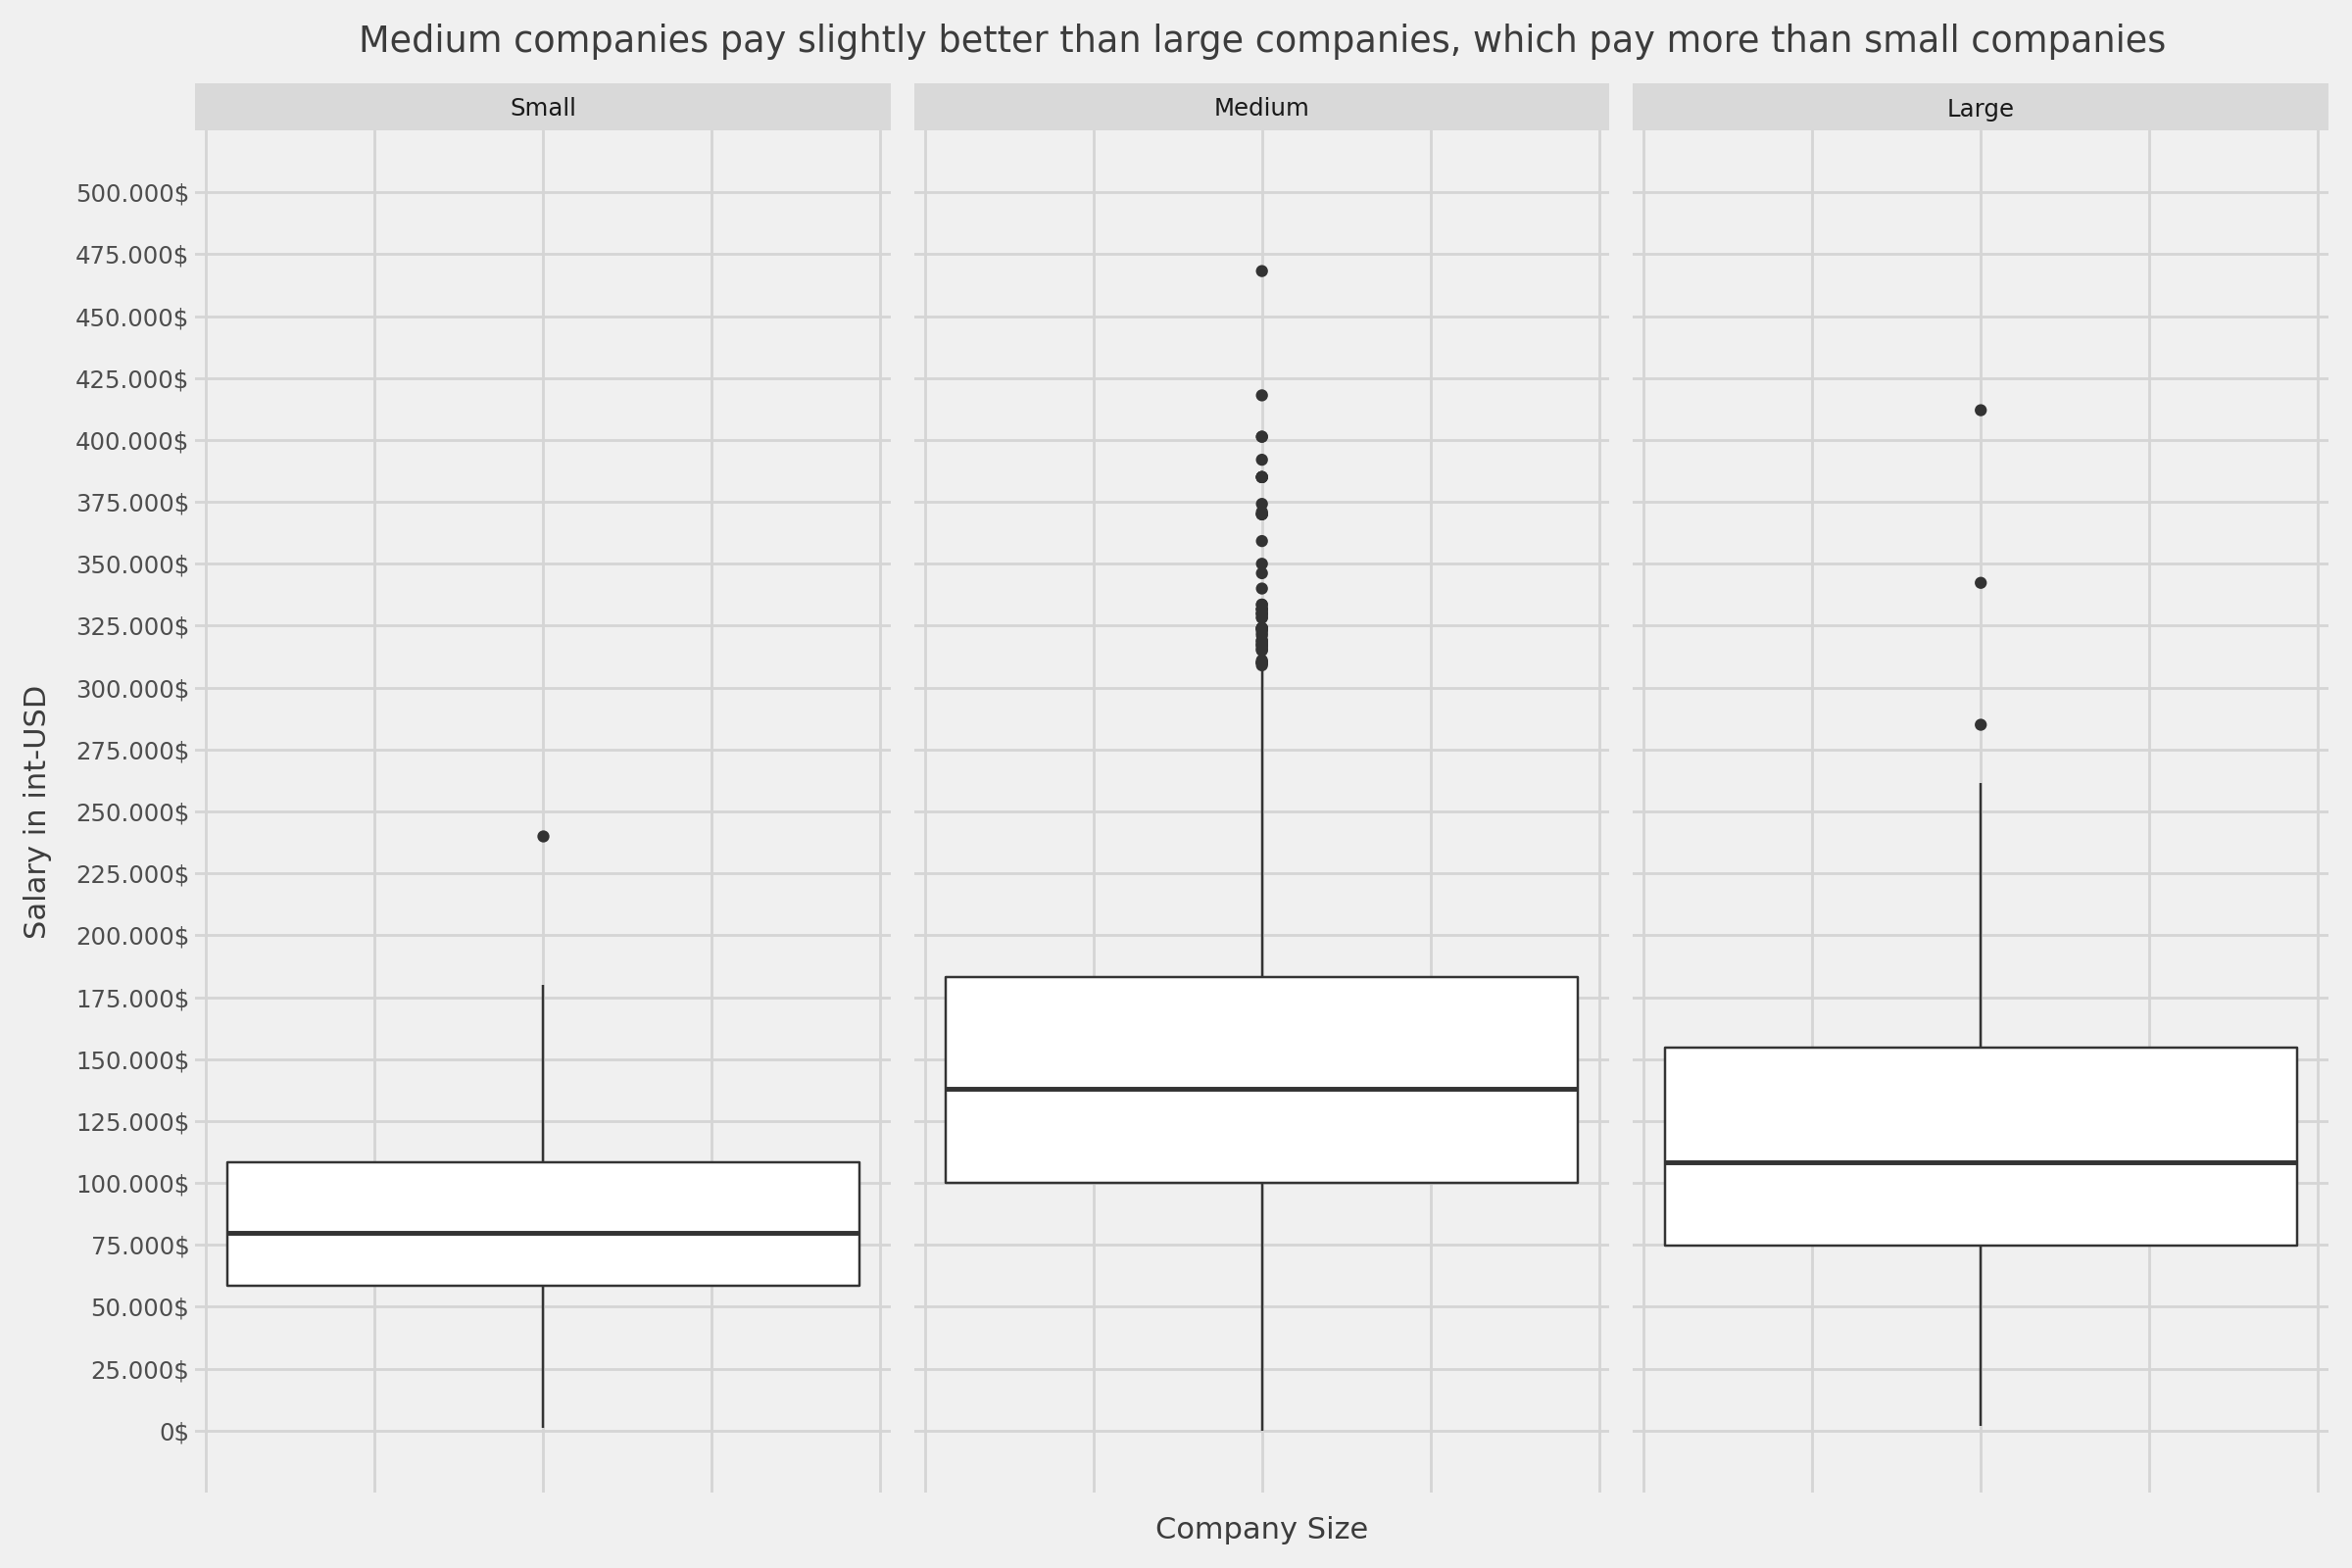

In [59]:
(
    ggplot(data  ,aes(y = "salary_in_usd")) # Map salary_in_usd to y-axis
    + geom_boxplot() # Create boxplot
    + facet_grid(cols="company_size") # Facet by company_size with title case labels
    + scale_y_continuous(limits = (0,500000), labels = lambda l: [lab_currency(x) for x in l], breaks = range(0,525000,25000)) # Formatting y-axis labels as currency
    + theme(figure_size=(12,8), axis_text_x=element_blank()) # Increase figure size and remove x-axis text
    + labs(x = "Company Size", y = "Salary in int-USD", title = "Medium companies pay slightly better than large companies, which pay more than small companies") # Add x and y axis labels
)

Another interesting fact: medium companies pay (on average) more than large companies. Maybe medium companies are paying efficiency salaries in order to attract talents and keep them, while large companies can afford to pay less since they are already established and have a strong brand. Or in medium companies specialization is not so deep, so a data worker might have to do tasks that in large companies would be done by multiple specialized roles, and this might be reflected in a higher salary.

Let's take a look at the distribution of work models.

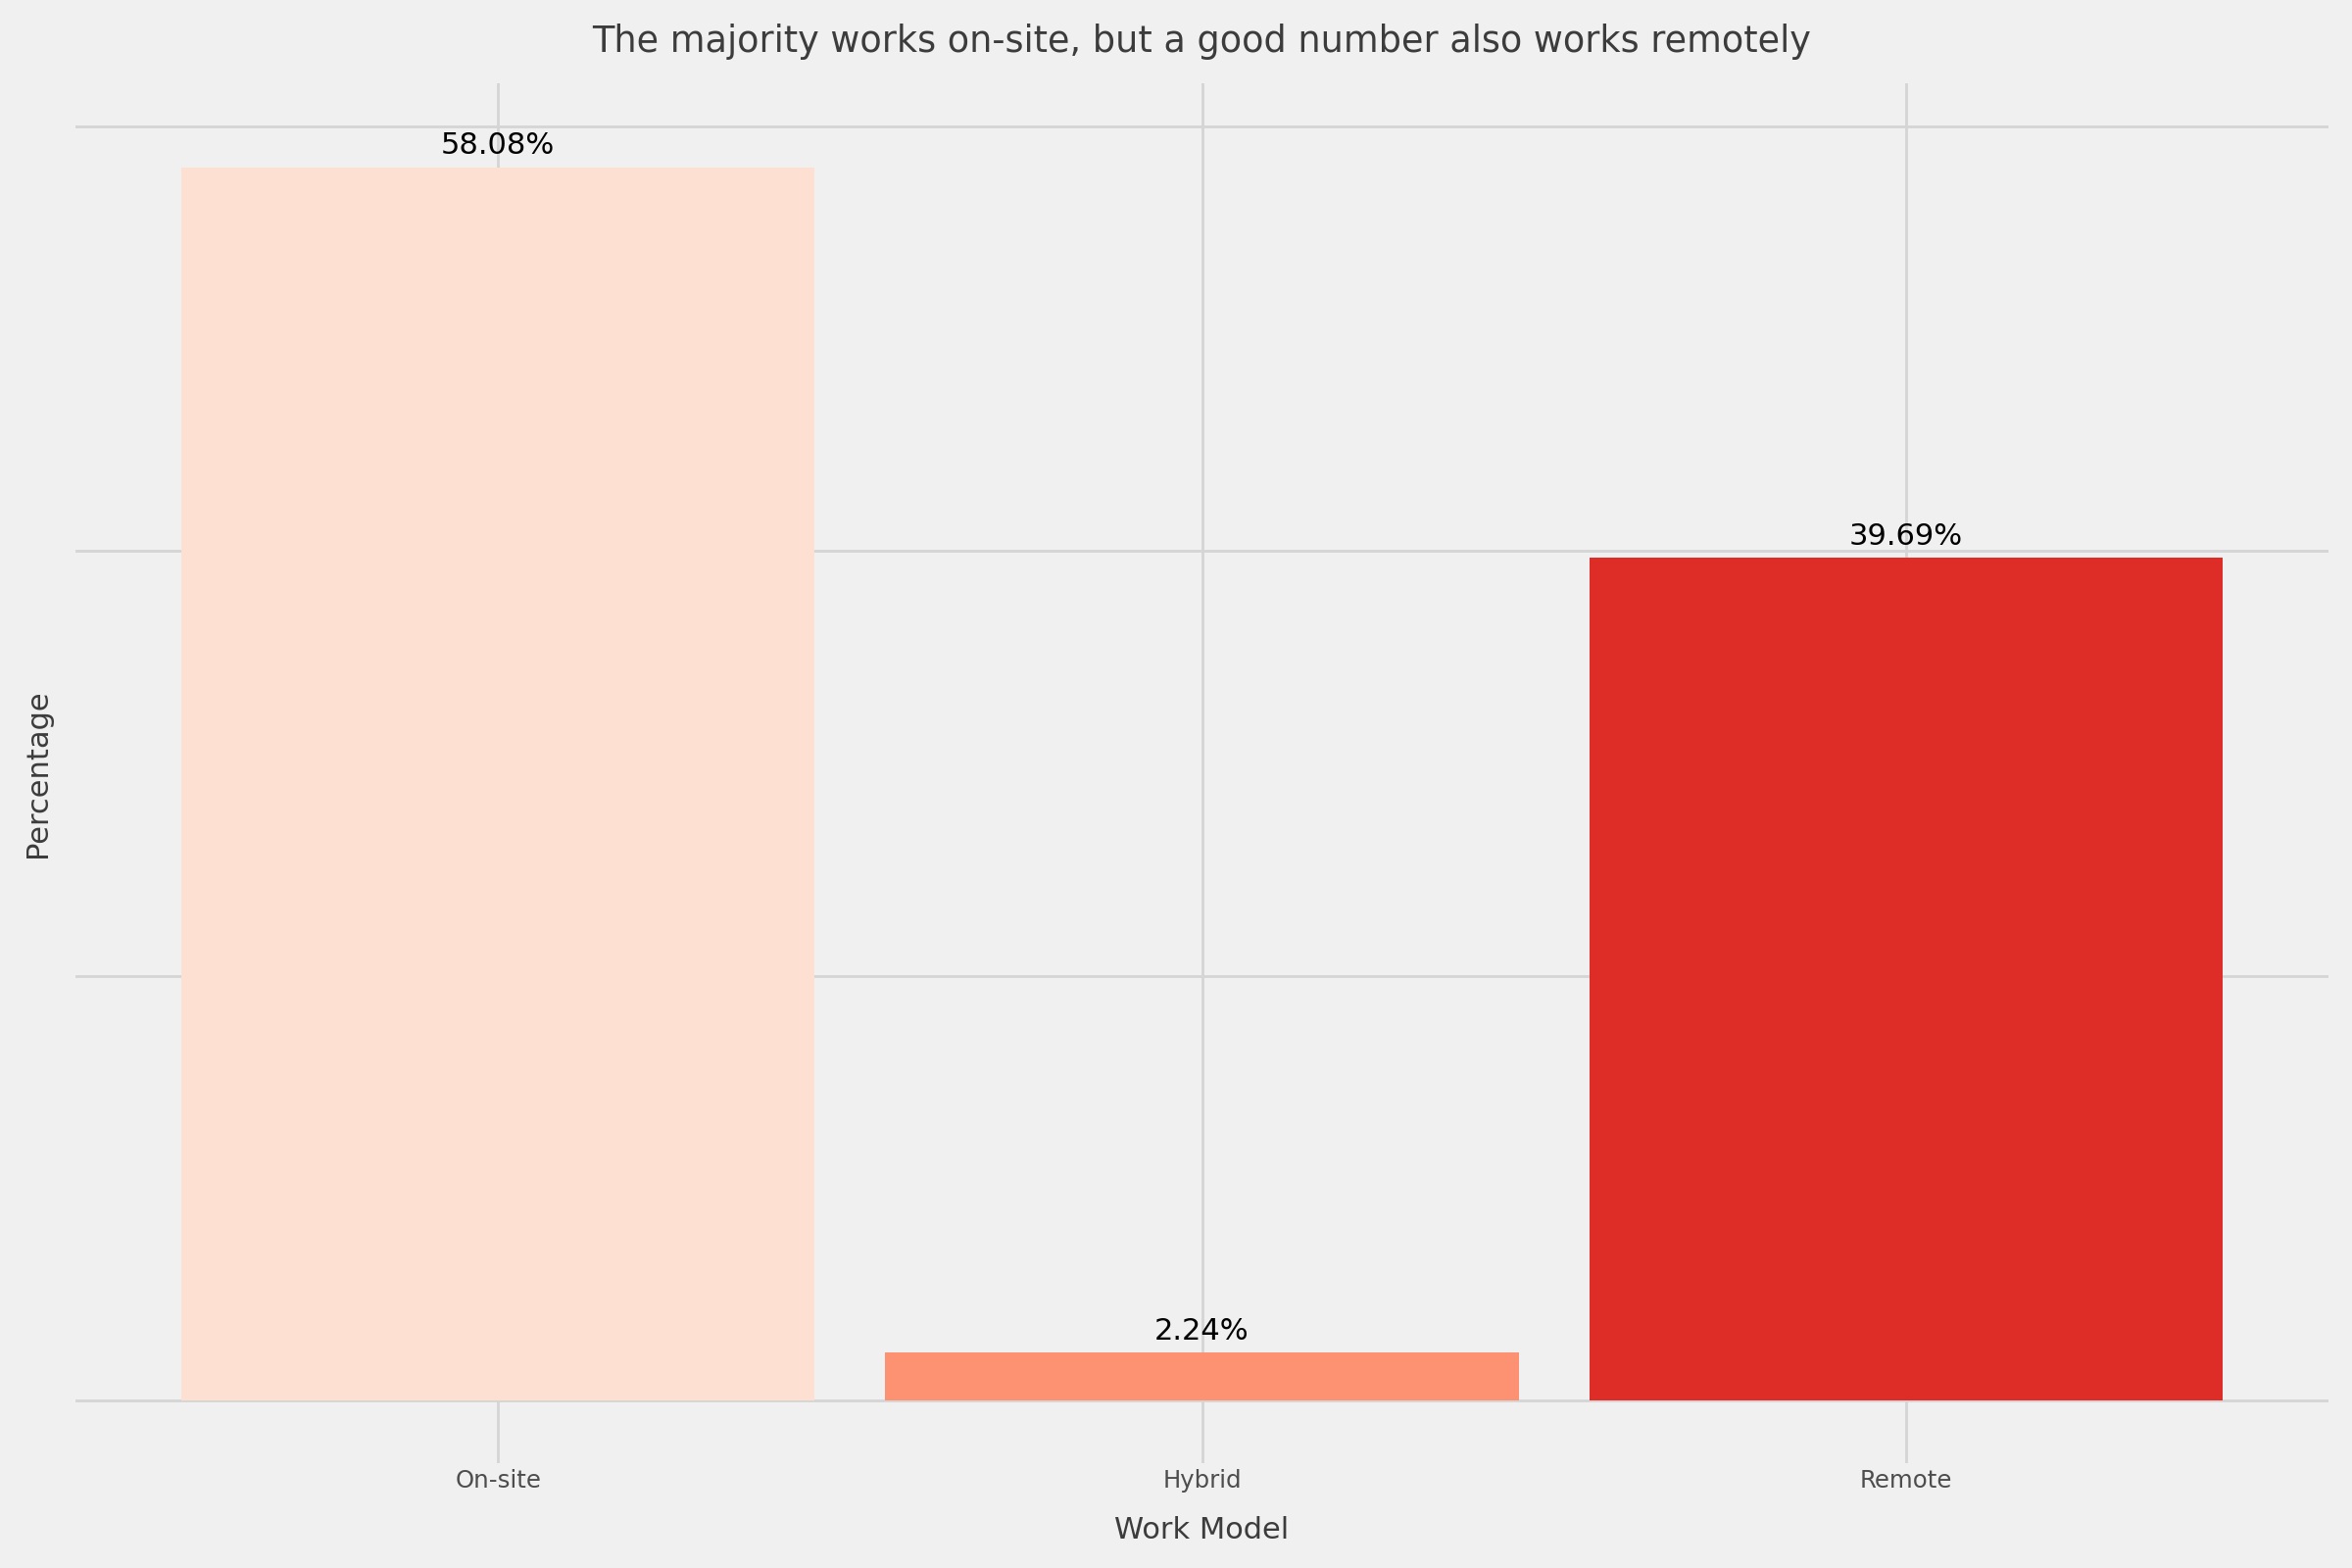

In [67]:
(
    ggplot(data, aes(x = "work_models", fill = "work_models")) # Map work_models to x-axis and pass argument fill
    + geom_bar(aes(y = after_stat("count / sum(count) * 100"))) # Create bar chart and compute percentage
    + geom_text(aes(y = after_stat("prop*100"), label = after_stat("prop *100"), group = 1), stat = "count", format_string = "{:.2f}%", nudge_y = 1) # Compute and add text labels (percentages) over bars 
    + scale_fill_brewer(palette="Reds",guide = None) # Custom fill colors (reds from colorbrewer2) and remove legend
    + labs(x = "Work Model", y = "Percentage", title = "The majority works on-site, but a good number also works remotely") # Add x and y axis labels
    + theme(figure_size=(12,8), axis_ticks_y=element_blank(), axis_text_y=element_blank()) # Remove y-axis text and ticks and increase figure size
)

The vast majority of data workers work in a on-site model, with a small percentage working fully remote. Maybe there are differences between roles and company sizes.

In [61]:
remote_prop_job_title = data.groupby(["company_size","job_title"])["work_models"].value_counts(normalize=True).reset_index(name="percentage")
remote_prop_job_title["percentage"] = remote_prop_job_title["percentage"] * 100

2025-09-06 13:16:50 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_28164\3357666172.py lineno=1


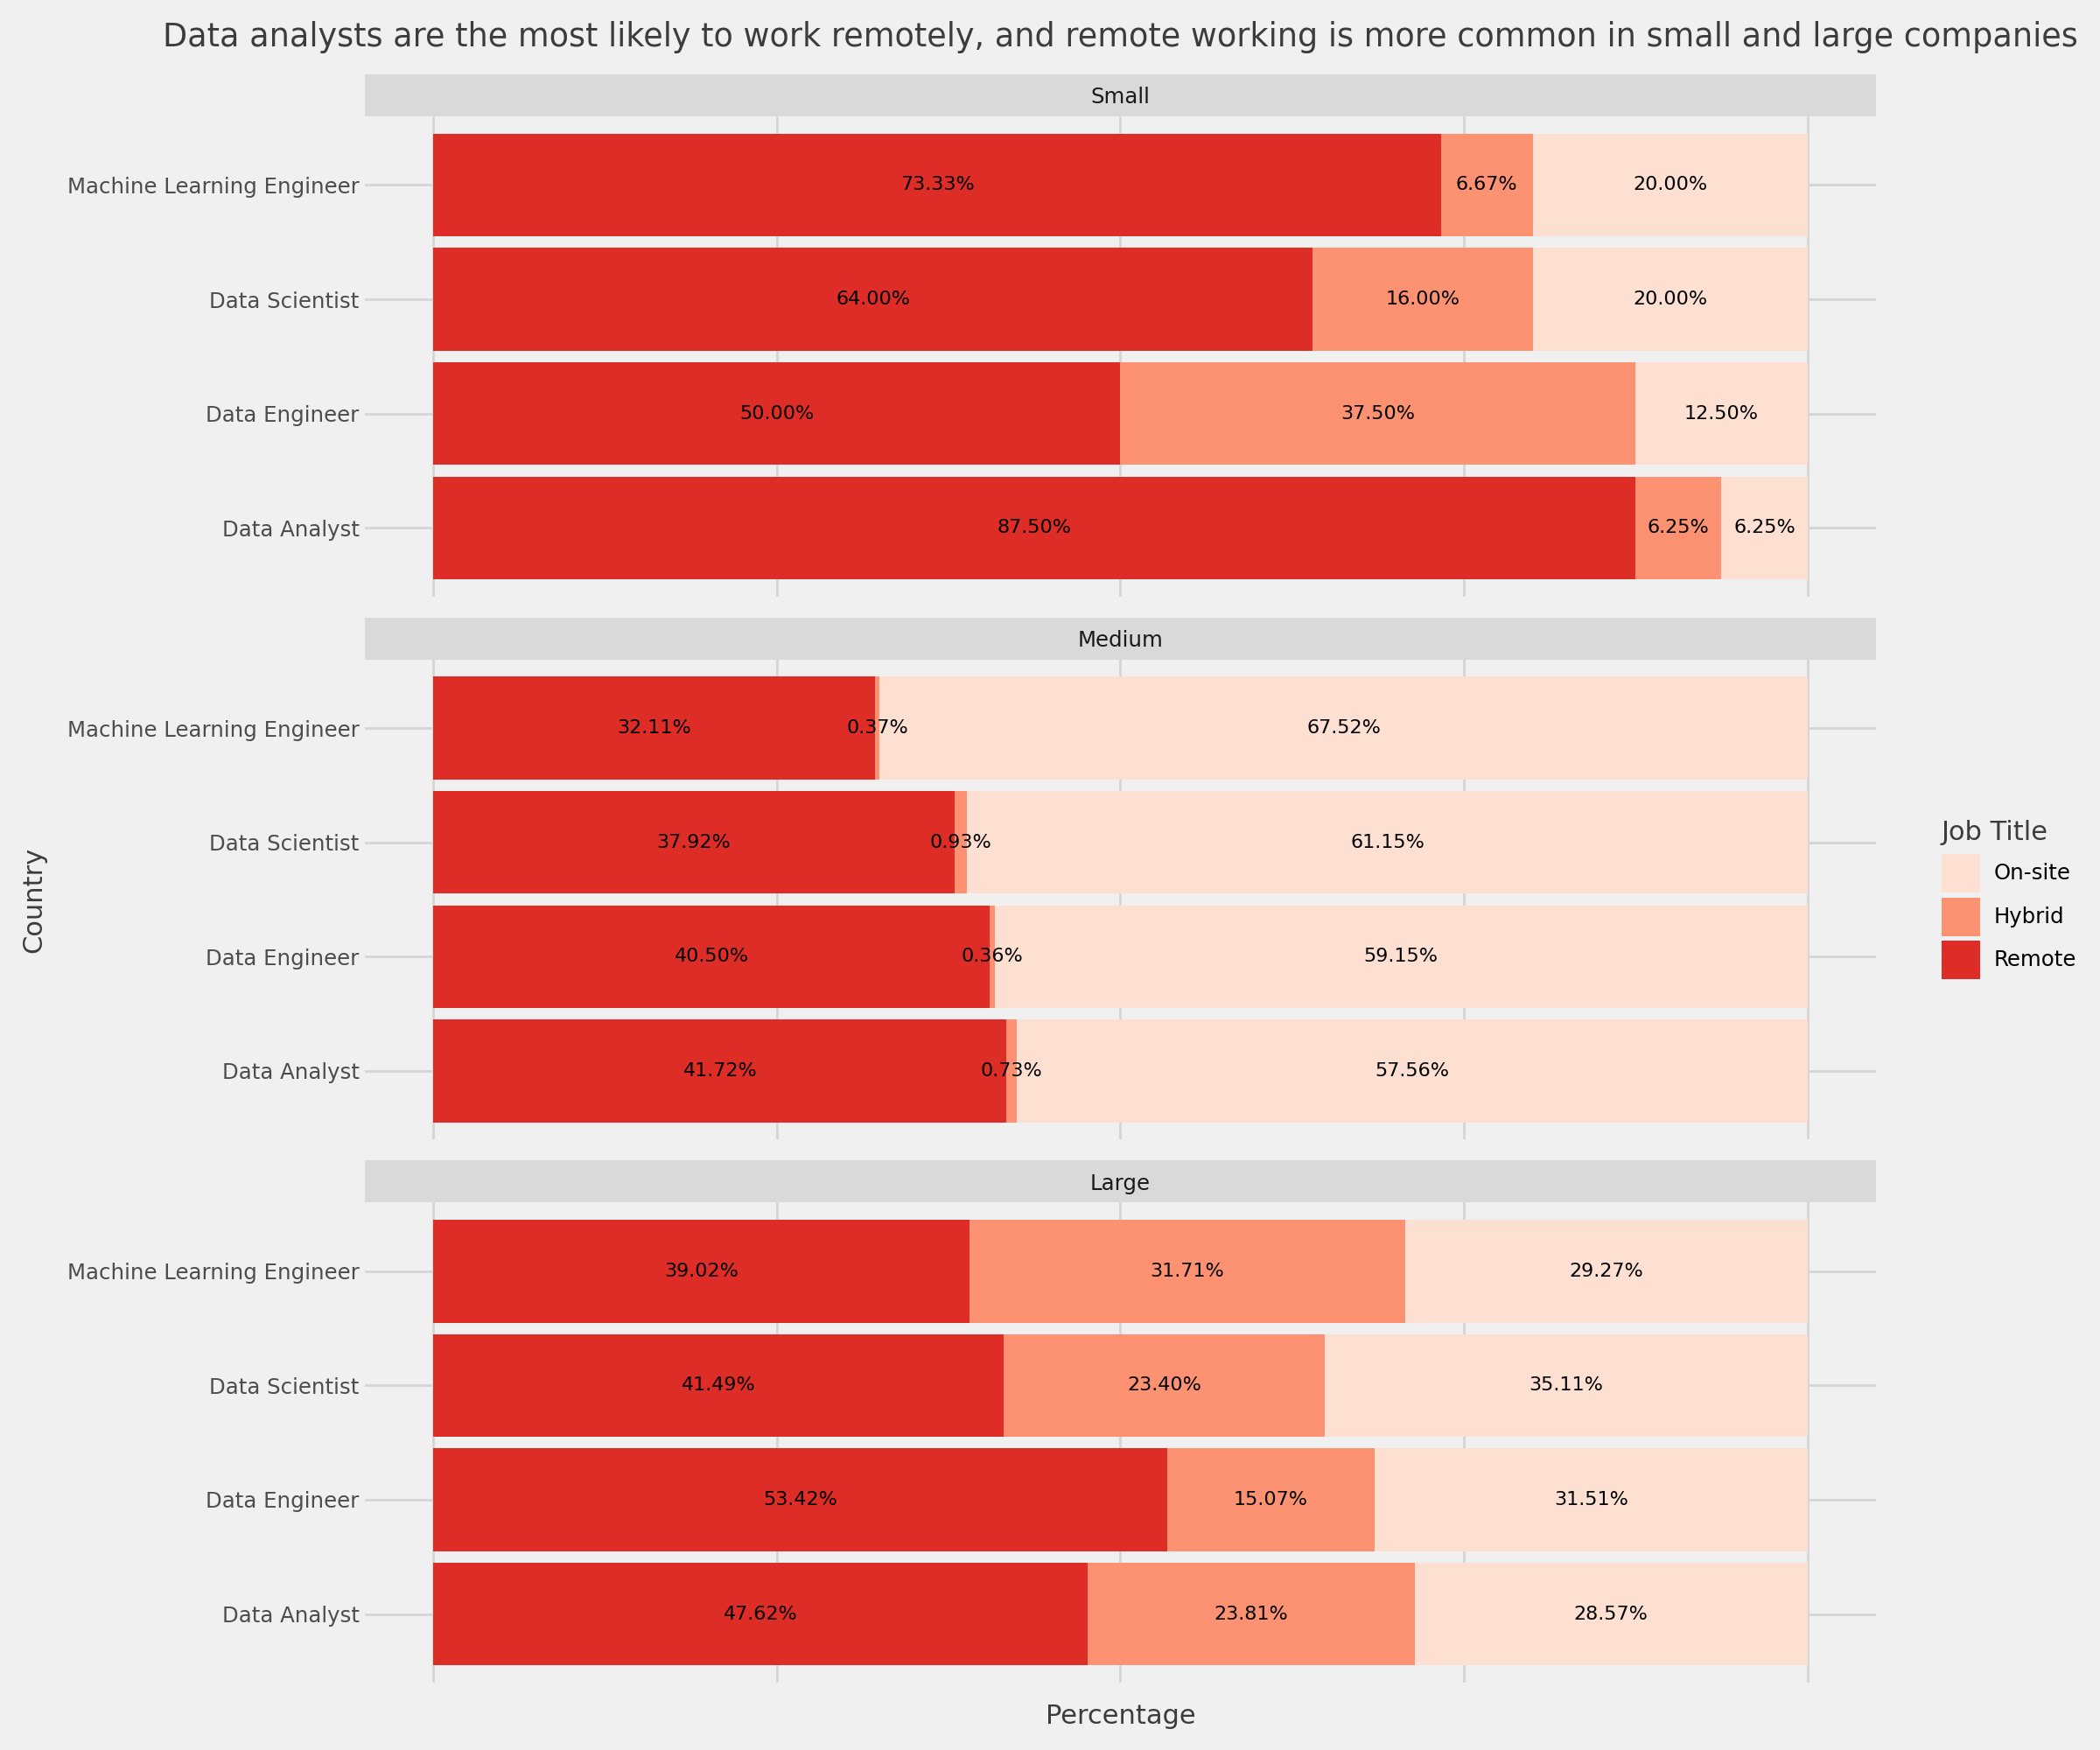

In [69]:
(
    ggplot(remote_prop_job_title,aes(x="job_title", y="percentage", fill = "work_models")) # Map job_title to x-axis and work_models to fill
    + geom_col() # Create bar chart
    + geom_text(aes(label = "percentage"), format_string = "{:.2f}%",position=position_stack(vjust=0.5),size = 8) # Add text labels (percentages) over bars
    + scale_fill_brewer(palette = "Reds") # Custom fill colors and remove legend
    + theme(figure_size=(12,10),axis_text_x=element_blank())
    + labs(y = "Percentage", x = "Country", fill = "Job Title", title = "Data analysts are the most likely to work remotely, and remote working is more common in small and large companies") # Add x and y axis labels
    + coord_flip() # Flip coordinates
    + facet_wrap("company_size", ncol=1) # Facet by company_size with title case labels
)

Data analysts and data engineers are more likely to work remotely, while data scientists and machine learning engineers have a higher percentage of on-site work. Another interesting fact is that fully remote positions are more common in small and large companies, while medium companies have a higher percentage of on-site work.

Let's compute the median salary by country and draw choropleth map.

In [63]:
salary_median = data.groupby("country", as_index = False)["salary_in_usd"].median().reset_index() # Compute median salary by country
salary_median = merge(salary_median, gdf.loc[:,["country","geometry"]], left_on ="country", right_on = "country",how = "right").drop_duplicates()

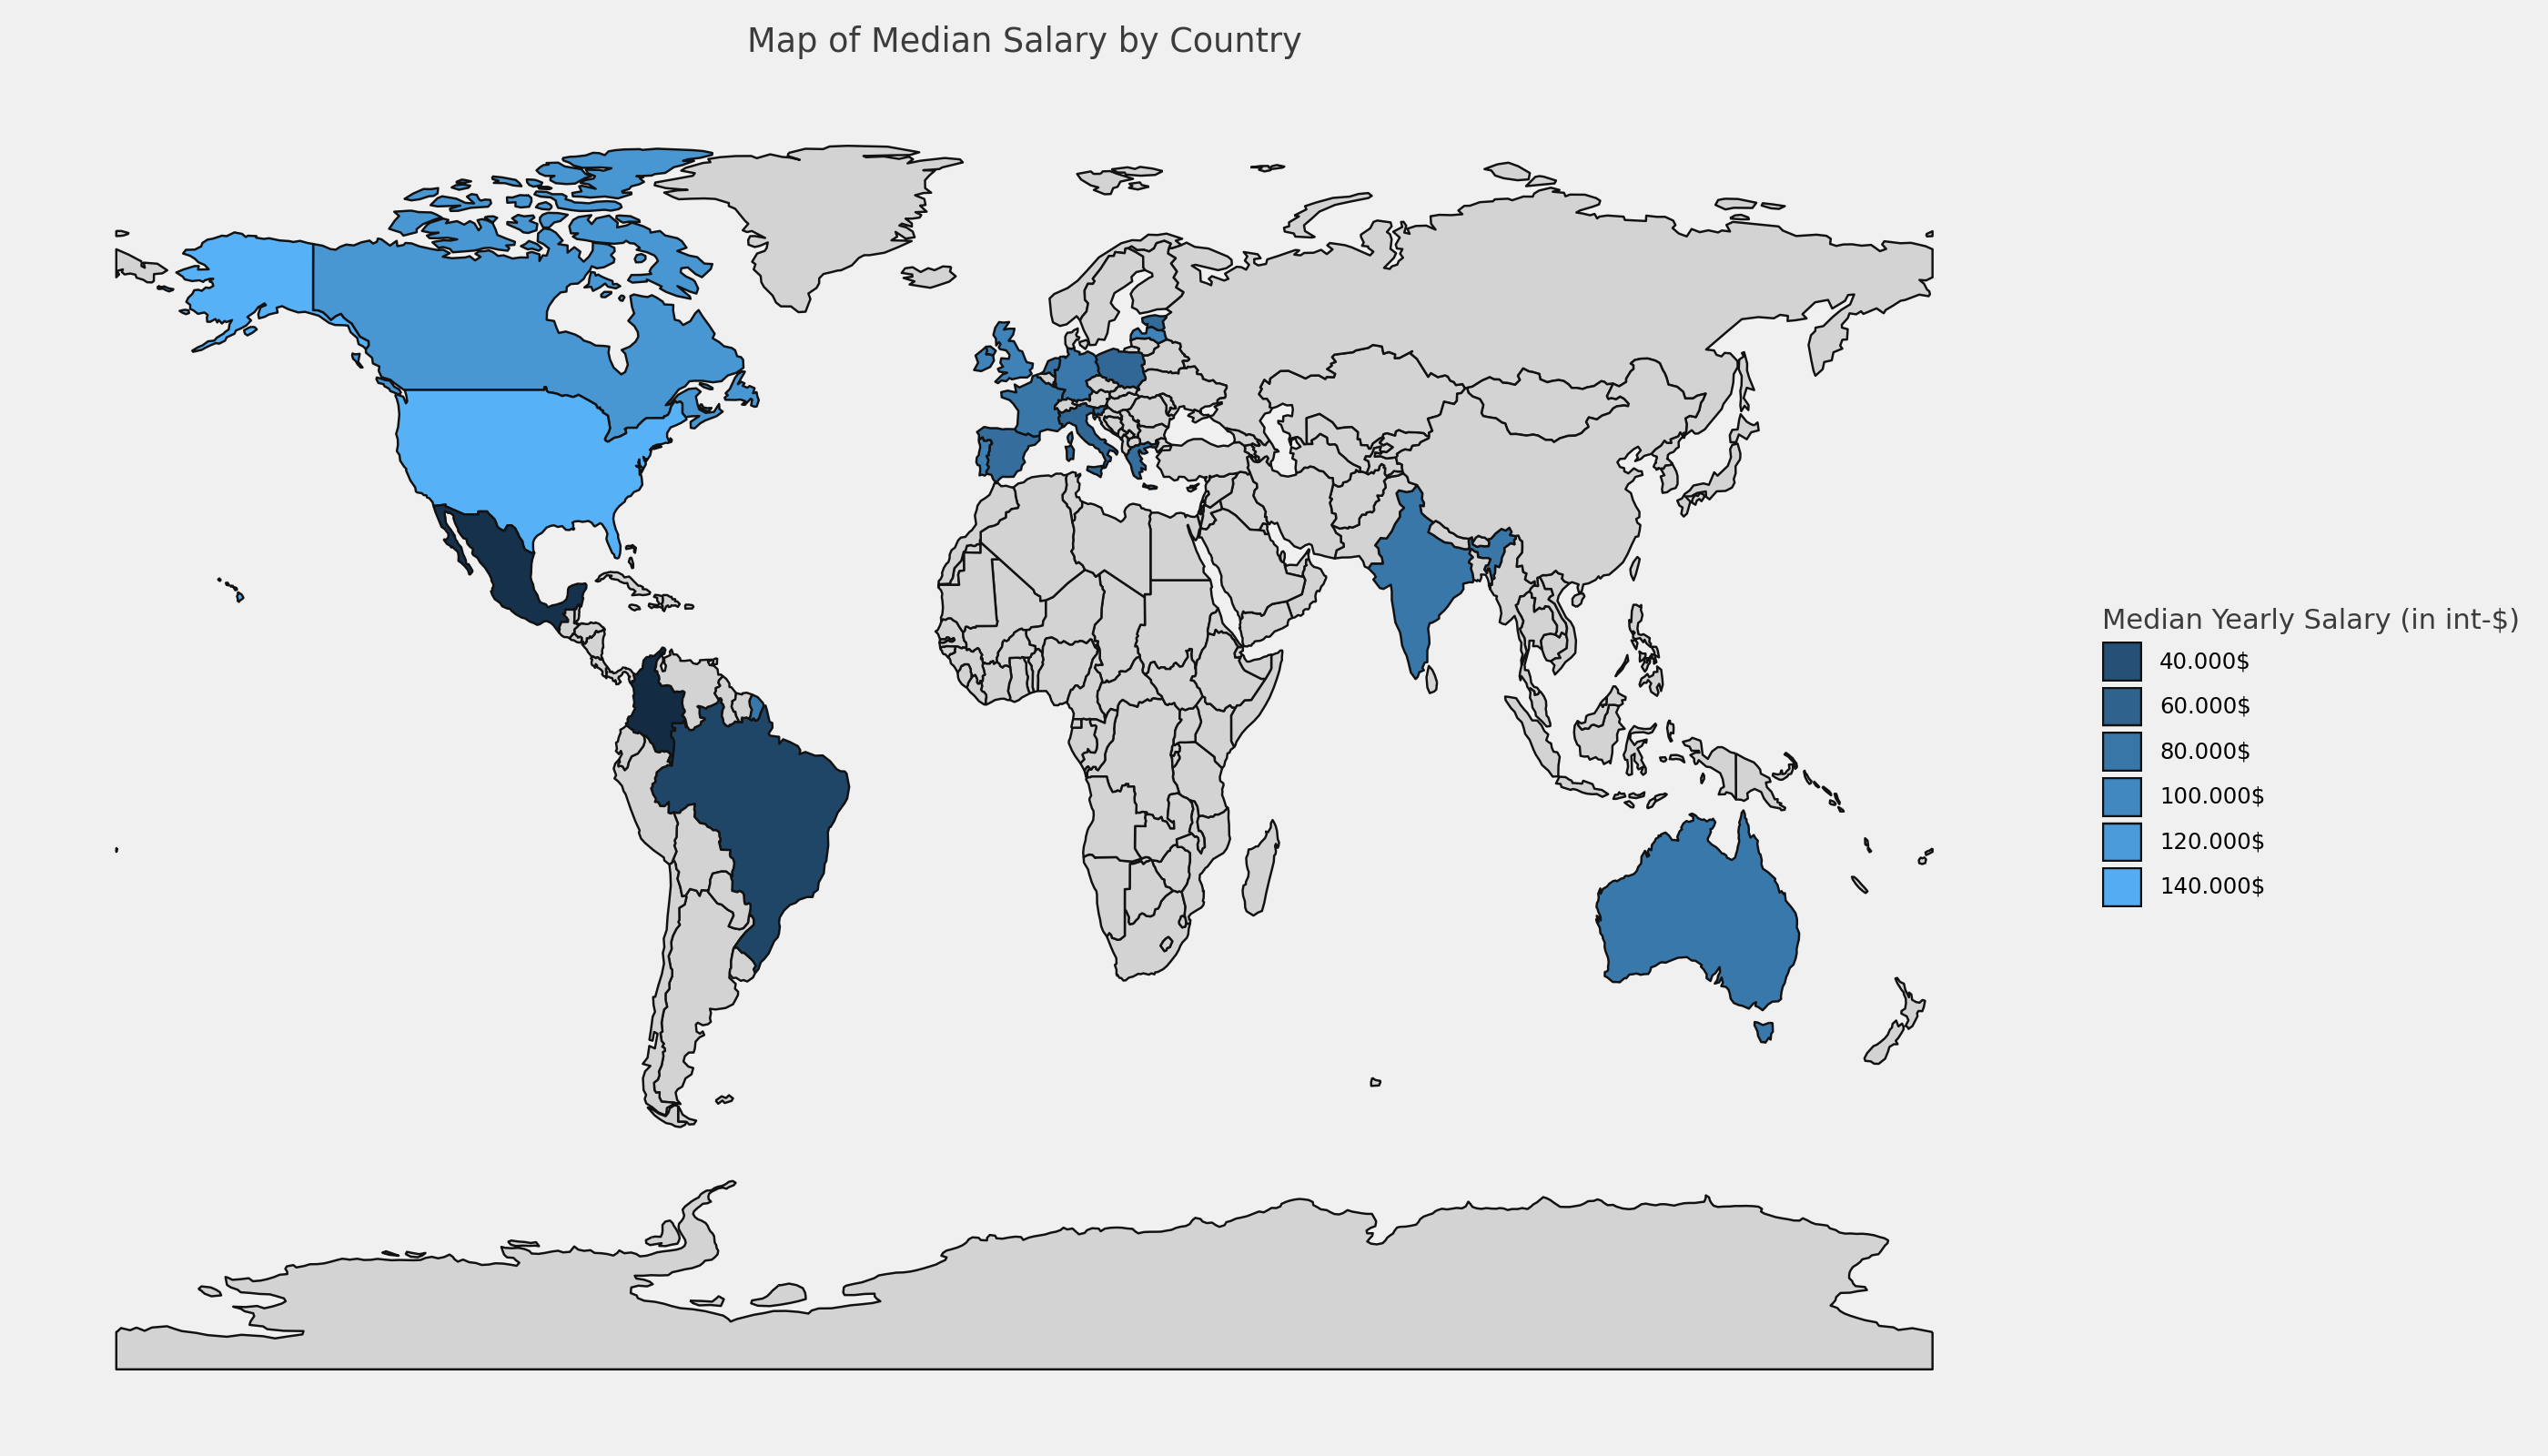

In [64]:
(
    ggplot(salary_median, aes(fill = "salary_in_usd")) # Pass fill aesthetic
    + geom_map() # Create map visualization
    + theme(figure_size=(14,8), axis_text_x=element_blank(), axis_text_y=element_blank(),panel_grid=element_blank()) # Customize figure size, and remove axis text and grid
    + scale_fill_gradient(name = "Median Yearly Salary (in int-$)", # Define fill gradient
                          guide = "legend", # Customize legend
                          na_value="lightgrey", # Define color for missing values
                          labels=lambda l: [lab_currency(x) for x in l], # Format labels using lab_currency function
                          breaks = range(40000,160000,20000)) # Define breaks for color scale
    + labs(title = "Map of Median Salary by Country") # Add title
)

The best countries remain the United States and Canada, with a median salary of around 150k int-USD. Regarding Europe, the best countries are, in order, UK, Portugal and Germany.

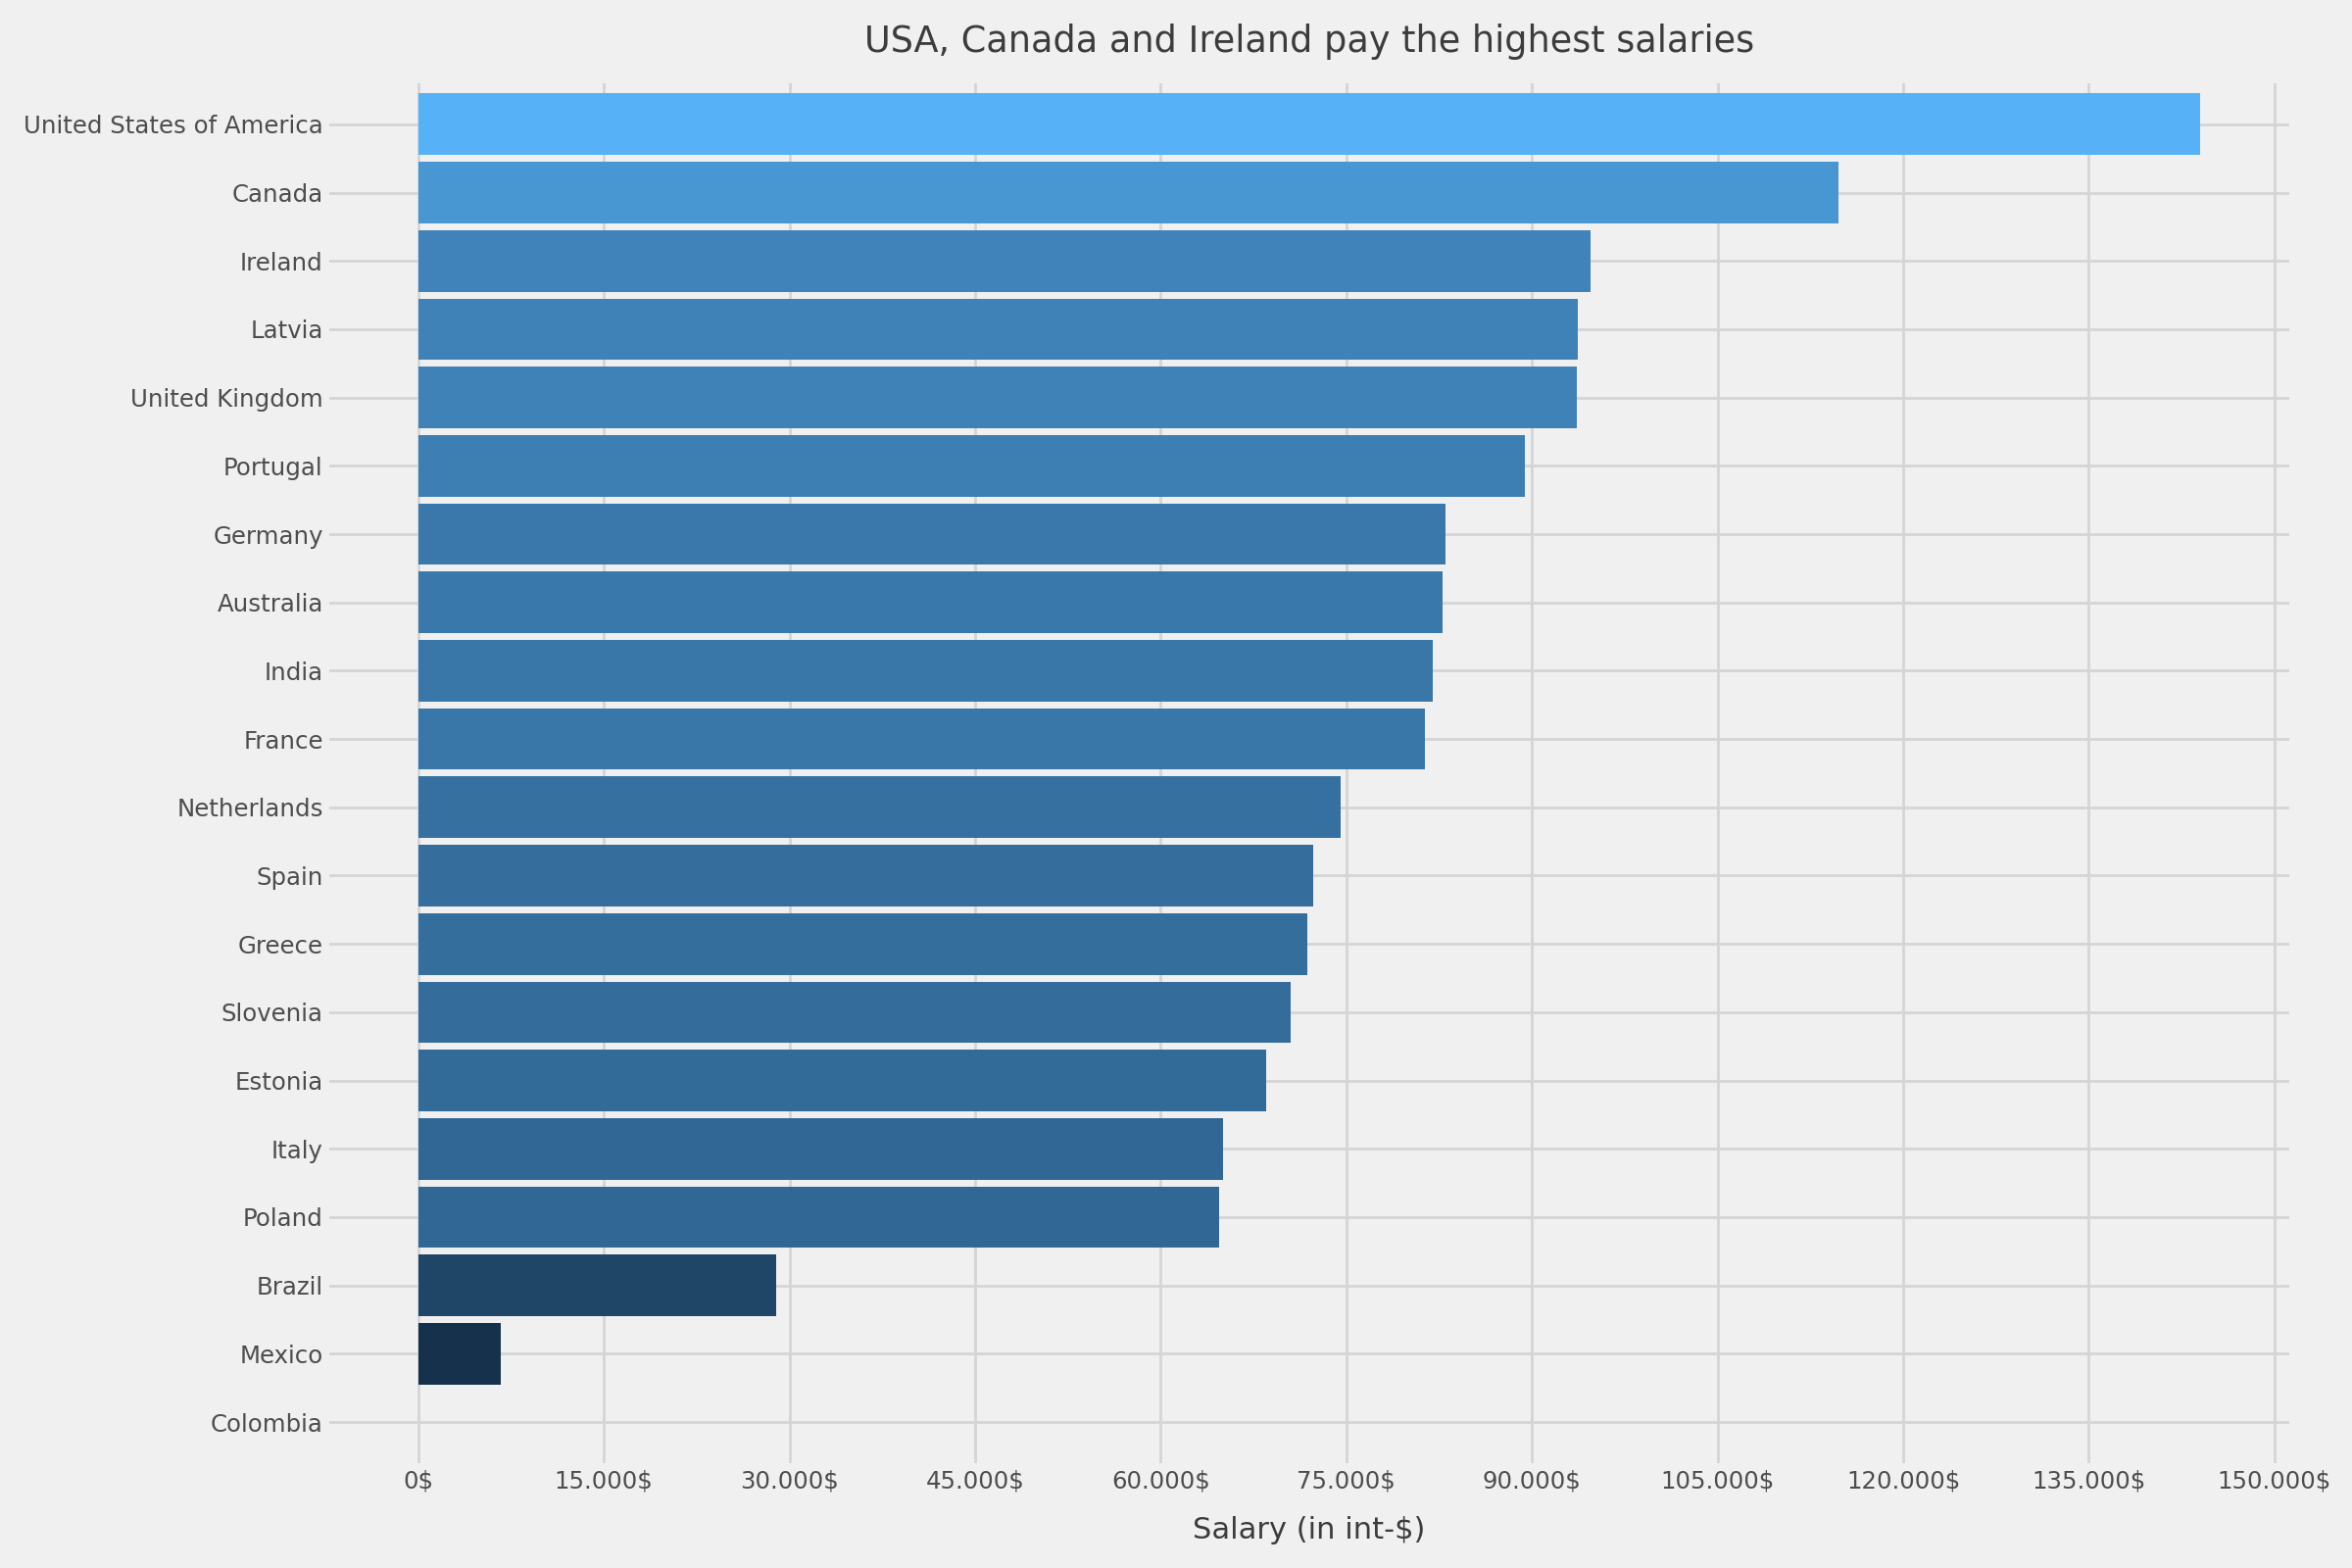

In [70]:
(
    ggplot(salary_median.dropna(), aes(x="reorder(country,salary_in_usd)", y="salary_in_usd"))  # Map x: country names reordered by salary, y: median salary
    + geom_col(aes(fill="salary_in_usd"))  # Colored bars by salary value
    + theme(figure_size=(12,8))  # Set figure size
    + coord_flip()  # Flip axes
    + labs(x="", y="Salary (in int-$)", title = "USA, Canada and Ireland pay the highest salaries")  # Axis labels
    + scale_y_continuous(
        breaks=range(0,165000,15000),  # y-axis ticks every 15k
        labels=lambda l: [lab_currency(x) for x in l],  # Format y-axis labels
    )
    + scale_fill_gradient(guide = None)  # Gradient fill for salary and remove legend
)

Regarding the salary distribution per country the following plot is interesting. 

2025-09-06 13:20:12 [warning  ] stat_boxplot : Removed 4 rows containing non-finite values. category=PlotnineWarning filename='c:\\Users\\Marco\\Desktop\\Basics of computing\\.data_science_salaries\\.main\\.venv\\Lib\\site-packages\\plotnine\\layer.py' lineno=293


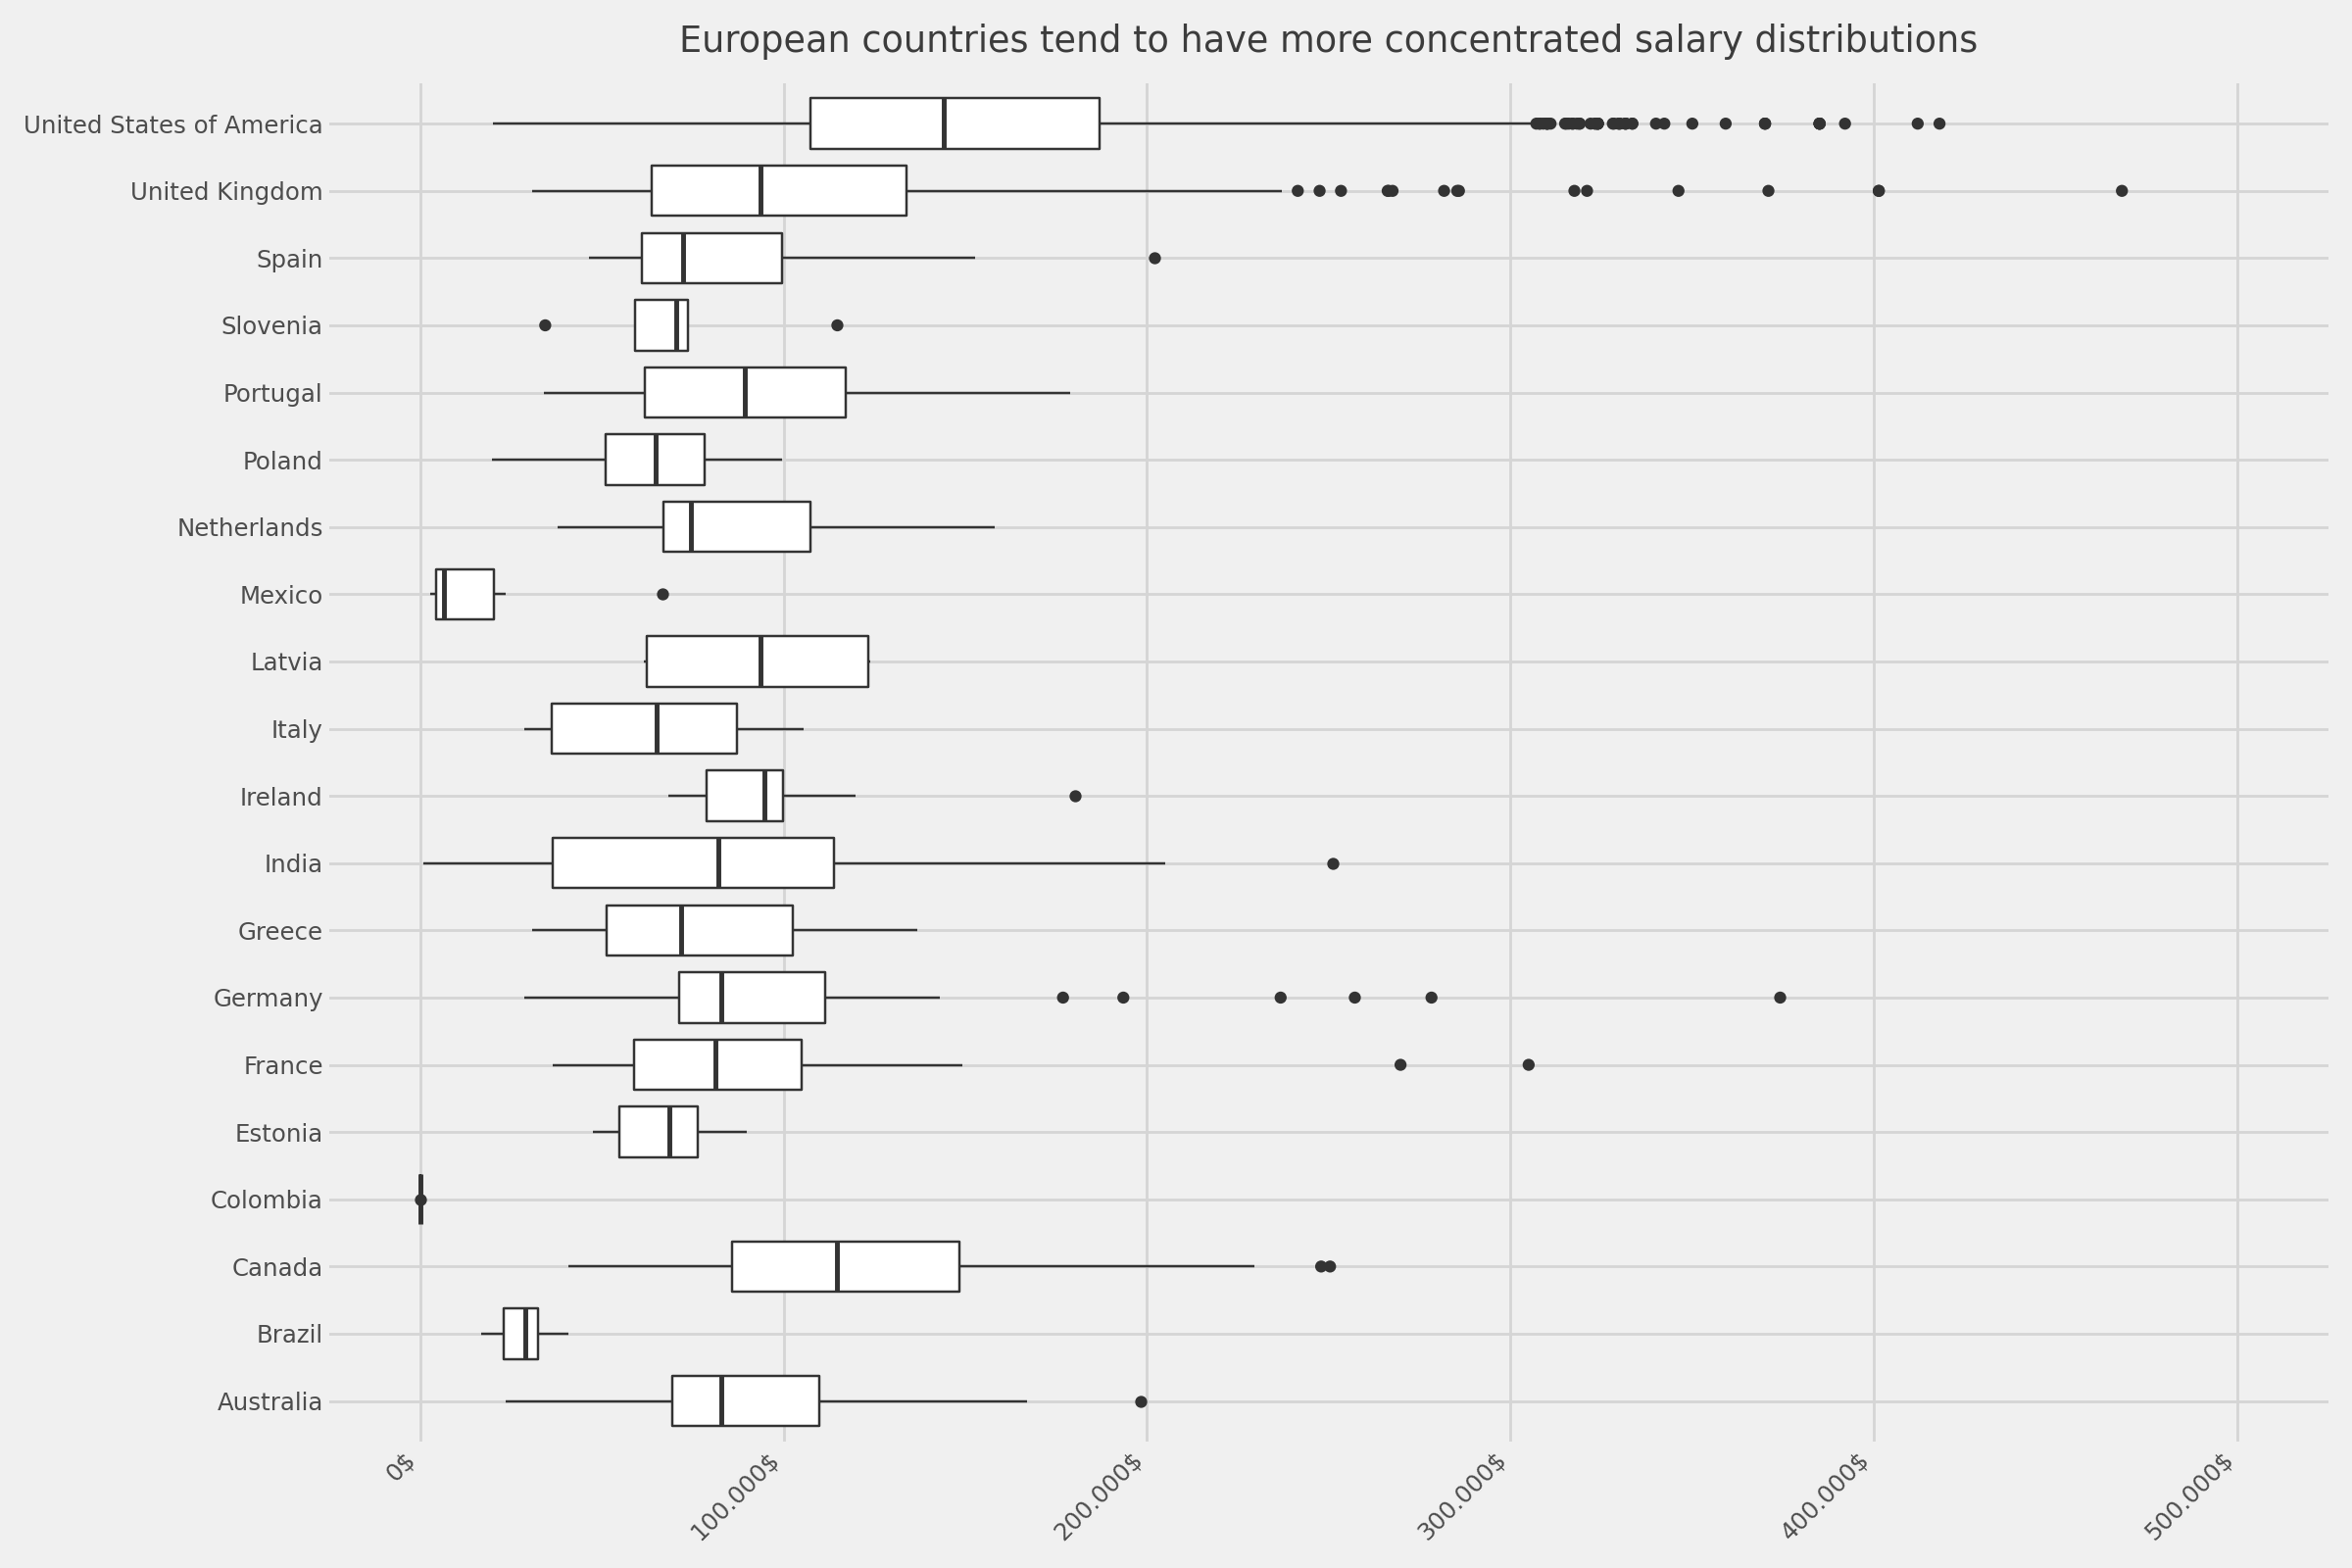

In [71]:
(
    ggplot(data, aes(x='country', y='salary_in_usd')) # Map x: company location, y: salary in USD
    + geom_boxplot() # Create boxplot
    + scale_y_continuous(limits = (0,500000), labels = lambda l: [lab_currency(x) for x in l]) # Format y-axis labels
    + theme(figure_size=(12, 8), axis_text_x=element_text(rotation=45, ha='right')) # Customize theme
    + coord_flip() # Flip coordinates
    + labs(x = "", y = "", title = "European countries tend to have more concentrated salary distributions") # Add x and y axis labels
)

As we can see, european countries tend to have a lower salary dispersion, while countries like the US and Canada have a higher dispersion. This might be due to the fact that in Europe there are more regulations regarding salaries and workers' rights, which might lead to a lower dispersion.

Let's take a look at the distribution of remote working in different countries.

In [72]:
remote_prop = data.groupby("country")["work_models"].apply(lambda x: round(len(x[x == "Remote"])/len(x) * 100, 2)) # Compute percentage of remote jobs by country
remote_prop = merge(remote_prop,gdf.loc[:,"country":"geometry"], how = "right", left_on = "country", right_on = "country") # Merge with geometrical data

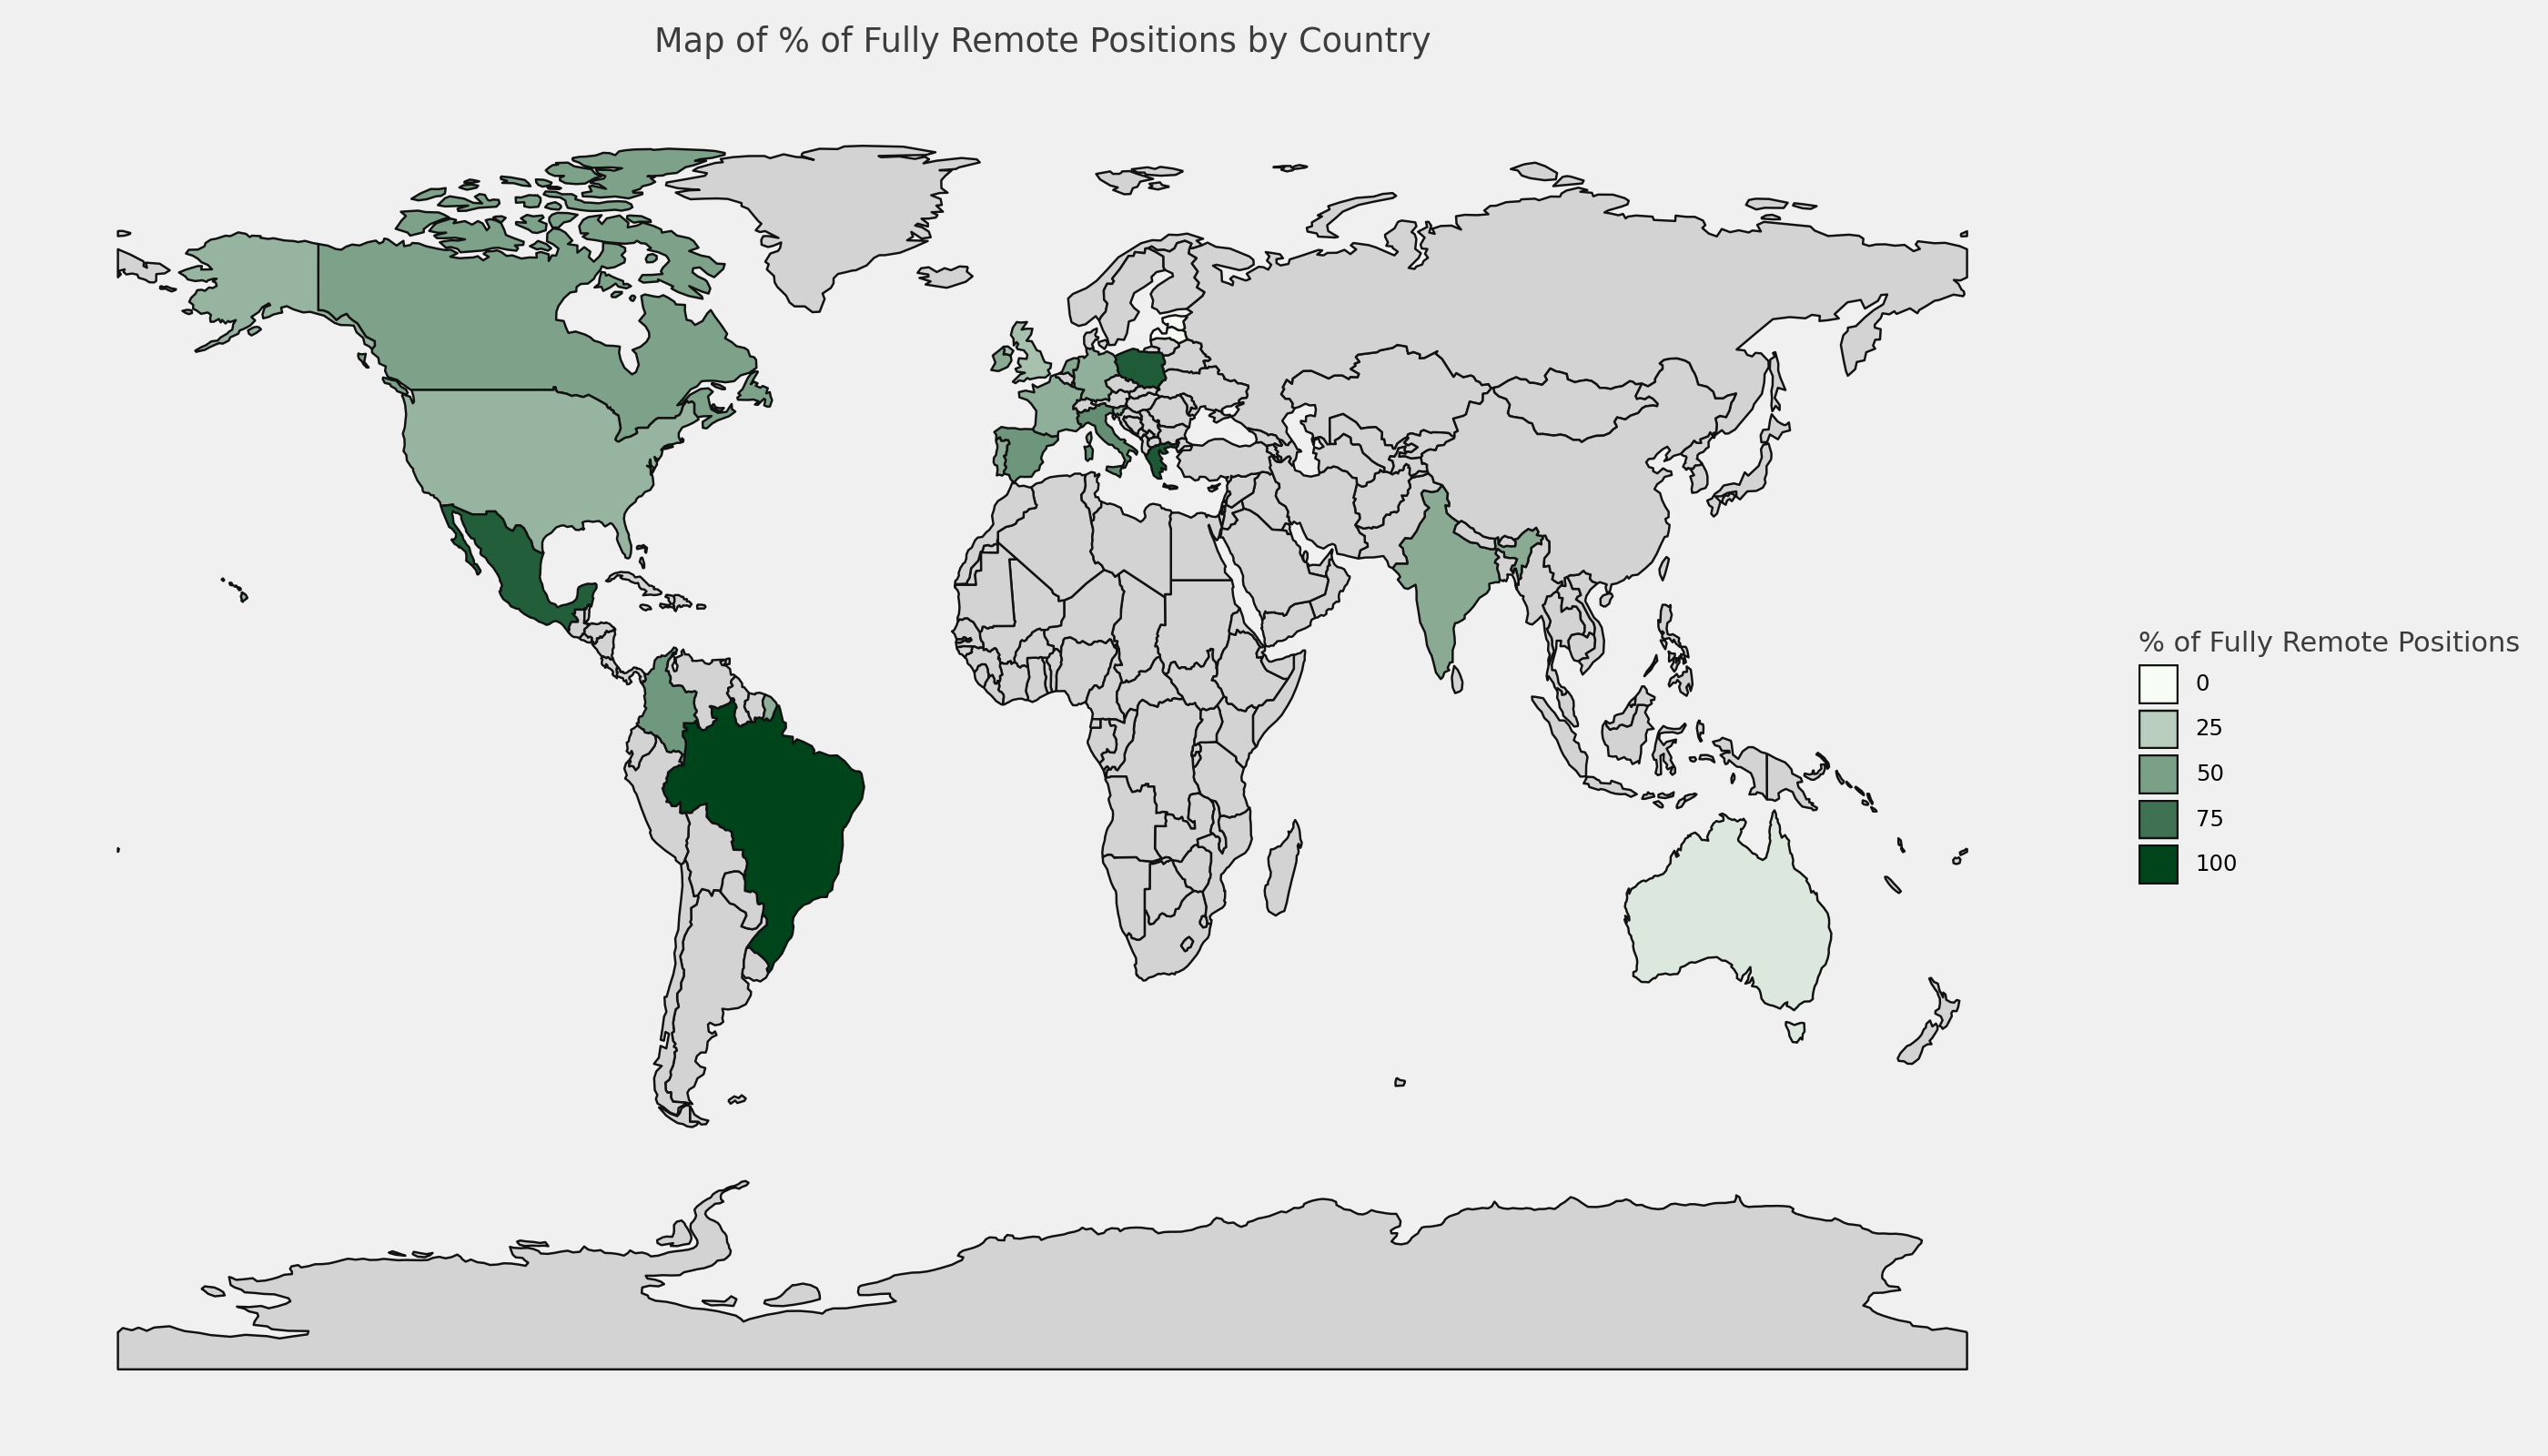

In [73]:
(      
    ggplot(remote_prop, aes(fill = "work_models")) # Map fill aesthetic to work_models
        + geom_map() # Create map visualization
        + theme(figure_size=(14,8), # Customize figure size
                axis_text_x=element_blank(), # Remove x-axis text
                axis_text_y=element_blank(), # Remove y-axis text
                panel_grid=element_blank()) # Remove panel grid
        + scale_fill_gradient(low = "#f7fcf5", high="#00441b", # Set color range
                              guide = "legend", # Customize legend
                              na_value="lightgrey") # Define color for missing values
        + labs(fill = "% of Fully Remote Positions", title = "Map of % of Fully Remote Positions by Country") # Add title and fill label
)

The best countries regarding remote working are Brazil, Greece, Poland, Mexico, Italy and Spain, but this might be due to the low number of occurrences. Regarding the two well documented USA and UK, we have a percentage of around 30%.

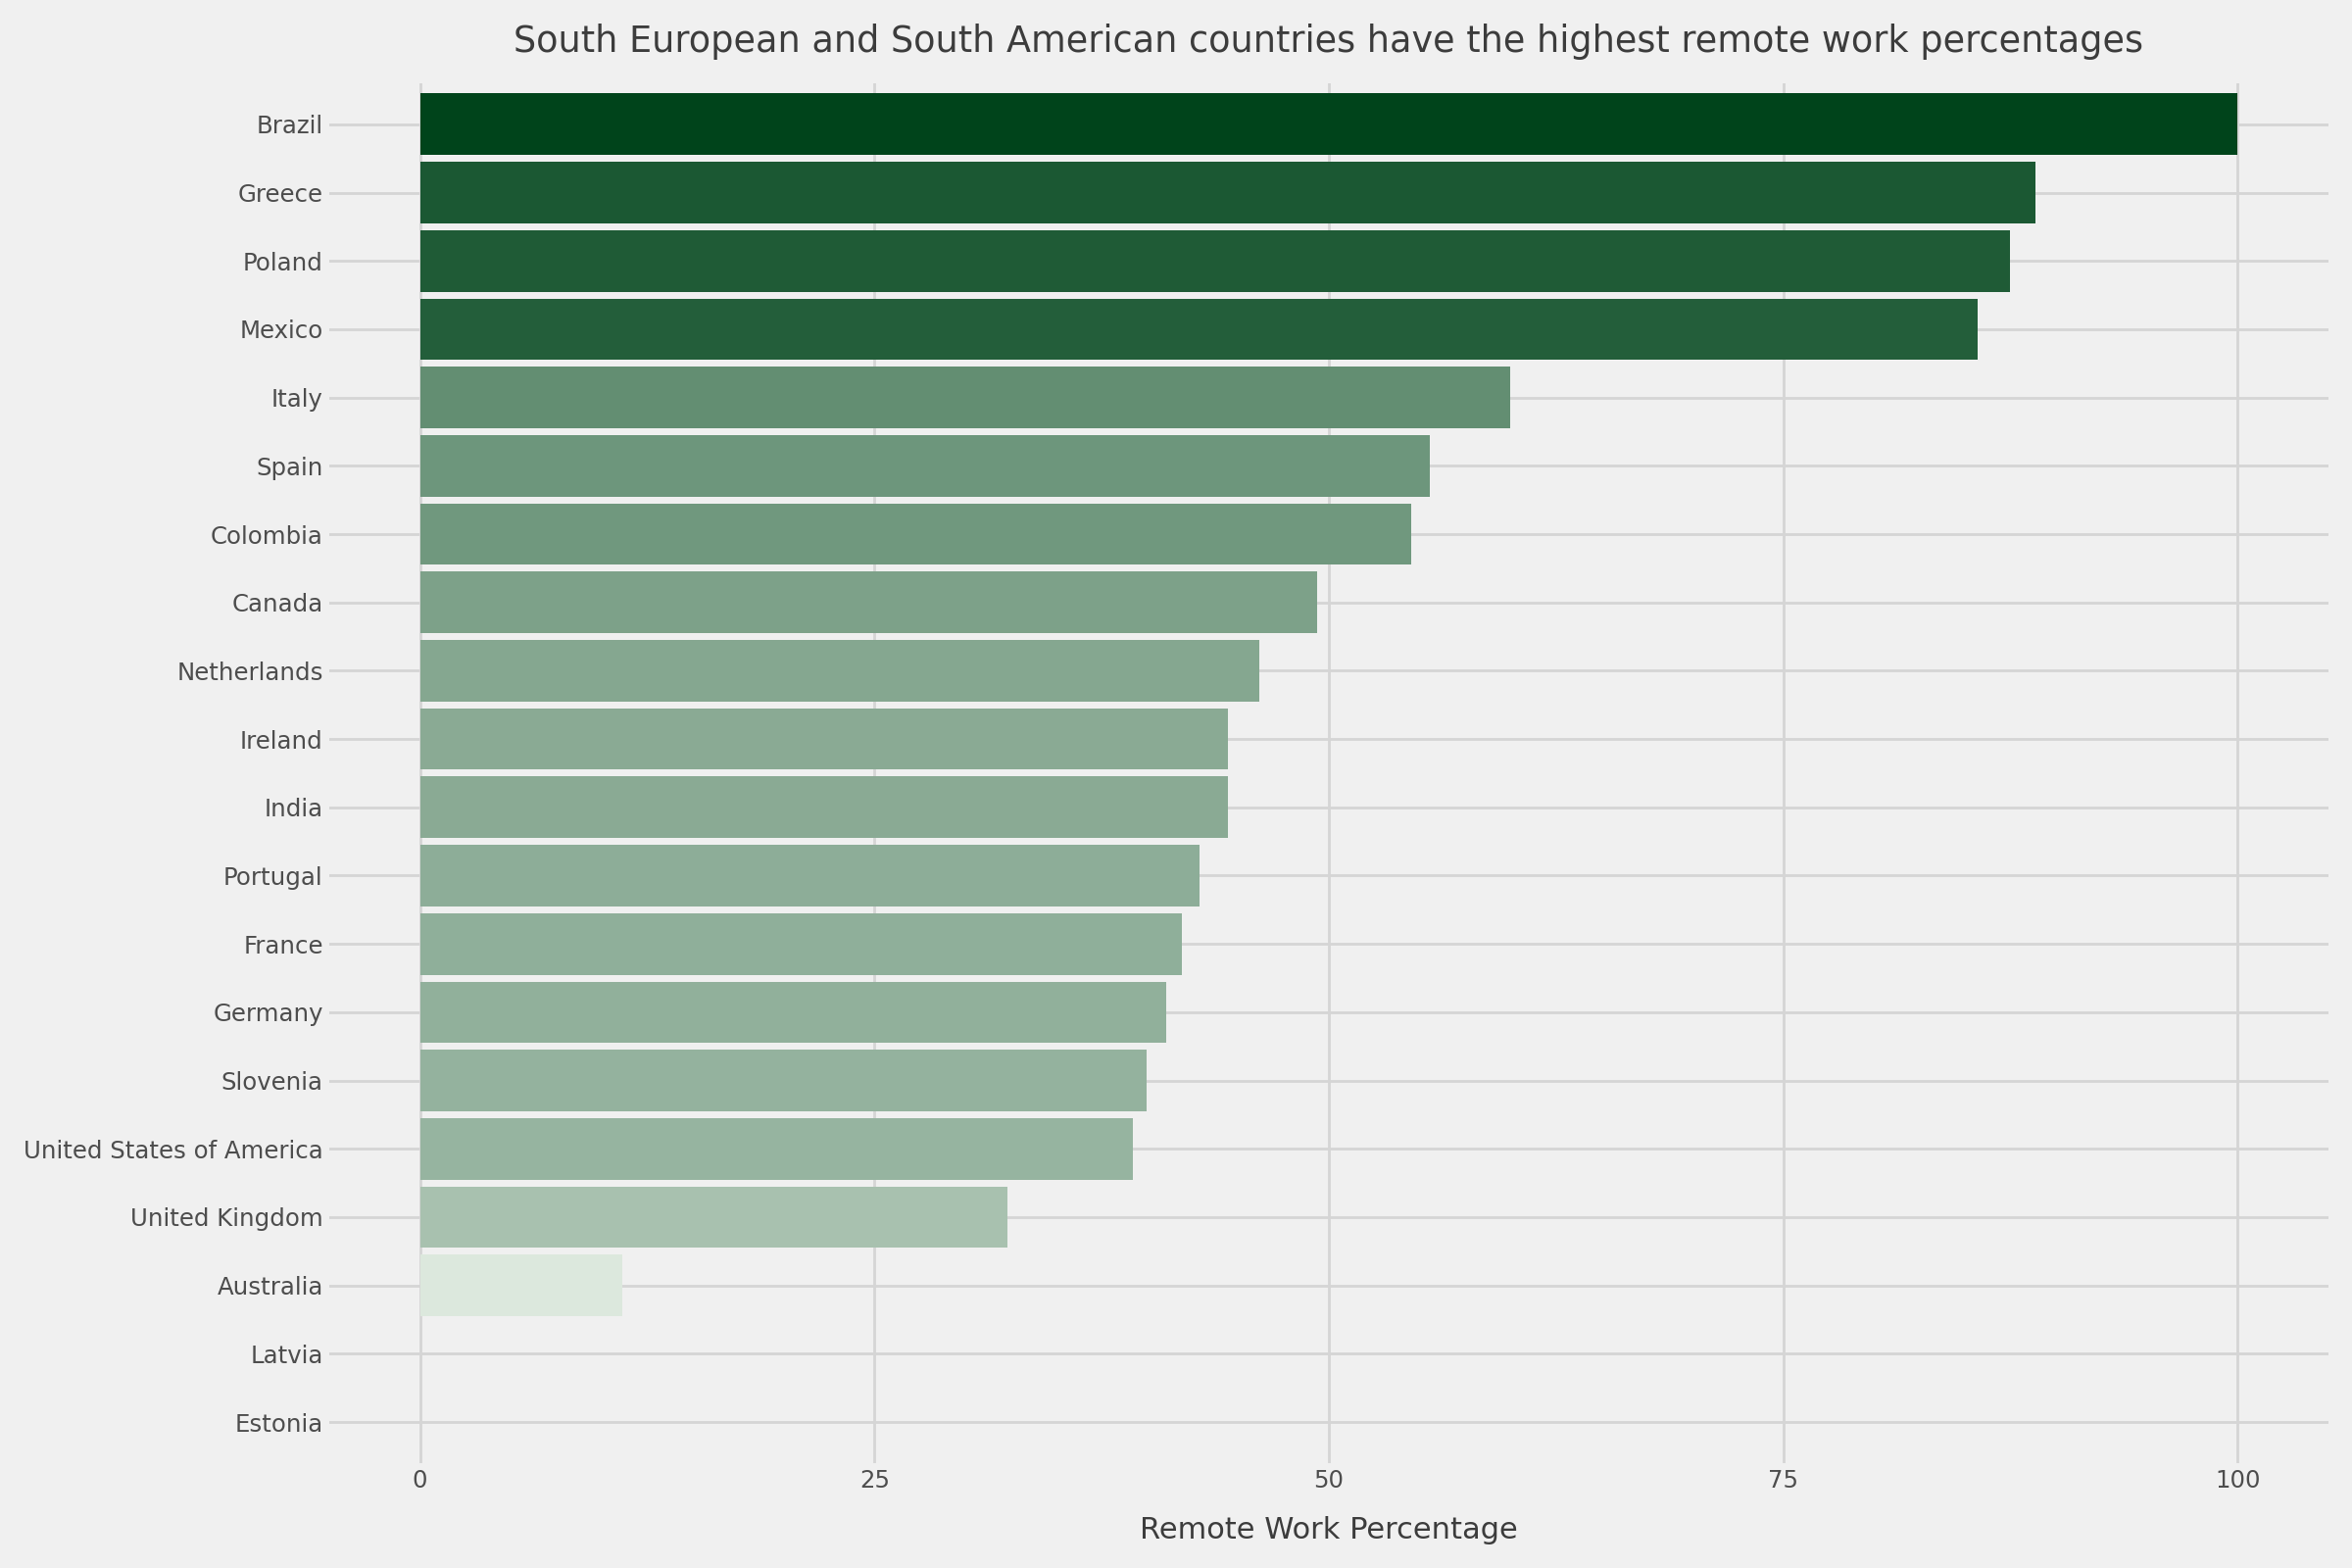

In [76]:
(
    ggplot(remote_prop.dropna(), aes(x="reorder(country,work_models)", y="work_models"))  # Map x: country names reordered by remote work percentage, y: remote work percentage
    + geom_col(aes(fill="work_models"))  # Colored bars by remote work percentage
    + theme(figure_size=(12,8))  # Set figure size
    + coord_flip()  # Flip axes
    + labs(x="", y="Remote Work Percentage", title = "South European and South American countries have the highest remote work percentages")  # Axis labels
    + scale_fill_gradient(guide = None, # Gradient fill for salary and remove legend
                           low = "#f7fcf5", high="#00441b", # Set color range
                           labels=lambda l: [lab_currency(x) for x in l],  # Format color labels
                           )
)

Let's focus on the USA market. 

In [77]:
usa_data = data[data["country"] == "United States of America"] # Filter data for the United States
salaries_job_title= (usa_data.groupby(["job_title","work_year"]).median("salary_in_usd")).reset_index() # Compute median salary by job title and year
salaries_exp_level= (usa_data.groupby(["experience_level","work_year"]).median("salary_in_usd")).reset_index() # Compute median salary by experience level and year

2025-09-06 13:21:24 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_28164\1101417268.py lineno=2
2025-09-06 13:21:24 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_28164\1101417268.py lineno=3


Let's take a look at the salary behavior in the years 2020-2024. The salary trend is positive, with a slight decrease in 2023. This might be due to the economic situation, with a high inflation and a possible recession. Nevertheless, the trend is still positive, which is a good sign for the data science job market. Or it might be that in 2023 the better paying companies hired more, while in 2024 the worst paying companies hired more, leading to a decrease in the median salary.

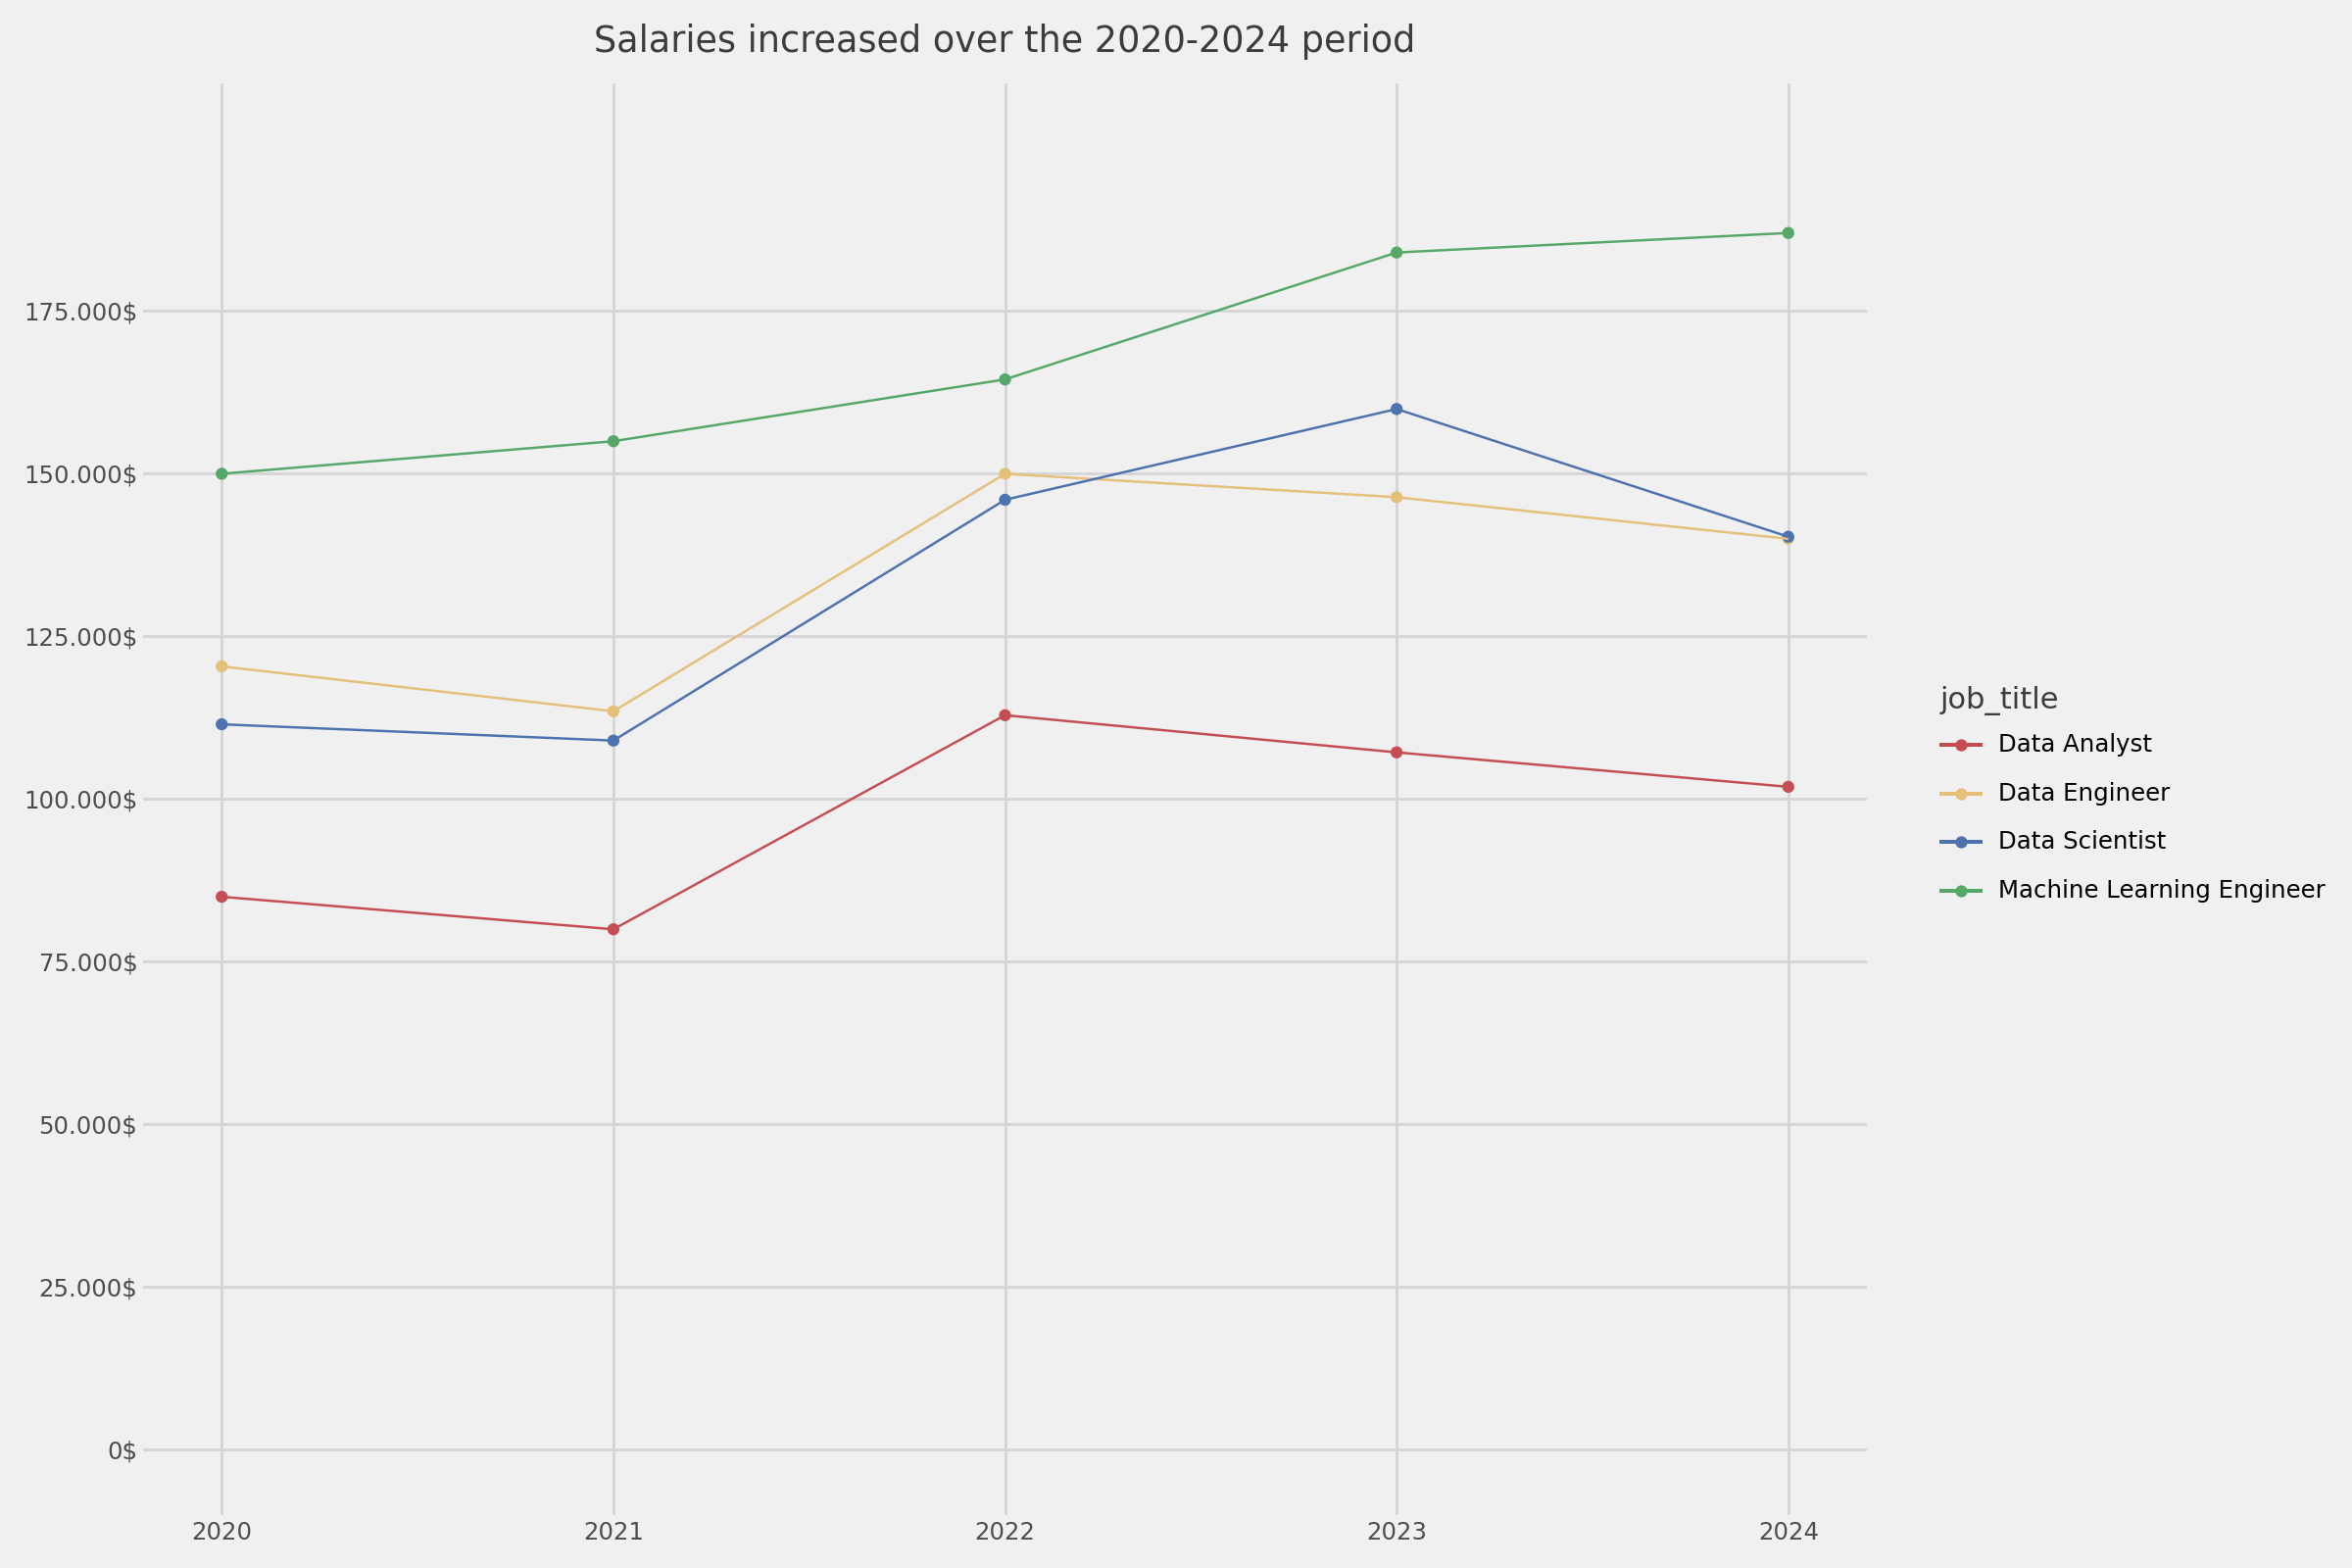

In [79]:
(
    ggplot(salaries_job_title, aes(x='work_year', y='salary_in_usd', color = 'job_title', group ='job_title')) # Map x: work year, y: salary in USD
    + geom_point() # Add point geometry
    + geom_line() # Add line geometry
    + scale_color_manual(cols,  # Define custom color scale
                         labels = lambda l: [x.title() for x in l]) # Format color labels
    + scale_y_continuous(labels = lambda l: [lab_currency(x) for x in l], limits = (0,200000), breaks = range(0,200000,25000))  # Define y-axis breaks and labels
    + labs(title = "Salaries increased over the 2020-2024 period", x = "",y = "", fill = "Job Title") # Add labels
    + theme(figure_size=(12,8)) # Customize theme
)

Now, let's take a look at the distribution of salaries by job title and experience level in the USA market.

2025-09-06 13:23:16 [warning  ] stat_ydensity : Removed 11 rows containing non-finite values. category=PlotnineWarning 

filename='c:\\Users\\Marco\\Desktop\\Basics of computing\\.data_science_salaries\\.main\\.venv\\Lib\\site-packages\\plotnine\\layer.py' lineno=293


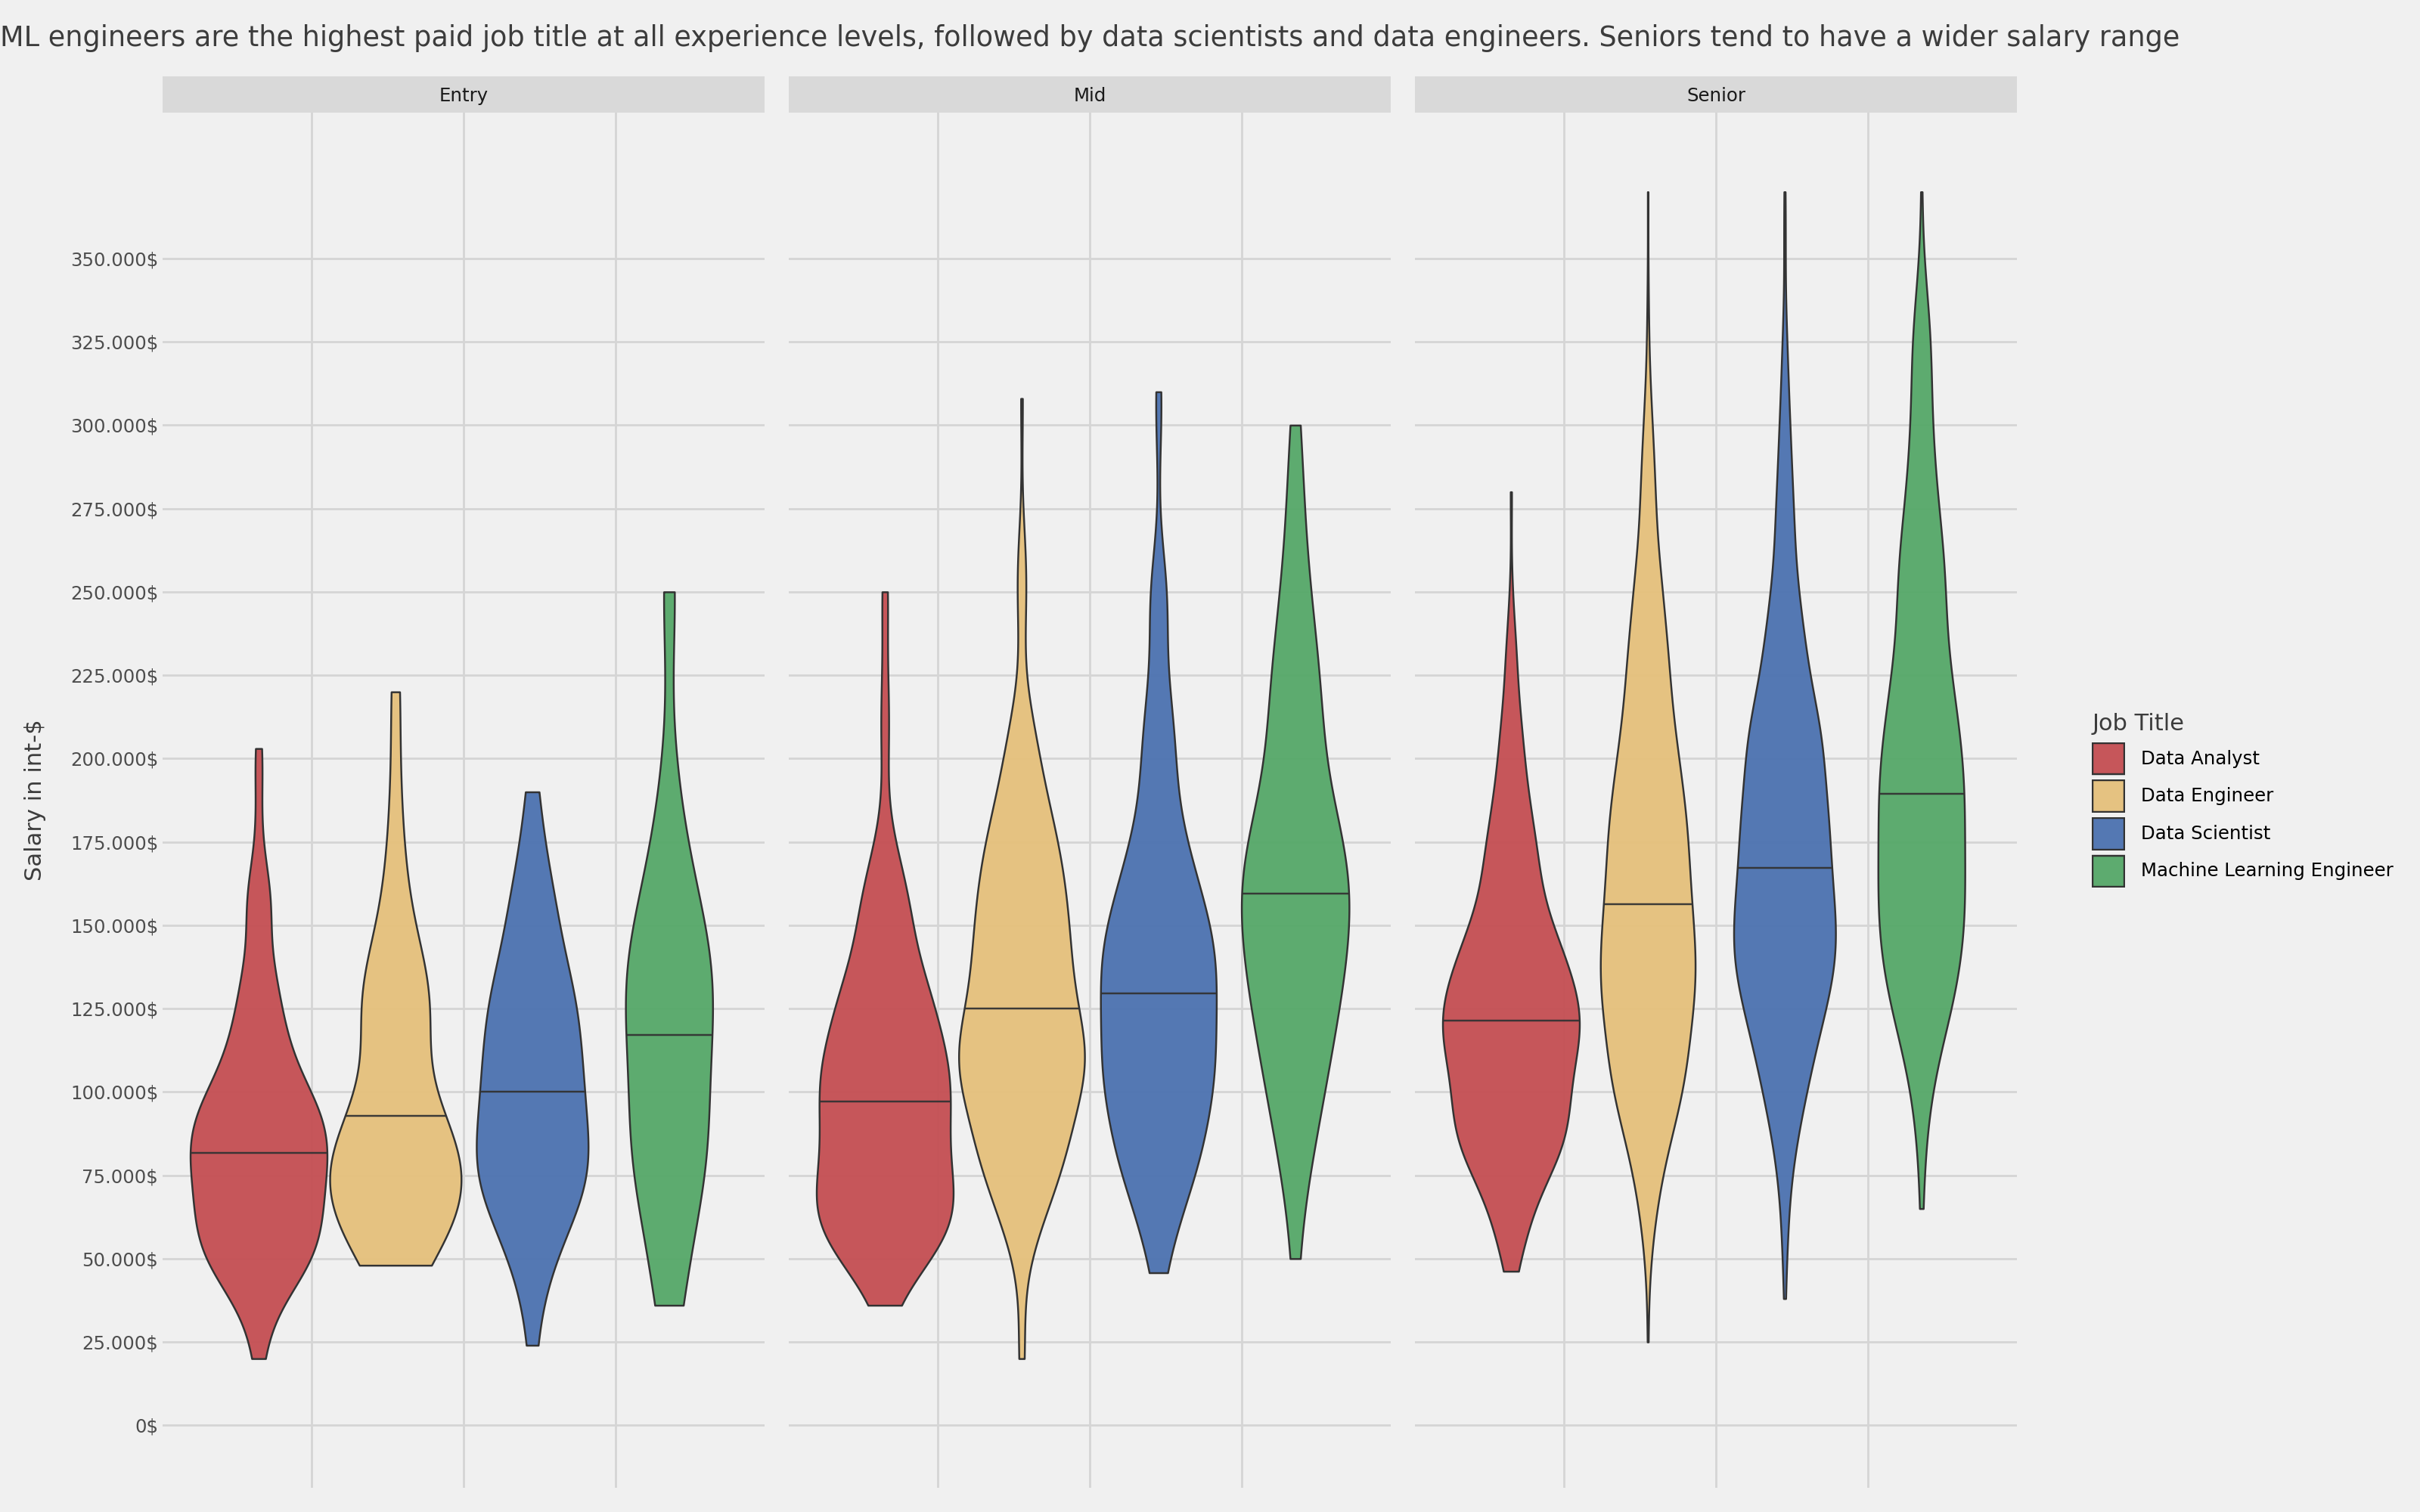

In [81]:
(
    ggplot(usa_data, aes(y='salary_in_usd', fill = 'job_title')) # Map x: experience level, y: salary 
    + geom_violin(draw_quantiles = 0.5, alpha=0.95) # Create violin plot with quantile lines and draw median
    + scale_y_continuous(labels = lambda l: [lab_currency(x) for x in l], limits = (0,375000), breaks = range(0,375000,25000))  # Define y-axis breaks and labels
    + scale_fill_manual(cols)
    + facet_wrap("experience_level")  
    + theme(figure_size=(16,10), axis_text_x=element_blank())
    + labs(y="Salary in int-$",
           fill = "Job Title",
           title = "ML engineers are the highest paid job title at all experience levels, followed by data scientists and data engineers. Seniors tend to have a wider salary range")
)

First thing first, the best paid role is the Machine Learning Engineer, followed by Data Scientists and Data Engineers. Data Analysts are the worst paid role. This is not surprising, since Machine Learning Engineers are the most specialized role, while Data Analysts are the least specialized role. It's also interesting to see that while the junior level salary is concentrated in a small range, the senior level salary is more dispersed, especially for Machine Learning Engineers and Data Scientists. This might be due to the fact that senior roles might specialize in different areas, leading to a higher dispersion in salaries.

Let's see how the salaries behaved in the years 2020-2024 for each experience level.

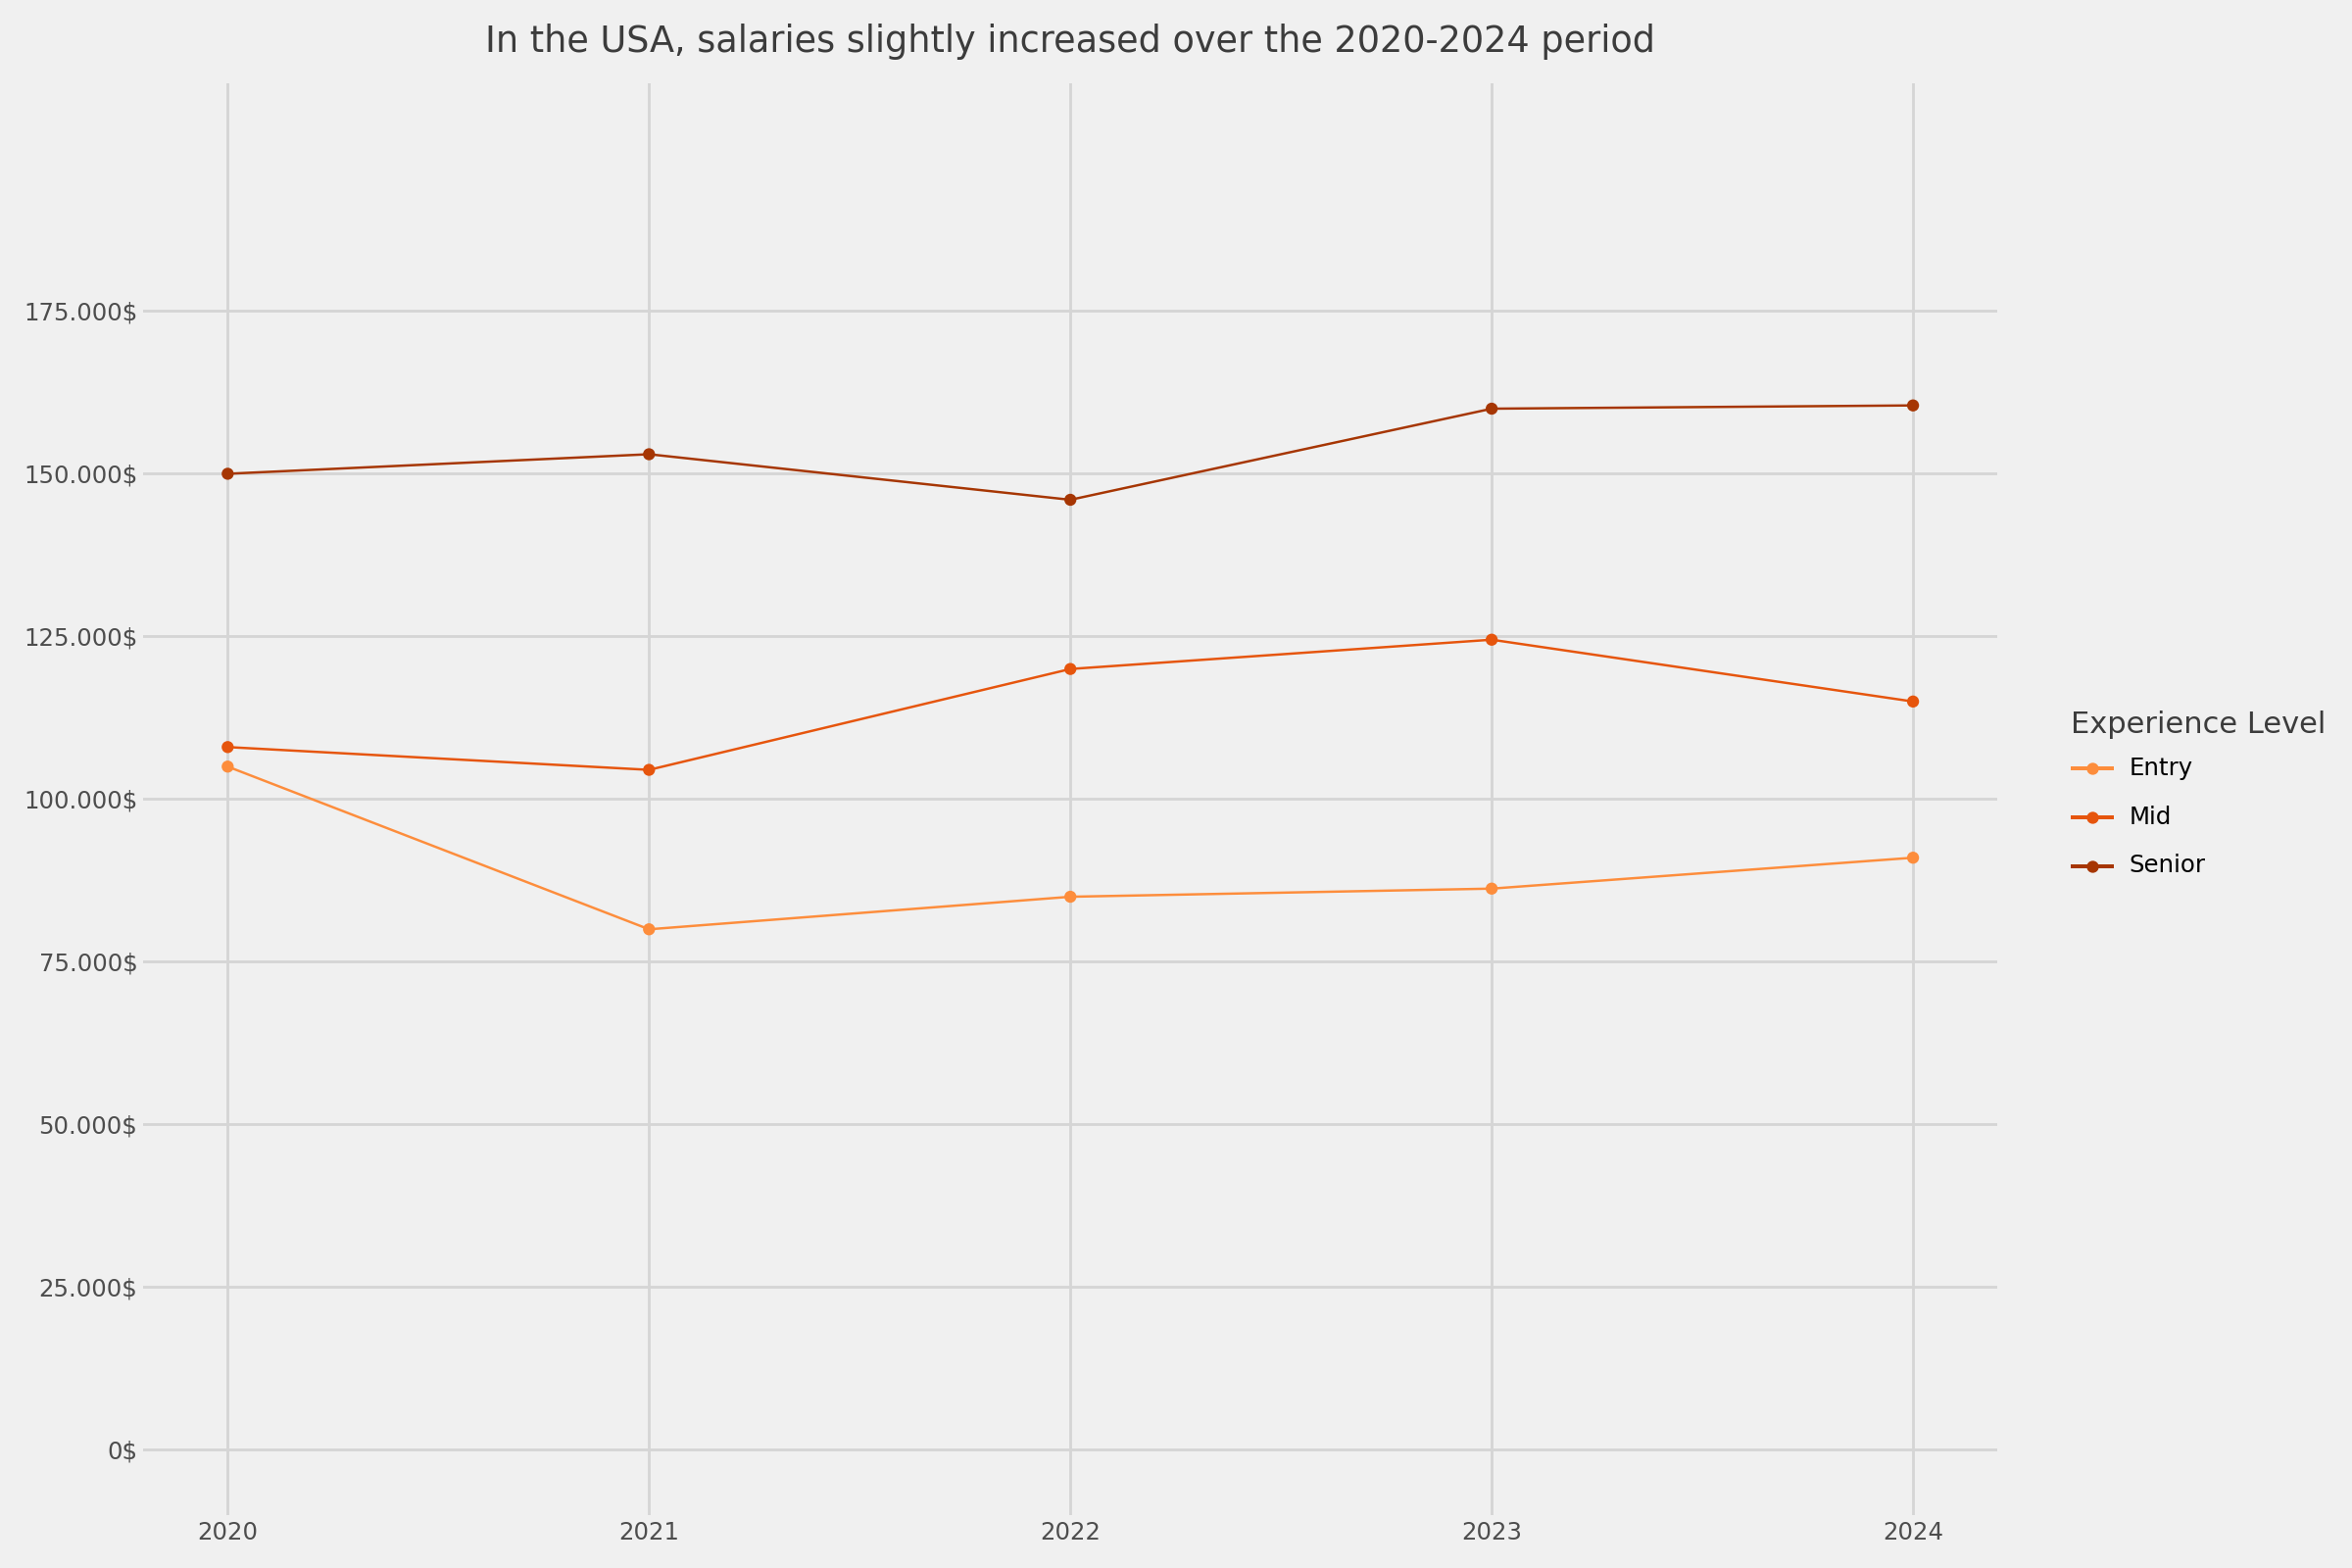

In [83]:
(
    ggplot(salaries_exp_level, aes(x='work_year', y='salary_in_usd', color = 'experience_level', group ='experience_level'))  # Map x: work year, y: salary in USD
    + scale_y_continuous(labels = lambda l: [lab_currency(x) for x in l], limits = (0,200000), breaks = range(0,200000,25000))  # Define y-axis breaks and labels
    + geom_point() # Add point geometry
    + geom_line() # Add line geometry
    + scale_color_manual(values = ["#fd8d3c","#e6550d","#a63603"], # Define custom color scale
                         labels = lambda l: [x.title() for x in l]) # Format color labels
    + labs(title = "In the USA, salaries slightly increased over the 2020-2024 period", x = "",y = "", color = "Experience Level") # Add labels
    + theme(figure_size=(12,8)) # Customize theme
)

We can see that all of them had a quite stable small increase in salaries.

Let's take a look at the job positions per year and company size.

In [84]:
hiring_per_year = data.groupby(["company_size", "work_year","job_title"]).count().reset_index().loc[:,["company_size","work_year","job_title","experience_level"]].rename(columns = {"experience_level": "job_positions"}) # Compute number of job positions by company size, year, and title
hiring_per_year.replace(0,nan, inplace = True) # Replace 0 with NaN

2025-09-06 13:23:56 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_28164\2170869658.py lineno=1


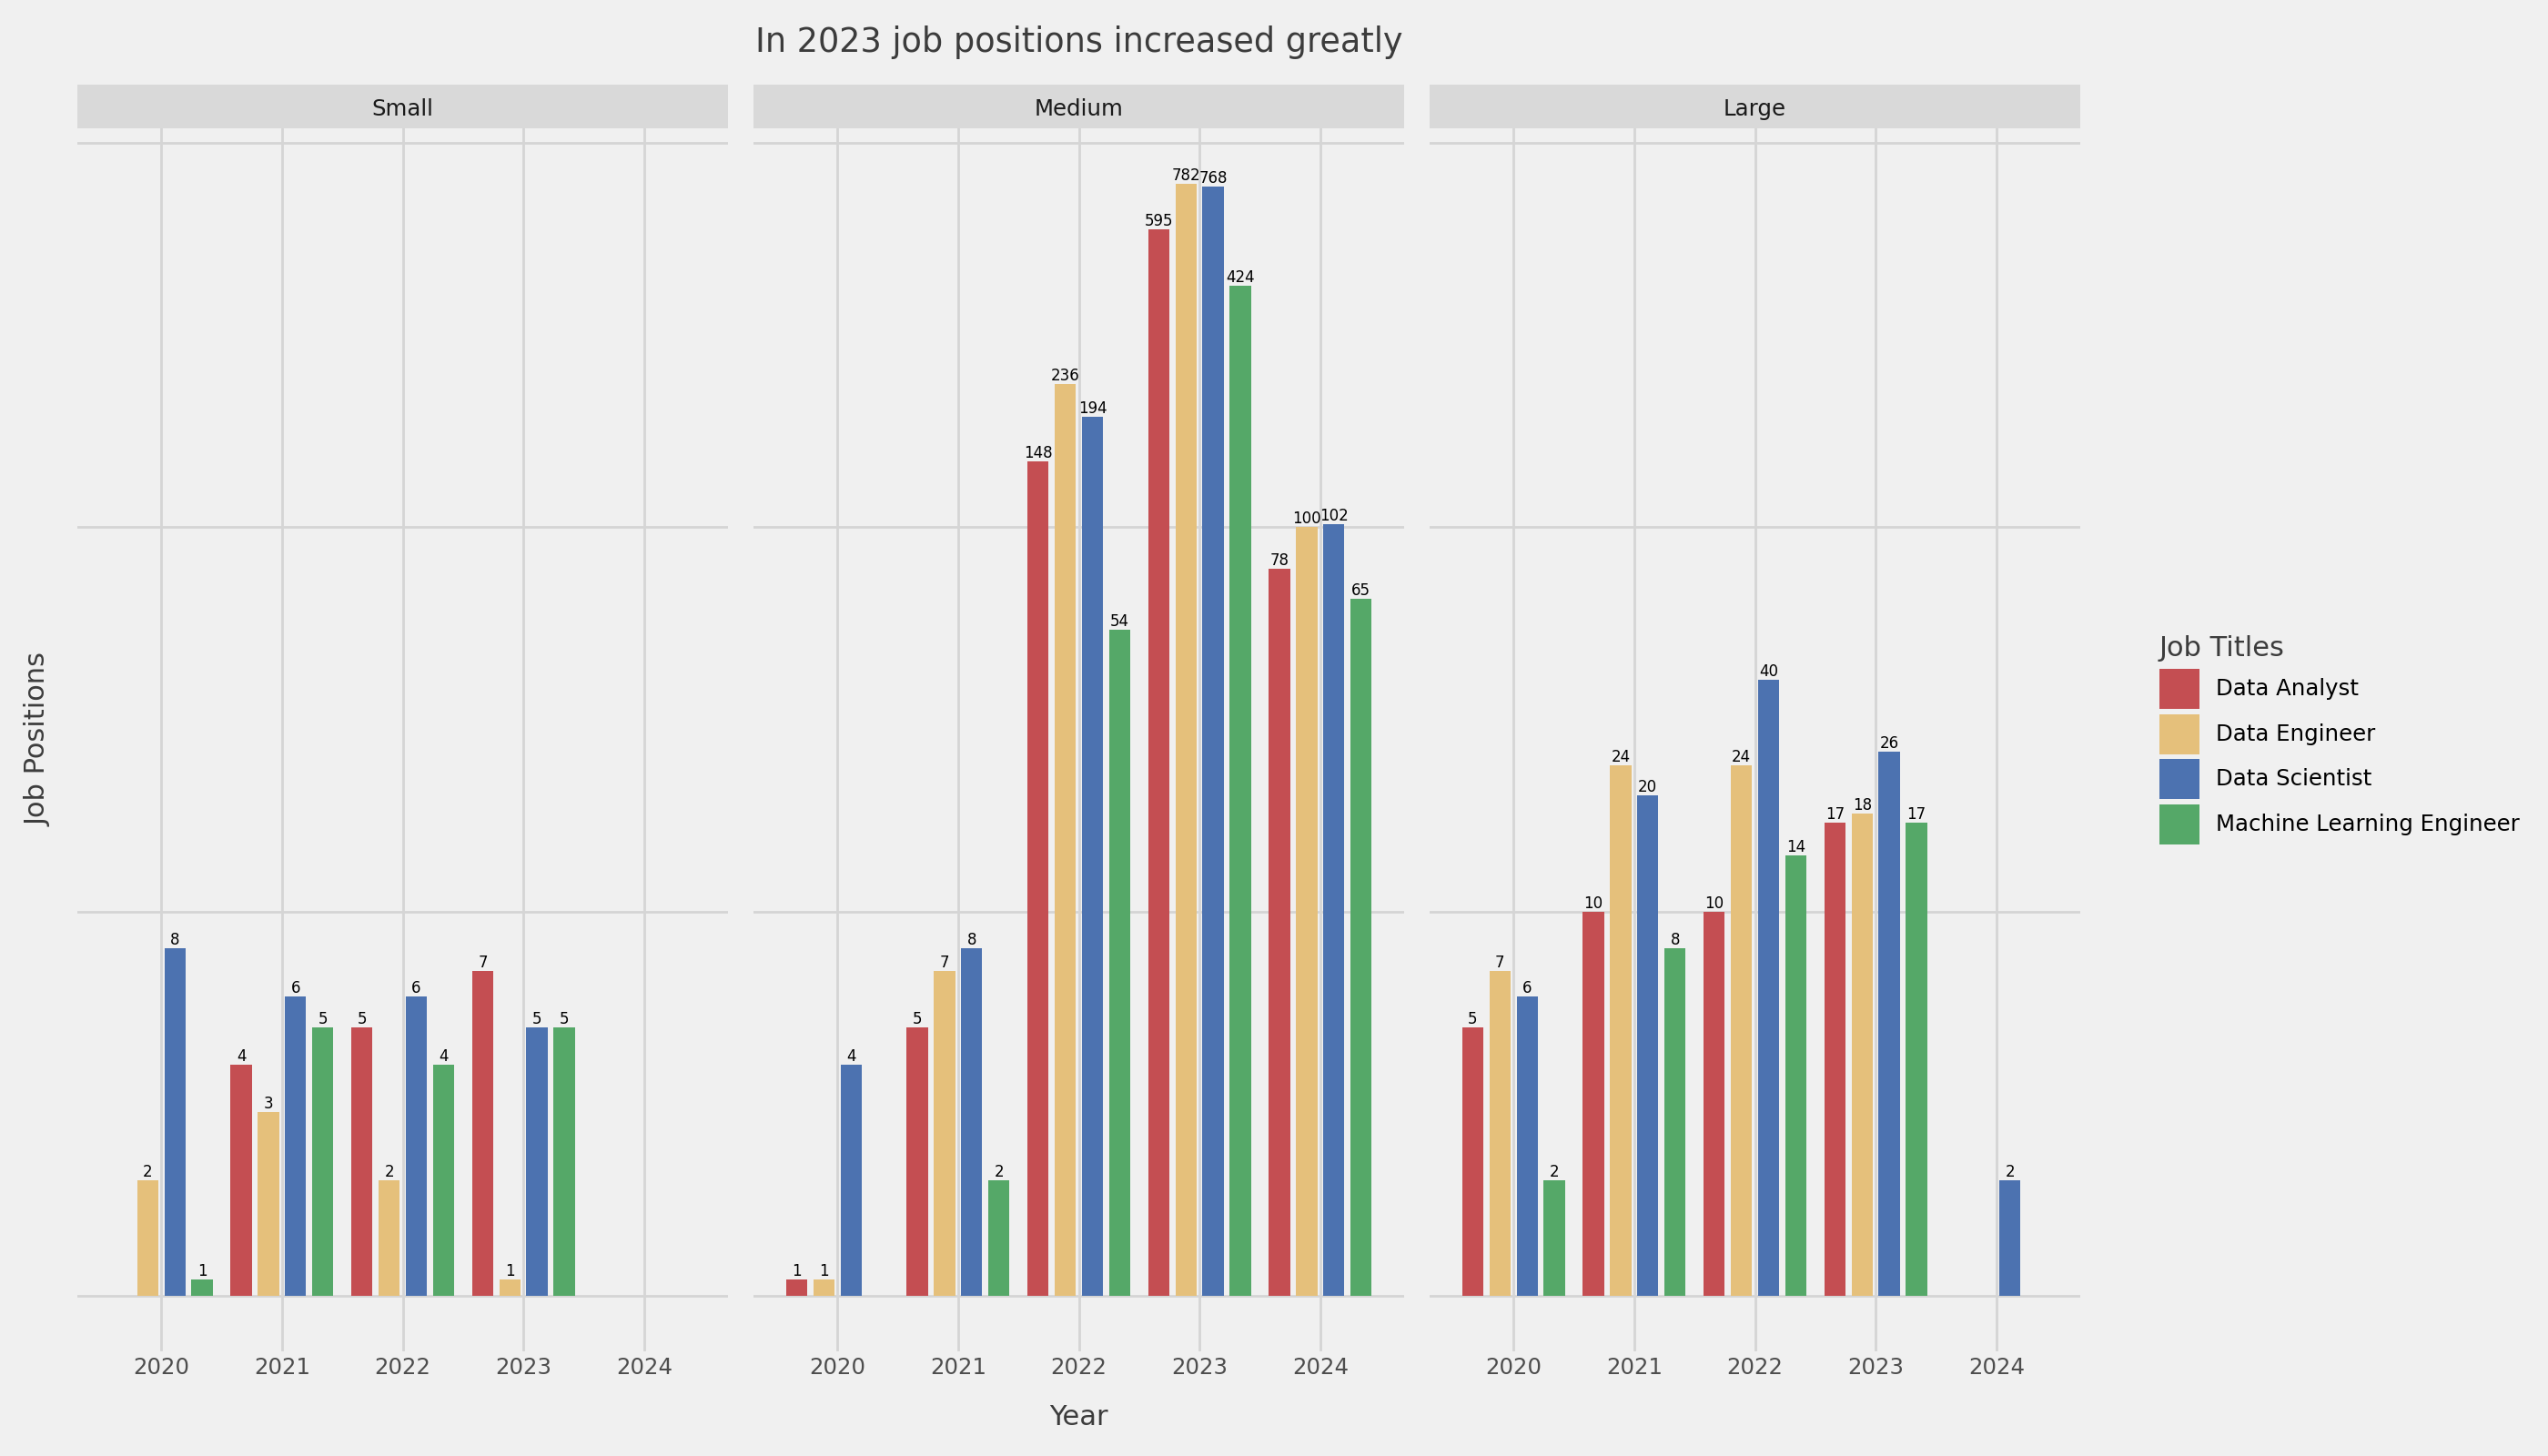

In [86]:
(
    ggplot(hiring_per_year.replace(1,1.1), aes(x='work_year', y = 'job_positions', fill = 'job_title'))  # Map x: work year, y: job positions
    + geom_col(position=position_dodge(width=0.9), # Add column geometry
               width=0.7, # Set column width
               na_rm=True) # Remove missing values
    + geom_text(aes(label = 'job_positions'), # Add text labels
                size = 6, # Set text size
                position=position_dodge(width=0.9), # Adjust position for dodging
                va='bottom', # Set vertical alignment
                format_string = "{:.0f}", # Format string for labels
                na_rm=True) # Remove missing values
    + scale_y_log10() # Set y-axis to logarithmic scale
    + scale_fill_manual(cols, # Set custom fill colors
                        labels = lambda l: [x.title() for x in l]) # Format fill labels
    + facet_grid(cols = "company_size", # Create facet grid by company size
                 labeller = lambda x: x.capitalize()) # Capitalize facet labels
    + theme(figure_size=(14,8), # Customize figure size
            axis_text_y=element_blank(), # Remove y-axis text
            axis_ticks_y=element_blank()) # Remove y-axis ticks
    + labs(x = "Year",y = "Job Positions", fill = "Job Titles", title = "In 2023 job positions increased greatly") # Add labels

)

The vast majority of hirings was done by medium companies, followed by large companies. Small companies hired very few data workers. It's interesting how medium companies hired the most data engineers, while large companies hired the most data scientists. This might be due to the fact that medium companies need more data engineers to build and maintain their data infrastructure, while large companies have already a well established infrastructure and need more data scientists to analyze the data, provide insights and train AI models.

One important aspect of a salary distribution is the **Gini Index**. The Gini Index is a measure of statistical dispersion that represents the income inequality within a nation or a social group. A Gini Index of 0 represents perfect equality, while a Gini Index of 1 represents perfect inequality.

Let's define a function to compute the Gini Index and then compute it for each country and job title.

In [87]:
def gini(x): # Define function to compute Gini index
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += sum(abs(xi - x[i:]))
    return total / (len(x)**2 * mean(x))

gini_index = data.loc[:,["country","job_title","salary_in_usd","company_size"]]
gini_index=gini_index.groupby(["country","job_title"])["salary_in_usd"].apply(lambda x: gini(x)).reset_index().rename(columns = {"salary_in_usd": "gini_index"})

2025-09-06 13:24:26 [warning  ] The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning. category=FutureWarning filename=C:\Users\Marco\AppData\Local\Temp\ipykernel_28164\3084398933.py lineno=8


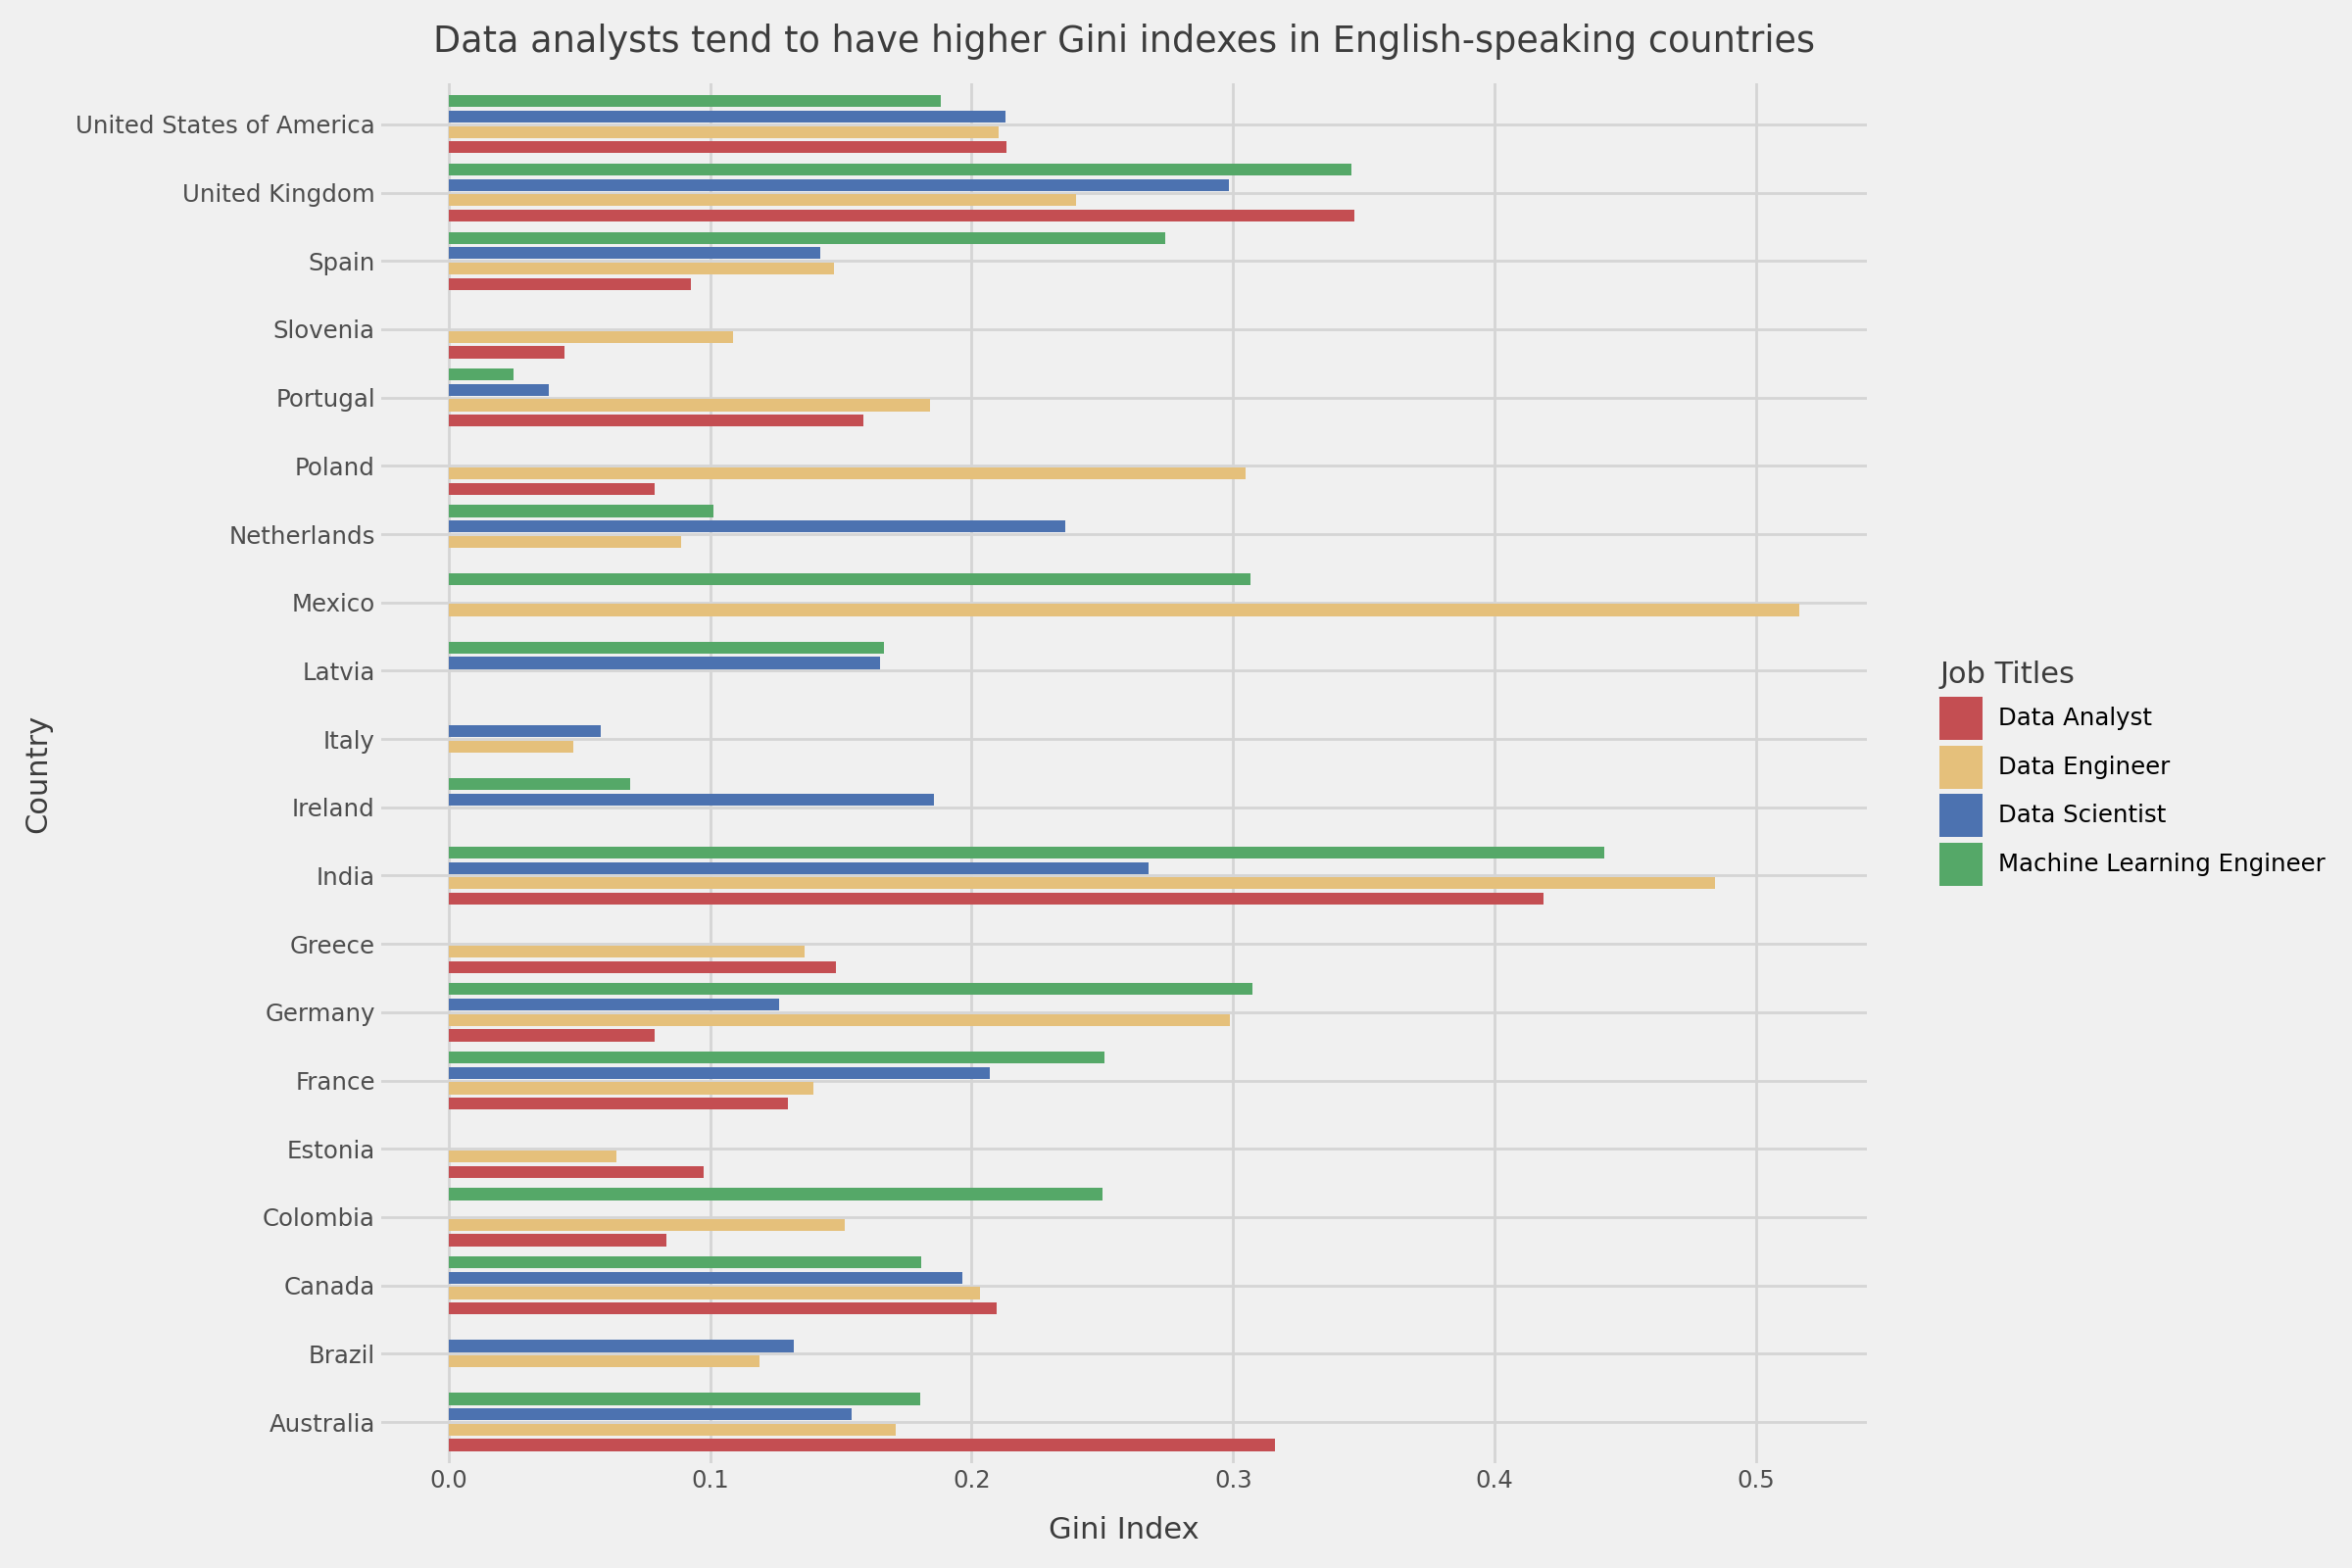

In [89]:
(
    ggplot(gini_index, aes(x='country', y = 'gini_index', fill = 'job_title')) # Map x: company location, y: Gini index
    + geom_col(position=position_dodge(width=0.9), # Adjust position for dodging
               width=0.7,# Set column width
               na_rm=True) # Remove missing values
    + scale_fill_manual(cols, # Set custom fill colors
                        labels = lambda l: [x.title() for x in l]) # Format fill labels
    + coord_flip() # Flip coordinates
    + theme(figure_size=(12,8)) # Customize theme
    + labs(x = "Country",y = "Gini Index", fill = "Job Titles", title = "Data analysts tend to have higher Gini indexes in English-speaking countries") # Add labels
)

To confirm the previous observations, we can see that the countries with the highest Gini Index are the ones with the highest salary dispersion, like the US and Canada. On the other hand, countries like Germany and Portugal have a lower Gini Index, confirming the lower salary dispersion we saw before. It's interesting how data analysts tend to have an higher Gini Index. 

## Conclusions

The data job market is rapidly expanding, and in all countries the salaries are well above the national median. The most in demand roles are data scientists and data engineers, while machine learning engineers are the best paid role. The job market is quite stable, with a slight increase in salaries in the last years. The best countries to work as a data worker are the United States and Canada, with a median salary of around 150k int-USD. Regarding Europe, the best countries are, in order, UK, Portugal and Germany. The salary dispersion is quite high in the US and Canada, while in Europe it is lower. Most of data workers work in medium companies, that also pay more than large companies. Remote working is quite common, with around 30% of data workers working remotely in well documented countries like the USA and UK. have a quite stable salary trend, with a slight increase in the last years.